In [66]:
# Basic Data Science
import numpy as np
import pandas as pd
import itertools
import sklearn

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import gridspec
from IPython.display import display

# Sklearn - Models
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Sklearn - Preprocessing & Feature Selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import (
    SelectKBest,
    chi2, 
    RFE,
    mutual_info_regression,
    f_classif,
    mutual_info_classif,
    SelectFromModel,
    VarianceThreshold
)
from sklearn.decomposition import PCA

# Sklearn - Model Selection & Metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    make_scorer,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    auc,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_sample_weight

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Utilities
from tqdm import tqdm
import warnings
import logging
import joblib
import os
import traceback
import tempfile
from datetime import datetime
import scipy.special

# Silence warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
logging.getLogger('sklearn').setLevel(logging.FATAL)
pd.options.mode.chained_assignment = None
np.seterr(all="ignore")

print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

NumPy version: 1.23.5
scikit-learn version: 1.2.2


# Introduction

This notebook details all the different models (recency and rating models) and feature selection methods we explored. The structure of the Notebook is as follows: Data Import, Data Transformation & Exploration, Methodology Overview, Model Training & Validation, Results, Final Prediction on Test Set.

# Data Import

First, load the data into our Pandas DataFrame. Sort by date and denote which Season each match corresponds to. 

In [67]:
data_dir = "finalData.csv"
df = pd.read_csv(data_dir)

In [68]:
# renaming the columns
df.columns = ['Date', 'Home Team', 'Away Team', 'Full Time Home Goals', 'Full Time Away Goals', 'Full Time Result',       
'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Shots on Target',   
'Away Shots on Target', 'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards',     
'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Passes Completed', 'Home Passes PCT',
'Home Progressive Passes', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons Won', 'Home Take Ons', 
'Home Interceptions', 'Home Blocks', 'Home Touches', 'Home Touches Def 3rd', 'Home Touches Mid 3rd', 'Home Touches Att 3rd',
'Home Carries', 'Home Carries Progressive Distance', 'Home Tackles', 'Home Tackles Won', 'Away Passes Completed',
'Away Passes PCT', 'Away Progressive Passes', 'Away Progressive Passing Distance', 'Away xG',
'Away Take Ons Won', 'Away Take Ons', 'Away Interceptions', 'Away Blocks', 'Away Touches', 'Away Touches Def 3rd',
'Away Touches Mid 3rd', 'Away Touches Att 3rd', 'Away Carries', 'Away Carries Progressive Distance', 'Away Tackles',
'Away Tackles Won']

In [69]:
# ensure sorted by date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by='Date')

# each season starts at 08 and ends at 05 of next year - 2000-2001 season will be the 2000 season
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

df['Season'] = df['Date'].apply(get_season)

# create numerical Match Outcome from Full Time Result
df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})

# Data Transformation & Exploration

## Feature Engineering

In [70]:
# standardises features (mean=0, variance=1)
def standardisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = StandardScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# normalises a specific set of columns
def normalisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = MinMaxScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# label encoding - use for boosting models
def label_encoding(df, col=['Home Team', 'Away Team'], dataframe=True):
    label_encoder = LabelEncoder()
    if dataframe:
        for c in col:
            df[c] = label_encoder.fit_transform(df[c])
    else:
        df = label_encoder.fit_transform(df)
    return df

Performs PCA on the data.

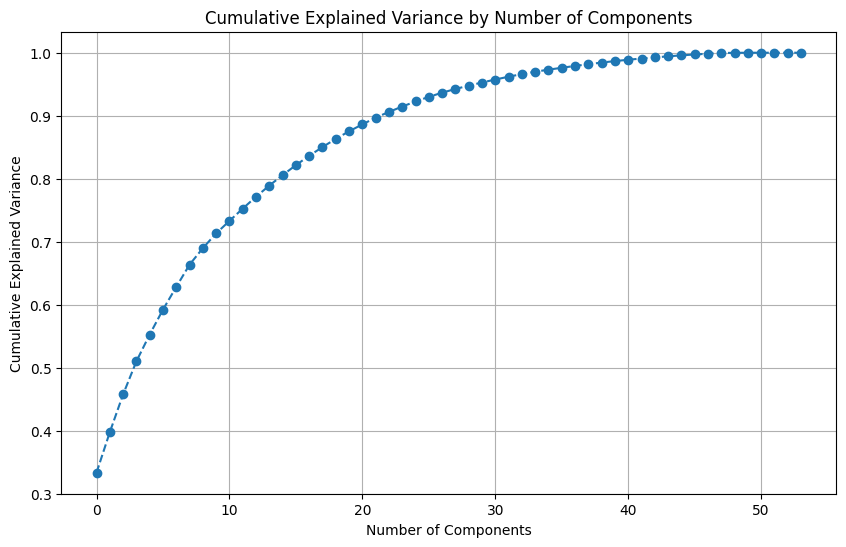

Optimal Number of Components: 30


In [71]:
def pca(df):
    # drop the irrelevant terms
    featuresToDrop = ['Date', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    df2 = df.drop(featuresToDrop, axis=1)
    
    df2 = standardisation(df2, terms=list(df2.columns))
    
    pca = PCA()
    pca_components = pca.fit_transform(df2)
    
    # find the explained variance ratio
    explained_variance = pca.explained_variance_ratio_

    # select number of components based on explained variance (e.g., 95% variance)
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    
    return n_components
    
number_of_components = pca(df)
print("Optimal Number of Components:", number_of_components)

Next, we reduced the feature data set to 5 sections of inputs: Home Advantage, Attacking Strength, Midfield Strength, Defensive Strength, and extras. 

Discarded features include: 

'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards', 'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons', 'Home Touches', 'Home Touches Def 3rd', 'Home Carries Progressive Distance', 'Away Progressive Passing Distance', 'Away xG', 'Away Take Ons', 'Away Touches', 'Away Touches Def 3rd', 'Away Carries Progressive Distance'.

In [72]:
features = [
    # Home Advantage
    "Home Team",
    "Away Team",
    "Match Outcome",
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    
    # Extra
    "Full Time Result",
    'Date', 'Season'
]

new_df = df[features].copy()
new_df.dropna(inplace=True)

Perform Chi Square to explore the relative importance of different features.

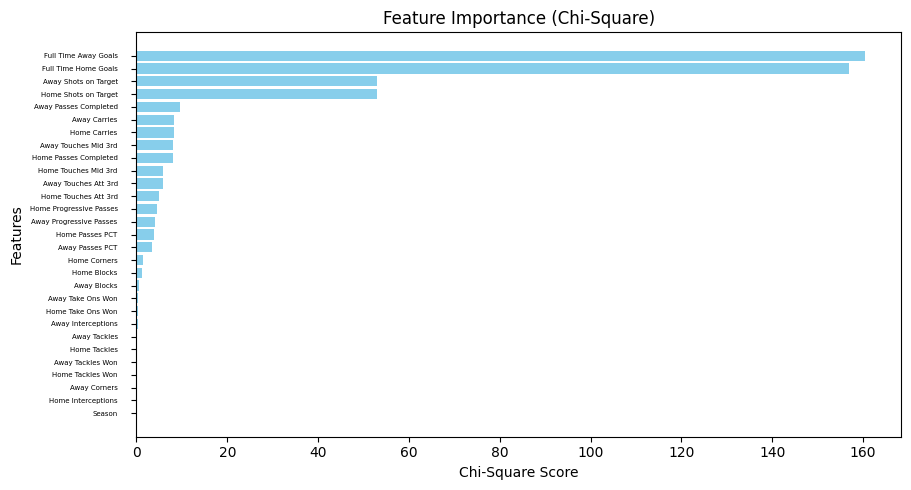

In [73]:
def chi_square(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Home Team', 'Full Time Result', 'Away Team', 'Match Outcome']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})
    target = df['Match Outcome']
    
    # chi2 scoring function requires non-negative input: normalisation
    data = normalisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # perform chi square selection    
    chi_select = SelectKBest(chi2, k=min(number_of_components, len(data.columns)))
    new_data = chi_select.fit_transform(data, target)
    
    # collect features
    selected_features = []
    for i, b in enumerate(chi_select.get_support()):
        if b:
            selected_features.append(feature_names[i])
    
    # get the chi-square scores for all features
    chi_scores = chi_select.scores_

    # create a dataFrame for easy visualization
    chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi-Square Score': chi_scores})
    chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

    # plot the scores
    plt.figure(figsize=(10, 5))
    colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(chi2_df))]
    plt.barh(chi2_df['Feature'], chi2_df['Chi-Square Score'], color=colours)
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Chi-Square)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    return chi2_df
    
chi2_df = chi_square(new_df)   

## Strength Features

Now we will take the feature importance scores from the Chi-Square distribution and adjust the weights to approach a gradual steady decline. This will allow the less important features to still contribute to our feature engineering function - create_strength_features_separate() - while preserving a hierarchical ranking. Graphs of these newly adjusted feature importance scores are given.

Note: the number 1/3 was chosen arbitrarily but it was observed to be a standard heuristic among Machine Learning papers.

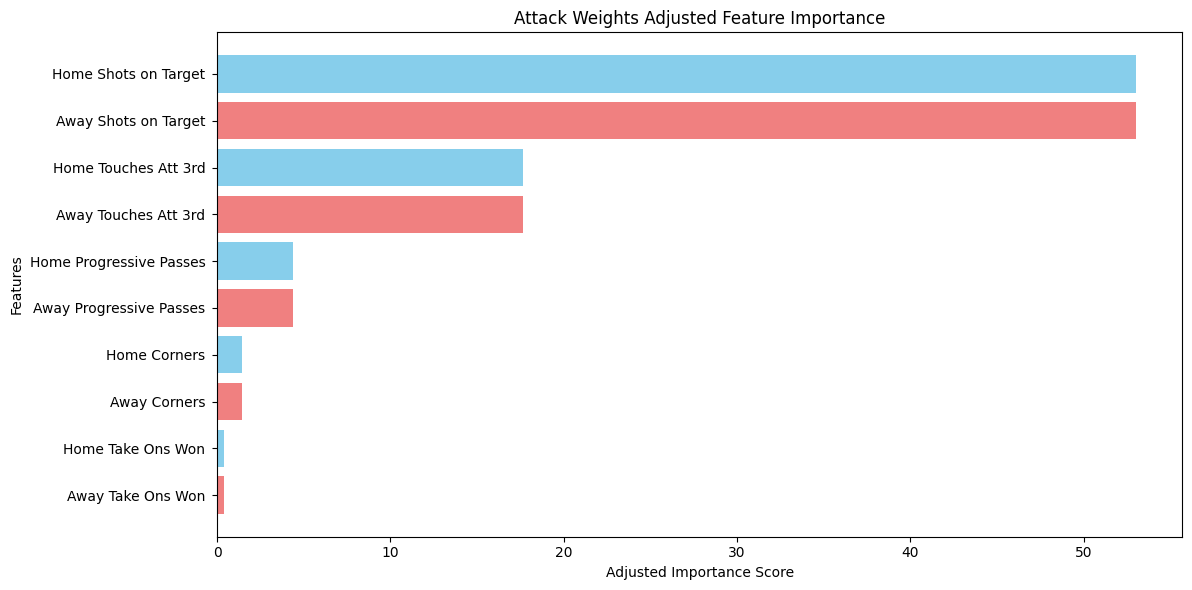

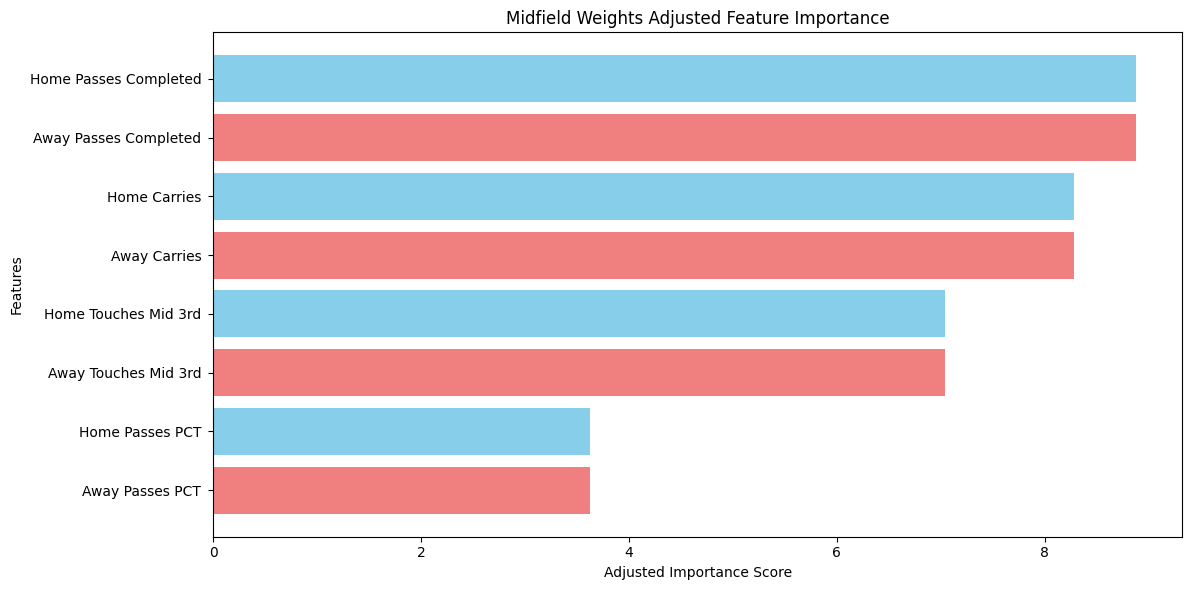

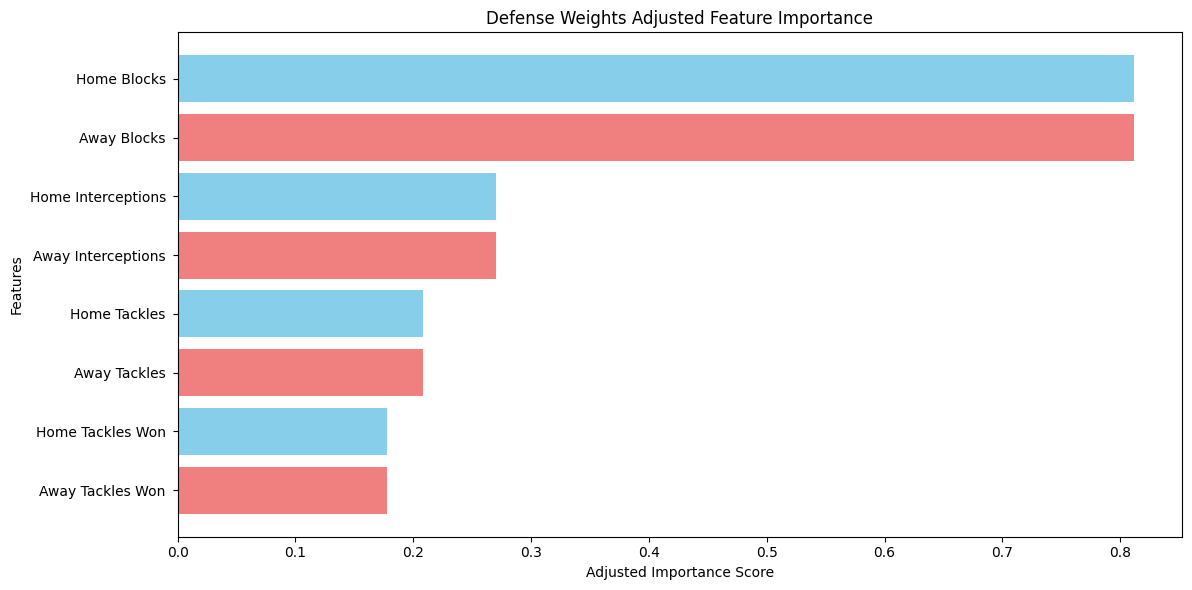

In [74]:
def adjust_feature_weights(features, chi2_df):
    # Aggregate Home and Away importance scores
    aggregated_scores = {}
    for feature_pair in features:
        home_feature, away_feature = feature_pair
        home_score = chi2_df.loc[chi2_df['Feature'] == home_feature, 'Chi-Square Score'].values[0]
        away_score = chi2_df.loc[chi2_df['Feature'] == away_feature, 'Chi-Square Score'].values[0]
        aggregated_scores[feature_pair] = home_score + away_score

    # Sort features by aggregated importance
    sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Adjust scores using the /3 rule
    adjusted_scores = {}
    adjusted_scores[sorted_features[0][0]] = sorted_features[0][1]  # Most important feature remains unchanged
    
    for i in range(1, len(sorted_features)):
        current_feature, current_score = sorted_features[i]
        previous_feature, previous_score = sorted_features[i - 1]
        
        if current_score < previous_score / 3:
            current_score = previous_score / 3
        adjusted_scores[current_feature] = current_score

    # Assign adjusted scores equally to Home and Away features
    final_weights = {}
    for feature_pair, score in adjusted_scores.items():
        home_feature, away_feature = feature_pair
        final_weights[home_feature] = score / 2
        final_weights[away_feature] = score / 2
    
    return final_weights

def plot_adjusted_features(weights, title):
    # prepare data for plotting
    features = list(weights.keys())
    importance = list(weights.values())

    # create the plot
    plt.figure(figsize=(12, 6))
    colours = ['skyblue' if 'Home' in feature else 'lightcoral' for feature in features]
    plt.barh(features, importance, color=colours)

    # customize the plot
    plt.xlabel('Adjusted Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()  # highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=5, labelsize=10)  # adjust y-axis label size for better visibility
    plt.show()


def create_strength_features_separate(df, chi2_df):
    # Define feature pairs for each group
    attack_features = [
        ("Home Shots on Target", "Away Shots on Target"),
        ("Home Progressive Passes", "Away Progressive Passes"),
        ("Home Touches Att 3rd", "Away Touches Att 3rd"),
        ("Home Take Ons Won", "Away Take Ons Won"),
        ("Home Corners", "Away Corners")
    ]
    midfield_features = [
        ("Home Touches Mid 3rd", "Away Touches Mid 3rd"),
        ("Home Passes Completed", "Away Passes Completed"),
        ("Home Passes PCT", "Away Passes PCT"),
        ("Home Carries", "Away Carries")
    ]
    defense_features = [
        ("Home Tackles", "Away Tackles"),
        ("Home Tackles Won", "Away Tackles Won"),
        ("Home Blocks", "Away Blocks"),
        ("Home Interceptions", "Away Interceptions")
    ]
    
    # Adjust weights for each group
    attack_weights = adjust_feature_weights(attack_features, chi2_df)
    midfield_weights = adjust_feature_weights(midfield_features, chi2_df)
    defense_weights = adjust_feature_weights(defense_features, chi2_df)
    
    plot_adjusted_features(attack_weights, "Attack Weights Adjusted Feature Importance")
    plot_adjusted_features(midfield_weights, "Midfield Weights Adjusted Feature Importance")
    plot_adjusted_features(defense_weights, "Defense Weights Adjusted Feature Importance")
    
    # Calculate strength scores for Home and Away
    def calculate_strength(feature_pairs, weights, team_type):
        strength_score = 0
        for home_feature, away_feature in feature_pairs:
            feature = home_feature if team_type == "Home" else away_feature
            strength_score += df[feature] * weights[feature]
        return strength_score

    # Compute Home and Away strengths for Attack, Midfield, and Defense
    df['Home Attack Strength'] = calculate_strength(attack_features, attack_weights, "Home")
    df['Away Attack Strength'] = calculate_strength(attack_features, attack_weights, "Away")
    df['Home Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Home")
    df['Away Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Away")
    df['Home Defense Strength'] = calculate_strength(defense_features, defense_weights, "Home")
    df['Away Defense Strength'] = calculate_strength(defense_features, defense_weights, "Away")
    
    return df



df = create_strength_features_separate(new_df, chi2_df)

# Methodology Overview

## Recency Features

First, we compiled averages of previous scores into 'recency features'.

In [75]:
RECENCY_NUM = 5

def avg_stats_last_x_games(df):
    
    def calculate_running_avg(stats_list, x):
        if len(stats_list) < x:
            return None
        return sum(stats_list[-x:]) / x

    metrics = ['Goals Scored', 'Goals Conceded', 'Attack Strength', 'Midfield Strength', 'Defense Strength', 'Recent Performance']# , 'xG', 'Disciplinary Pressure']
    for metric in metrics:
        for x in range(1, RECENCY_NUM + 1):
            df[f'Avg {metric} Home Last {x} Games'] = None
            df[f'Avg {metric} Away Last {x} Games'] = None
    running_stats = {}

    for idx, row in df.iterrows():
        for team_type in ['Home Team', 'Away Team']:
            team = row[team_type]
            stat_type = team_type.split()[0]  # Home or Away

            if team not in running_stats:
                running_stats[team] = {
                    'Goals Scored': [],
                    'Goals Conceded': [],
                    'Attack Strength': [],
                    'Midfield Strength': [],
                    'Defense Strength': [],
                    #'Disciplinary Pressure': [],
                    'Recent Performance': []
                }

            team_stats = running_stats[team]

            for x in range(1, RECENCY_NUM + 1):
                for metric in metrics:
                    avg_stat = calculate_running_avg(team_stats[metric], x)
                    df.at[idx, f'Avg {metric} {stat_type} Last {x} Games'] = avg_stat
            team_stats['Goals Scored'].append(row['Full Time Home Goals'] if stat_type == 'Home' else row['Full Time Away Goals'])
            team_stats['Goals Conceded'].append(row['Full Time Away Goals'] if stat_type == 'Home' else row['Full Time Home Goals'])
            team_stats['Attack Strength'].append(row['Home Attack Strength'] if stat_type == 'Home' else row['Away Attack Strength'])
            team_stats['Midfield Strength'].append(row['Home Midfield Strength'] if stat_type == 'Home' else row['Away Midfield Strength'])
            team_stats['Defense Strength'].append(row['Home Defense Strength'] if stat_type == 'Home' else row['Away Defense Strength'])
            #team_stats['xG'].append(row['xG Home'] if stat_type == 'Home' else row['xG Away'])
            #team_stats['Disciplinary Pressure'].append(row['Home Disciplinary Pressure'] if stat_type == 'Home' else row['Away Disciplinary Pressure'])
            team_stats['Recent Performance'].append(1 if (row['Full Time Result'] == 'H' and stat_type == 'Home') or (row['Full Time Result'] == 'A' and stat_type == 'Away') else 0.5 if row['Full Time Result'] == 'D' else 0)
    return df

df = avg_stats_last_x_games(df)
original_size = len(df)
df.dropna(inplace=True)    # removes the matches without enough X previous data
new_size = len(df)

print(f"By removing the first 5 games of each team, we are left with {new_size}/{original_size} games.")
print(f"We lost {1-float(new_size)/original_size:.2%}")

By removing the first 5 games of each team, we are left with 2660/2760 games.
We lost 3.62%


The below code fixes our dataset to only include Recency features.

In [76]:
features = [
    'Avg Goals Scored Home Last 1 Games',
       'Avg Goals Scored Away Last 1 Games',
       'Avg Goals Scored Home Last 2 Games',
       'Avg Goals Scored Away Last 2 Games',
       'Avg Goals Scored Home Last 3 Games',
       'Avg Goals Scored Away Last 3 Games',
       'Avg Goals Scored Home Last 4 Games',
       'Avg Goals Scored Away Last 4 Games',
       'Avg Goals Scored Home Last 5 Games',
       'Avg Goals Scored Away Last 5 Games',
       'Avg Goals Conceded Home Last 1 Games',
       'Avg Goals Conceded Away Last 1 Games',
       'Avg Goals Conceded Home Last 2 Games',
       'Avg Goals Conceded Away Last 2 Games',
       'Avg Goals Conceded Home Last 3 Games',
       'Avg Goals Conceded Away Last 3 Games',
       'Avg Goals Conceded Home Last 4 Games',
       'Avg Goals Conceded Away Last 4 Games',
       'Avg Goals Conceded Home Last 5 Games',
       'Avg Goals Conceded Away Last 5 Games',
       'Avg Attack Strength Home Last 1 Games',
       'Avg Attack Strength Away Last 1 Games',
       'Avg Attack Strength Home Last 2 Games',
       'Avg Attack Strength Away Last 2 Games',
       'Avg Attack Strength Home Last 3 Games',
       'Avg Attack Strength Away Last 3 Games',
       'Avg Attack Strength Home Last 4 Games',
       'Avg Attack Strength Away Last 4 Games',
       'Avg Attack Strength Home Last 5 Games',
       'Avg Attack Strength Away Last 5 Games',
       'Avg Midfield Strength Home Last 1 Games',
       'Avg Midfield Strength Away Last 1 Games',
       'Avg Midfield Strength Home Last 2 Games',
       'Avg Midfield Strength Away Last 2 Games',
       'Avg Midfield Strength Home Last 3 Games',
       'Avg Midfield Strength Away Last 3 Games',
       'Avg Midfield Strength Home Last 4 Games',
       'Avg Midfield Strength Away Last 4 Games',
       'Avg Midfield Strength Home Last 5 Games',
       'Avg Midfield Strength Away Last 5 Games',
       'Avg Defense Strength Home Last 1 Games',
       'Avg Defense Strength Away Last 1 Games',
       'Avg Defense Strength Home Last 2 Games',
       'Avg Defense Strength Away Last 2 Games',
       'Avg Defense Strength Home Last 3 Games',
       'Avg Defense Strength Away Last 3 Games',
       'Avg Defense Strength Home Last 4 Games',
       'Avg Defense Strength Away Last 4 Games',
       'Avg Defense Strength Home Last 5 Games',
       'Avg Defense Strength Away Last 5 Games',
       'Avg Recent Performance Home Last 1 Games',
       'Avg Recent Performance Away Last 1 Games',
       'Avg Recent Performance Home Last 2 Games',
       'Avg Recent Performance Away Last 2 Games',
       'Avg Recent Performance Home Last 3 Games',
       'Avg Recent Performance Away Last 3 Games',
       'Avg Recent Performance Home Last 4 Games',
       'Avg Recent Performance Away Last 4 Games',
       'Avg Recent Performance Home Last 5 Games',
       'Avg Recent Performance Away Last 5 Games',
       'Home Team',
       'Match Outcome',
       'Date'
]
original_df = df.copy()
df = df[features]

## Rating Learning

First, we will create the ELO rating model.

In [77]:
featuresToKeep = ['Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games',
                  'Avg Defense Strength Home Last 5 Games', 'Avg Defense Strength Away Last 5 Games', 
                  'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Away Last 5 Games', 
                  'Avg Recent Performance Home Last 5 Games', 'Avg Recent Performance Away Last 5 Games',
                 'Full Time Home Goals', 'Full Time Away Goals', 'Home Team', 'Away Team', 'Match Outcome']

elo_df = original_df[featuresToKeep].copy()
elo_ratings = {team: 1500 for team in pd.concat([elo_df['Home Team'], elo_df['Away Team']]).unique()}

# Compute ELO ratings
def compute_elo(row):
    H_0, A_0 = elo_ratings[row['Home Team']], elo_ratings[row['Away Team']]
    γ_H = 1 / (1 + 10 ** ((A_0 - H_0) / 400))
    γ_A = 1 - γ_H
    k = 30 * (1 + abs(row['Full Time Home Goals'] - row['Full Time Away Goals'])) ** 0.5
    α_H = 1 if row['Full Time Home Goals'] > row['Full Time Away Goals'] else (0.5 if row['Full Time Home Goals'] == row['Full Time Away Goals'] else 0)
    α_A = 1 - α_H
    elo_ratings[row['Home Team']] = H_0 + k * (α_H - γ_H)
    elo_ratings[row['Away Team']] = A_0 + k * (α_A - γ_A)
    return pd.Series({'Home ELO': H_0, 'Away ELO': A_0})


elo_df[['Home ELO', 'Away ELO']] = elo_df.apply(compute_elo, axis=1)


# Feature selection
features = [
    'Home ELO', 'Away ELO',
    'Home Avg Attacking Strength', 'Away Avg Attacking Strength',
    'Home Avg Defense Strength', 'Away Avg Defense Strength',
    'Home Recent Performance', 'Away Recent Performance',
    'Home Avg Midfield Strength', 'Away Avg Midfield Strength'
]

home_features = ['Home ELO', 'Avg Attack Strength Home Last 5 Games', 'Avg Defense Strength Home Last 5 Games', 'Avg Midfield Strength Home Last 5 Games', 'Avg Recent Performance Home Last 5 Games']
away_features = ['Away ELO', 'Avg Attack Strength Away Last 5 Games', 'Avg Defense Strength Away Last 5 Games', 'Avg Midfield Strength Away Last 5 Games', 'Avg Recent Performance Away Last 5 Games']


y_home_scored = elo_df['Full Time Home Goals']
y_away_scored = elo_df['Full Time Away Goals']
X_home_scored = elo_df[home_features]
X_away_scored = elo_df[away_features]


X_train_scored, X_test_scored, y_train_scored, y_test_scored = train_test_split(X_home_scored, y_home_scored, test_size=0.2, random_state=31)
X_train_conceded, X_test_conceded, y_train_conceded, y_test_conceded = train_test_split(X_away_scored, y_away_scored, test_size=0.2, random_state=31)

Now that we have created the ELO ratings, we can analyse the models themselves.

In [78]:
home_scored_model = RandomForestRegressor(random_state=31)
away_scored_model = RandomForestRegressor(random_state=31)

home_scored_model.fit(X_train_scored, y_train_scored)
away_scored_model.fit(X_train_conceded, y_train_conceded)

# Predictions
home_scored_preds = home_scored_model.predict(X_test_scored)
home_conceded_preds = away_scored_model.predict(X_test_conceded)

In [79]:
# Models

models = {
    "Random Forest": RandomForestRegressor(random_state=31),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Bayesian Regression": BayesianRidge(),
    "Ridge Regression": Ridge(alpha=1.0)
}

for model_name, base_model in models.items():
    print(f"Evaluating {model_name}...")

    # Separate models for goals scored and goals conceded
    home_scored_model = base_model.__class__(**base_model.get_params())  # Clone the model for goals scored
    away_conceded_model = base_model.__class__(**base_model.get_params())  # Clone the model for goals conceded

    # Fit models on the respective feature sets
    home_scored_model.fit(X_train_scored, y_train_scored)
    away_conceded_model.fit(X_train_conceded, y_train_conceded)

    # Predictions (use appropriate feature sets for each model)
    home_scored_preds = home_scored_model.predict(X_test_scored)
    away_conceded_preds = away_conceded_model.predict(X_test_conceded)

    # Metrics for goals
    mae_scored = mean_absolute_error(y_test_scored, home_scored_preds)
    mse_scored = mean_squared_error(y_test_scored, home_scored_preds)
    mae_conceded = mean_absolute_error(y_test_conceded, away_conceded_preds)
    mse_conceded = mean_squared_error(y_test_conceded, away_conceded_preds)

    # Outcome predictions
    draw_threshold = 0.15
    predicted_outcomes = []
    for home_goals, away_goals in zip(home_scored_preds, away_conceded_preds):
        goal_difference = abs(home_goals - away_goals)
        if goal_difference < draw_threshold:
            predicted_outcomes.append(0)  # Draw
        elif home_goals > away_goals:
            predicted_outcomes.append(1)  # Home Win
        else:
            predicted_outcomes.append(-1)  # Away Win

    # Actual outcomes
    actual_outcomes = elo_df.loc[X_test_scored.index, 'Match Outcome'].values  # Ensure indices match

    # Classification metrics
    accuracy = accuracy_score(actual_outcomes, predicted_outcomes)
    precision = precision_score(actual_outcomes, predicted_outcomes, average='weighted', zero_division=0)
    f1 = f1_score(actual_outcomes, predicted_outcomes, average='weighted', zero_division=0)

    # Print results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision (Weighted): {precision:.2f}")
    print(f"F1 Score (Weighted): {f1:.2f}")
    print("\nClassification Report:")
    print(classification_report(actual_outcomes, predicted_outcomes, target_names=['Away Win', 'Draw', 'Home Win']))

    print("\nHome Goals Scored Metrics:")
    print(f"Home Scored: MAE: {mae_scored:.2f}, MSE: {mse_scored:.2f}")

    print("\nHome Goals Conceded Metrics:")
    print(f"Home Conceded MAE: {mae_conceded:.2f}, MSE: {mse_conceded:.2f}")
    print("-" * 50)

Evaluating Random Forest...
Accuracy: 0.48
Precision (Weighted): 0.46
F1 Score (Weighted): 0.46

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.53      0.46      0.49       188
        Draw       0.26      0.16      0.20       126
    Home Win       0.51      0.68      0.58       218

    accuracy                           0.48       532
   macro avg       0.43      0.43      0.43       532
weighted avg       0.46      0.48      0.46       532


Home Goals Scored Metrics:
Home Scored: MAE: 1.05, MSE: 1.78

Home Goals Conceded Metrics:
Home Conceded MAE: 0.99, MSE: 1.59
--------------------------------------------------
Evaluating K-Nearest Neighbors...
Accuracy: 0.45
Precision (Weighted): 0.41
F1 Score (Weighted): 0.42

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.46      0.51      0.48       188
        Draw       0.19      0.07      0.10       126
    Home Win       0.49      0.6

In [80]:
# Evaluation

mae_scored = mean_absolute_error(y_test_scored, home_scored_preds)
mse_scored = mean_squared_error(y_test_scored, home_scored_preds)
mae_conceded = mean_absolute_error(y_test_conceded, home_conceded_preds)
mse_conceded = mean_squared_error(y_test_conceded, home_conceded_preds)

draw_threshold = 0.2
predicted_outcomes = []
for home_goals, away_goals in zip(home_scored_preds, home_conceded_preds):
    goal_difference = abs(home_goals - away_goals)
    if goal_difference < draw_threshold:
        predicted_outcomes.append(0)  # Draw
    elif home_goals > away_goals:
        predicted_outcomes.append(1)  # Home Win
    else:
        predicted_outcomes.append(-1)  # Away Win

actual_outcomes = elo_df.loc[y_test_scored.index, 'Match Outcome'].values

# Calculate metrics
accuracy = accuracy_score(actual_outcomes, predicted_outcomes)
precision = precision_score(actual_outcomes, predicted_outcomes, average='weighted')
f1 = f1_score(actual_outcomes, predicted_outcomes, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"F1 Score (Weighted): {f1:.2f}")
print("\nClassification Report:")
print(classification_report(actual_outcomes, predicted_outcomes, target_names=['Away Win', 'Draw', 'Home Win']))

print("Home Goals Scored Metrics:")
print(f"Home Scored: MAE: {mae_scored:.2f}, MSE: {mse_scored:.2f}")

print("\nHome Goals Conceded Metrics:")
print(f"Home Conceded MAE: {mae_conceded:.2f}, MSE: {mse_conceded:.2f}")

Accuracy: 0.45
Precision (Weighted): 0.45
F1 Score (Weighted): 0.45

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.53      0.39      0.45       188
        Draw       0.22      0.22      0.22       126
    Home Win       0.52      0.63      0.57       218

    accuracy                           0.45       532
   macro avg       0.42      0.42      0.41       532
weighted avg       0.45      0.45      0.45       532

Home Goals Scored Metrics:
Home Scored: MAE: 1.02, MSE: 1.68

Home Goals Conceded Metrics:
Home Conceded MAE: 0.99, MSE: 1.59


Now that we have finished the code for the ELO rating model, we will move on to the PI rating model.

In [81]:
featuresToKeep = ['Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Season',
                  'Avg Defense Strength Home Last 5 Games', 'Avg Defense Strength Away Last 5 Games', 'Date',
                  'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Away Last 5 Games', 
                  'Avg Recent Performance Home Last 5 Games', 'Avg Recent Performance Away Last 5 Games',
                 'Full Time Home Goals', 'Full Time Away Goals', 'Home Team', 'Away Team', 'Match Outcome']

pi_df = original_df[featuresToKeep].copy()


# Get the list of unique teams
teams = pd.concat([pi_df['Home Team'], pi_df['Away Team']]).unique()

# Initialize ratings for each team
ratings = {}
for team in teams:
    ratings[team] = {
        'home': 0.0,         # Home background rating br_H
        'away': 0.0,         # Away background rating br_A
        'provisional': 0.0,  # Provisional rating pr
        'form_counter': 0,   # φ_cx, the count of continuous over/under-performances
        'over_performing': False,
        'under_performing': False
    }

# Define the Diminishing Function \(\psi(e)\)
def psi(e, c=3, b=10):
    return c * np.log10(1 + e)

In [82]:
# Use a logistic function to map ratings to expected goals
def rating_to_goals(rating, scale=5):
    # Clamp the rating to prevent extreme values
    rating = np.clip(rating, -10, 10)  # Adjust bounds as needed
    return scale / (1 + np.exp(-rating))

# Update Ratings Function
def update_ratings(home_team, away_team, home_goals, away_goals, lambda_param, gamma, mu, phi, delta):
    # Extract current ratings
    br_xH_t_minus_1 = ratings[home_team]['home']
    br_xA_t_minus_1 = ratings[home_team]['away']
    br_yA_t_minus_1 = ratings[away_team]['away']
    br_yH_t_minus_1 = ratings[away_team]['home']
    
    # Observed goal difference
    go = home_goals - away_goals
    
    # Expected goal difference
    gp_x = rating_to_goals(br_xH_t_minus_1)
    gp_y = rating_to_goals(br_yA_t_minus_1)
    gp = gp_x - gp_y
    
    # Error between observed and expected goal difference
    e = abs(go - gp)
    
    # Diminishing function ψ(e)
    psi_e = psi(e)
    
    # Determine ψ_x(e) and ψ_y(e)
    if gp < go:
        psi_x_e = psi_e
    else:
        psi_x_e = -psi_e
    
    if gp > go:
        psi_y_e = psi_e
    else:
        psi_y_e = -psi_e
    
    # Update background ratings for home team x
    br_xH_t = br_xH_t_minus_1 + psi_x_e * lambda_param
    br_xA_t = br_xA_t_minus_1 + (br_xH_t - br_xH_t_minus_1) * gamma
    
    # Update background ratings for away team y
    br_yA_t = br_yA_t_minus_1 + psi_y_e * lambda_param
    br_yH_t = br_yH_t_minus_1 + (br_yA_t - br_yA_t_minus_1) * gamma
    
    # Update the ratings in the dictionary
    ratings[home_team]['home'] = br_xH_t
    ratings[home_team]['away'] = br_xA_t
    ratings[away_team]['away'] = br_yA_t
    ratings[away_team]['home'] = br_yH_t
    
    # Update form factors for both teams
    update_form_factor(home_team, br_xH_t, mu, phi, delta, over_performance=(go > gp))
    update_form_factor(away_team, br_yA_t, mu, phi, delta, over_performance=(go < gp))


### Update Form Factor Function
def update_form_factor(team, br_t, mu, phi, delta, over_performance):
    # Get team info
    team_info = ratings[team]
    
    if over_performance:
        if team_info['over_performing']:
            team_info['form_counter'] += 1
        else:
            team_info['over_performing'] = True
            team_info['under_performing'] = False
            team_info['form_counter'] = 1
    else:
        if team_info['under_performing']:
            team_info['form_counter'] += 1
        else:
            team_info['over_performing'] = False
            team_info['under_performing'] = True
            team_info['form_counter'] = 1
    
    # Check if form factor should be applied
    if team_info['form_counter'] > phi:
        # Calculate form impact
        form_impact = mu * (delta ** (phi - team_info['form_counter']))
        if team_info['over_performing']:
            # Overperformance: increase provisional rating
            pr_t = br_t + form_impact
        else:
            # Underperformance: decrease provisional rating
            pr_t = br_t - form_impact
    else:
        # No form factor applied
        pr_t = br_t
    
    # Update provisional rating
    team_info['provisional'] = pr_t

### Calculate Prediction Error Function
def calculate_error(df):
    errors = []
    df_sorted = df.sort_values('Date')
    for index, row in df_sorted.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        observed_diff = row['Full Time Home Goals'] - row['Full Time Away Goals']
        
        # Predicted difference using provisional ratings
        pr_x = ratings[home_team]['provisional']
        pr_y = ratings[away_team]['provisional']
        predicted_diff = pr_x - pr_y
        
        errors.append(observed_diff - predicted_diff)
    mse = np.mean(np.square(errors))
    return mse

def predict_match(home_team, away_team):
    pr_x = ratings[home_team]['provisional']
    pr_y = ratings[away_team]['provisional']
    predicted_diff = pr_x - pr_y
    if predicted_diff > 0:
        prediction = 'Home Win'
    elif predicted_diff < 0:
        prediction = 'Away Win'
    else:
        prediction = 'Draw'
    return prediction, predicted_diff


In [83]:
def run_model(df, lambda_param, gamma, mu, phi, delta):
    # Reset ratings
    for team in ratings:
        ratings[team]['home'] = 0.0
        ratings[team]['away'] = 0.0
        ratings[team]['provisional'] = 0.0
        ratings[team]['form_counter'] = 0
        ratings[team]['over_performing'] = False
        ratings[team]['under_performing'] = False
    
    # Lists to store data for advanced prediction
    rating_diffs = []
    outcomes = []
    match_indices = []
    home_prov_ratings = []
    away_prov_ratings = []
    home_bg_ratings = []
    away_bg_ratings = []
    
    # Iterate over each match
    for index, row in df.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        home_goals = row['Full Time Home Goals']
        away_goals = row['Full Time Away Goals']
        
        # Before updating ratings, get the current provisional ratings to use for prediction
        pr_xH = ratings[home_team]['provisional']
        pr_yA = ratings[away_team]['provisional']
        rating_diff = pr_xH - pr_yA
        
        # Record the data
        rating_diffs.append(rating_diff)
        match_indices.append(index)
        home_prov_ratings.append(pr_xH)
        away_prov_ratings.append(pr_yA)
        home_bg_ratings.append(ratings[home_team]['home'])
        away_bg_ratings.append(ratings[away_team]['away'])
        
        # Determine actual match outcome
        if home_goals > away_goals:
            outcome = 1  # Home Win
        elif home_goals < away_goals:
            outcome = 2  # Away Win
        else:
            outcome = 0  # Draw
        outcomes.append(outcome)
        
        # Update ratings after the match
        update_ratings(home_team, away_team, home_goals, away_goals, 
                       lambda_param, gamma, mu, phi, delta)
    
    # Add the collected data back to the DataFrame
    df = df.copy()  # Create a full copy to avoid warnings

    # Explicitly update columns using .loc
    df.loc[match_indices, 'Rating Difference'] = rating_diffs
    df.loc[match_indices, 'Actual Outcome'] = outcomes
    df.loc[match_indices, 'Home Provisional Rating'] = home_prov_ratings
    df.loc[match_indices, 'Away Provisional Rating'] = away_prov_ratings
    df.loc[match_indices, 'Away Background Rating'] = away_bg_ratings
    return df

In [84]:
normalisation_features = featuresToKeep = ['Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games',
                  'Avg Defense Strength Home Last 5 Games', 'Avg Defense Strength Away Last 5 Games', 
                  'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Away Last 5 Games', 
                  'Avg Recent Performance Home Last 5 Games', 'Avg Recent Performance Away Last 5 Games']
pi_df = normalisation(pi_df, terms=normalisation_features)
pi_df.dropna(inplace=True)

In [85]:
### Parameter Optimization Using Grid Search

# Define parameter grid
param_grid = {
    'lambda_param': np.arange(0.02, 0.06, 0.01),  
    'gamma': np.arange(0.7, 0.9, 0.05),          
    'mu': [0.005, 0.0075, 0.01],                 
    'phi': [1.5, 2, 2.5],                       
    'delta': [1.5, 1.75, 2.0]                   
}

df_training = pi_df[pi_df['Season'] >= 2022.0]

best_params = None
best_error = float('inf')

# grid search
param_list = list(ParameterGrid(param_grid))
for params in param_list:
    print(f"Testing parameters: {params}")
    run_model(df_training, params['lambda_param'], params['gamma'], 
              params['mu'], params['phi'], params['delta'])
    error = calculate_error(df_training)
    print(f"Error (MSE): {error}")
    
    if error < best_error:
        best_error = error
        best_params = params

print(f"\nBest parameters: {best_params}")
print(f"Best error (MSE): {best_error}")

Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.005, 'phi': 1.5}
Error (MSE): 3.205734864434455
Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.005, 'phi': 2}
Error (MSE): 3.2056676762594907
Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.005, 'phi': 2.5}
Error (MSE): 3.2055253829705457
Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.0075, 'phi': 1.5}
Error (MSE): 3.205457440127927
Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.0075, 'phi': 2}
Error (MSE): 3.205351513358068
Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.0075, 'phi': 2.5}
Error (MSE): 3.2051391724869824
Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.01, 'phi': 1.5}
Error (MSE): 3.2051849109094475
Testing parameters: {'delta': 1.5, 'gamma': 0.7, 'lambda_param': 0.02, 'mu': 0.01, 'phi': 2}
Error (MSE): 3.2

In [86]:
pi_df = run_model(pi_df, best_params['lambda_param'], best_params['gamma'], best_params['mu'], best_params['phi'], best_params['delta'])

In [87]:
feature_columns = ['Rating Difference', 'Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games',
                  'Avg Defense Strength Home Last 5 Games', 'Avg Defense Strength Away Last 5 Games', 
                  'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Away Last 5 Games', 
                  'Avg Recent Performance Home Last 5 Games', 'Avg Recent Performance Away Last 5 Games']

pi_df['Actual Outcome'] = pi_df['Actual Outcome'].astype(int)
y = pi_df['Actual Outcome']
X = pi_df[feature_columns]

train_df = pi_df[pi_df['Season'] <= 2022.0]
test_df = pi_df[pi_df['Season'] > 2022.0]

X_train = train_df[feature_columns]
y_train = train_df['Actual Outcome']
X_test = test_df[feature_columns]
y_test = test_df['Actual Outcome']

Now that the Pi Ratings have been created, train the model and analyse it.

In [88]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

#### **Make Predictions and Calculate Probabilities**
test_df['Predicted Probabilities'] = model.predict_proba(X_test).tolist()
test_df['Predicted Outcome'] = model.predict(X_test)

# Extract individual probabilities
prob_cols = ['Prob_Draw', 'Prob_HomeWin', 'Prob_AwayWin']
prob_df = pd.DataFrame(test_df['Predicted Probabilities'].to_list(), columns=prob_cols)
test_df = pd.concat([test_df.reset_index(drop=True), prob_df], axis=1)


#### Evaluate the Model
# Adjust the ordering of probabilities if necessary
# By default, LogisticRegression classes are sorted in ascending order
# Ensure the mapping matches your outcome labels (0: Draw, 1: Home Win, 2: Away Win)

accuracy = accuracy_score(y_test, test_df['Predicted Outcome'])
print(f"Accuracy: {accuracy}")

ll = log_loss(y_test, model.predict_proba(X_test))
print(f"Log Loss: {ll}")

# We'll add the current ratings just before each match
def get_current_ratings(row):
    home_team = row['Home Team']
    away_team = row['Away Team']
    return pd.Series({
        'Home Provisional Rating': ratings[home_team]['provisional'],
        'Away Provisional Rating': ratings[away_team]['provisional'],
        'Home Background Rating': ratings[home_team]['home'],
        'Away Background Rating': ratings[away_team]['away'],
    })

df_ratings = pi_df.apply(get_current_ratings, axis=1)
pi_df = pd.concat([pi_df, df_ratings], axis=1)

Accuracy: 0.5894736842105263
Log Loss: 0.9168796966334747


Finally, we come to the GAP rating model. The following cell initialises the GAP rating dataset.

In [89]:
featuresToKeep = ['Home Team', 'Home Shots on Target', 'Home Corners', 'Away Team', 'Away Shots on Target', 'Away Corners', 'Match Outcome', 'Date', 'Avg Recent Performance Home Last 5 Games', 'Avg Recent Performance Away Last 5 Games']
gap_df = original_df[featuresToKeep].copy()

def initialise_gap_ratings(df):    
    """
    Each team receives 4 ratings:
    
    HA GAP - Home Attacking GAP Rating
    HD GAP - Home Defending GAP Rating
    AA GAP - Away Attacking GAP Rating
    AD GAP - Away Defending GAP Rating
    """
    
    initial_value = 0.0  # starting value for all GAP ratings
    gap_columns = ['HA GAP', 'HD GAP', 'AA GAP', 'AD GAP']

    # Create new columns for the GAP ratings
    for col_name in gap_columns:
        df.loc[:, 'Home ' + col_name] = initial_value
        df.loc[:, 'Away ' + col_name] = initial_value
    
    return df


# row by row, match by match, updates the GAP ratings for each team
def update_gap_ratings(df, λ, φ1, φ2):
    """
    Updates the GAP ratings for a given match row.

    Args:
    - λ: Regularization parameter to control the rate of change. λ > 0.
    - φ1: Weighting parameter between attacking and defending contributions. 0 < φ1 < 1
    - φ2: Weighting parameter between attacking and defending contributions. 0 < φ2 < 1
    """
    
    # create dictionary of teams and GAP ratings
    teams = list(set(df['Home Team']).union(set(df['Away Team'])))
    running_ratings = {}
    
    for team in teams:
        running_ratings[team] = {
            'HA GAP': 0.0,
            'HD GAP': 0.0,
            'AA GAP': 0.0,
            'AD GAP': 0.0
        }
    
    # updates match by match
    for idx, row in df.iterrows():
    
        # extract match data
        Sh = row['Home Shots on Target'] + row['Home Corners']  # Home attacking metric
        Sa = row['Away Shots on Target'] + row['Away Corners']  # Away attacking metric

        home_team = row['Home Team']
        away_team = row['Away Team']
        
       
        # home team GAP ratings
        home_HA = running_ratings[home_team]['HA GAP']
        home_HD = running_ratings[home_team]['HD GAP']
        home_AA = running_ratings[home_team]['AA GAP']
        home_AD = running_ratings[home_team]['AD GAP']

        # away team GAP ratings
        away_HA = running_ratings[away_team]['HA GAP']
        away_HD = running_ratings[away_team]['HD GAP']
        away_AA = running_ratings[away_team]['AA GAP']
        away_AD = running_ratings[away_team]['AD GAP']
        
    
        # update GAP ratings using provided formulas
        new_home_HA = max(home_HA + λ * φ1 * (Sh - ((home_HA + away_AD) / 2)), 0.0)
        new_home_AA = max(home_AA + λ * (1 - φ1) * (Sh - ((home_HA + away_AD) / 2)), 0.0)
        new_home_HD = max(home_HD + λ * φ1 * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        new_home_AD = max(home_AD + λ * (1 - φ1) * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        
        new_away_AA = max(away_AA + λ * φ2 * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        new_away_HA = max(away_HA + λ * (1 - φ2) * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        new_away_AD = max(away_AD + λ * φ2 * (Sh - ((home_HA + away_AD) / 2)), 0.0)
        new_away_HD = max(away_HD + λ * (1 - φ2) * (Sh - ((home_HA + away_AD) / 2)), 0.0)
                          
        # save the new ratings
        df.at[idx, 'Home HA GAP'] = new_home_HA
        df.at[idx, 'Home AA GAP'] = new_home_AA
        df.at[idx, 'Home HD GAP'] = new_home_HD
        df.at[idx, 'Home AD GAP'] = new_home_AD

        df.at[idx, 'Away HA GAP'] = new_away_HA
        df.at[idx, 'Away AA GAP'] = new_away_AA
        df.at[idx, 'Away HD GAP'] = new_away_HD
        df.at[idx, 'Away AD GAP'] = new_away_AD
                          
        running_ratings[home_team]['HA GAP'] = new_home_HA
        running_ratings[home_team]['HD GAP'] = new_home_HD
        running_ratings[home_team]['AA GAP'] = new_home_AA
        running_ratings[home_team]['AD GAP'] = new_home_AD
                          
        running_ratings[away_team]['HA GAP'] = new_away_HA
        running_ratings[away_team]['HD GAP'] = new_away_HD
        running_ratings[away_team]['AA GAP'] = new_away_AA
        running_ratings[away_team]['AD GAP'] = new_away_AD
                          
    return df

gap_df = initialise_gap_ratings(gap_df)

The following two cells perform a Grid Search – minimising an Ignorance Score as the objective function.

In [90]:
# calculates the mean ignorance score
# y_true is the true class labels, y_prob is the predicted probabilities for the true class
def ignorance_score(y_true, y_prob):    
    
    # Extract the predicted probabilities for the true classes
    prob_true_class = np.array([y_prob[i, y] for i, y in enumerate(y_true)])
    return -np.mean(np.log2(prob_true_class))


# penalty to ensure bounds are maintained.
def penalty(params):
    λ, φ1, φ2 = params
    penalty = 0
    # Apply penalties for violating bounds
    if λ <= 0:  # λ > 0
        penalty += 1e6 * (0 - λ)**2
    if φ1 <= 0 or φ1 >= 1:  # 0 < φ1 < 1
        penalty += 1e6 * min((0 - φ1)**2, (φ1 - 1)**2)
    if φ2 <= 0 or φ2 >= 1:  # 0 < φ2 < 1
        penalty += 1e6 * min((0 - φ2)**2, (φ2 - 1)**2)
    return penalty


# minimises the mean ignorance score
def objective_function(params, df):
    λ, φ1, φ2 = params
    
    # Update GAP ratings with the current parameters
    updated_df = update_gap_ratings(df.copy(), λ, φ1, φ2)
    
    updated_df = updated_df.drop(['Home Shots on Target', 'Home Corners', 'Away Team', 'Away Shots on Target', 'Away Corners'], axis=1)
    
    
    updated_df = encode_teams(updated_df)
    numerical_features = [col for col in updated_df.columns if ('5' in col) or ('GAP' in col)]
    updated_df = standardisation(updated_df, numerical_features)
    
    train_df, test_df = chronological_split(updated_df)
    
    X_train, y_train = first_train_df.drop('Match Outcome', axis=1), first_train_df['Match Outcome']
    X_test, y_test = first_test_df.drop('Match Outcome', axis=1), first_test_df['Match Outcome']
    
    # train logistic regression
    # max_iter was chosen as the experimental min num of iterations necessary to converge
    model = LogisticRegression(max_iter=150, solver='lbfgs', random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = model.predict_proba(X_test)
    
    # Calculate ignorance score
    return ignorance_score(y_test, y_prob)

In [91]:
# Define ranges for parameters
λ_values = np.linspace(0.01, 10, 10)  # λ > 0
φ1_values = np.linspace(0.0, 1.0, 10)  # 0 < φ1 < 1
φ2_values = np.linspace(0.0, 1.0, 10)  # 0 < φ2 < 1

# Create combinations of parameters
param_combinations = list(product(λ_values, φ1_values, φ2_values))

best_score = float('inf')
best_params = None

# Evaluate all combinations
for λ, φ1, φ2 in param_combinations:
    score = objective_function([λ, φ1, φ2], gap_df)
    if score < best_score:
        best_score = score
        best_params = (λ, φ1, φ2)

print("Best Parameters:", best_params)
print("Best Ignorance Score:", best_score)

Best Parameters: (0.01, 0.0, 0.0)
Best Ignorance Score: 2.0713763445391553


# Model Training & Validation

For this section of the Notebook, we will execute the Feature Selection selection before the Training phase. This is because the feature selected subsets are necessary for the training portion; whereas in the report, it made more sense to explain the models first.

## Feature Selection

All of the various feature selection methods (wrapper, filter, embedded) on recency features only. 

In [92]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df)

Avg Goals Scored Home Last 1 Games Avg Goals Scored Away Last 1 Games  \
57                                  0.0                                0.0   
56                                  0.0                                0.0   
55                                  1.0                                0.0   
54                                  1.0                                4.0   
53                                  6.0                                0.0   
...                                 ...                                ...   
2752                                1.0                                3.0   
2751                                2.0                                2.0   
2750                                1.0                                1.0   
2753                                1.0                                2.0   
2759                                0.0                                0.0   

     Avg Goals Scored Home Last 2 Games Avg Goals Scored Away Last 2 Games  \
57                                  1.0                                1.5   
56                                  0.0                                1.0   
55                                  1.5                                1.0   
54                                  0.5                                3.0   
53                                  5.5                                0.0   
...                                 ...                                ...   
2752                                1.0                                1.5   
2751                                1.0                                1.5   
2750                                2.0                                1.0   
2753                                1.0                                2.5   
2759                                0.5                                1.0   

     Avg Goals Scored Home Last 3 Games Avg Goals Scored Away Last 3 Games  \
57                             0.666667                           1.333333   
56                             0.666667                           0.666667   
55                             1.333333                           1.333333   
54                             0.333333                           2.666667   
53                             4.333333                                0.0   
...                                 ...                                ...   
2752                                1.0                                1.0   
2751                           0.666667                           2.333333   
2750                           2.333333                                1.0   
2753                                1.0                           1.666667   
2759                           0.666667                           1.333333   

     Avg Goals Scored Home Last 4 Games Avg Goals Scored Away Last 4 Games  \
57                                  1.0                               1.25   
56                                  0.5                                1.0   
55                                 1.25                                1.5   
54                                  1.0                                3.0   
53                                  3.5                                0.0   
...                                 ...                                ...   
2752                               0.75                                1.0   
2751                               1.75                                3.0   
2750                                3.0                               1.25   
2753                               1.75                               1.25   
2759                                1.0                                1.0   

     Avg Goals Scored Home Last 5 Games Avg Goals Scored Away Last 5 Games  \
57                                  0.8                                1.4   
56                                  0.4                                1.4   
55                     

The first model is Logistic Regression. Below is our implementation of Recursive Feature Elimination on our dataset, using an LR model. 

The embedded feature selection methods (l1, l2, l1 & l2) are implemented in the Model Training section due to their nature.

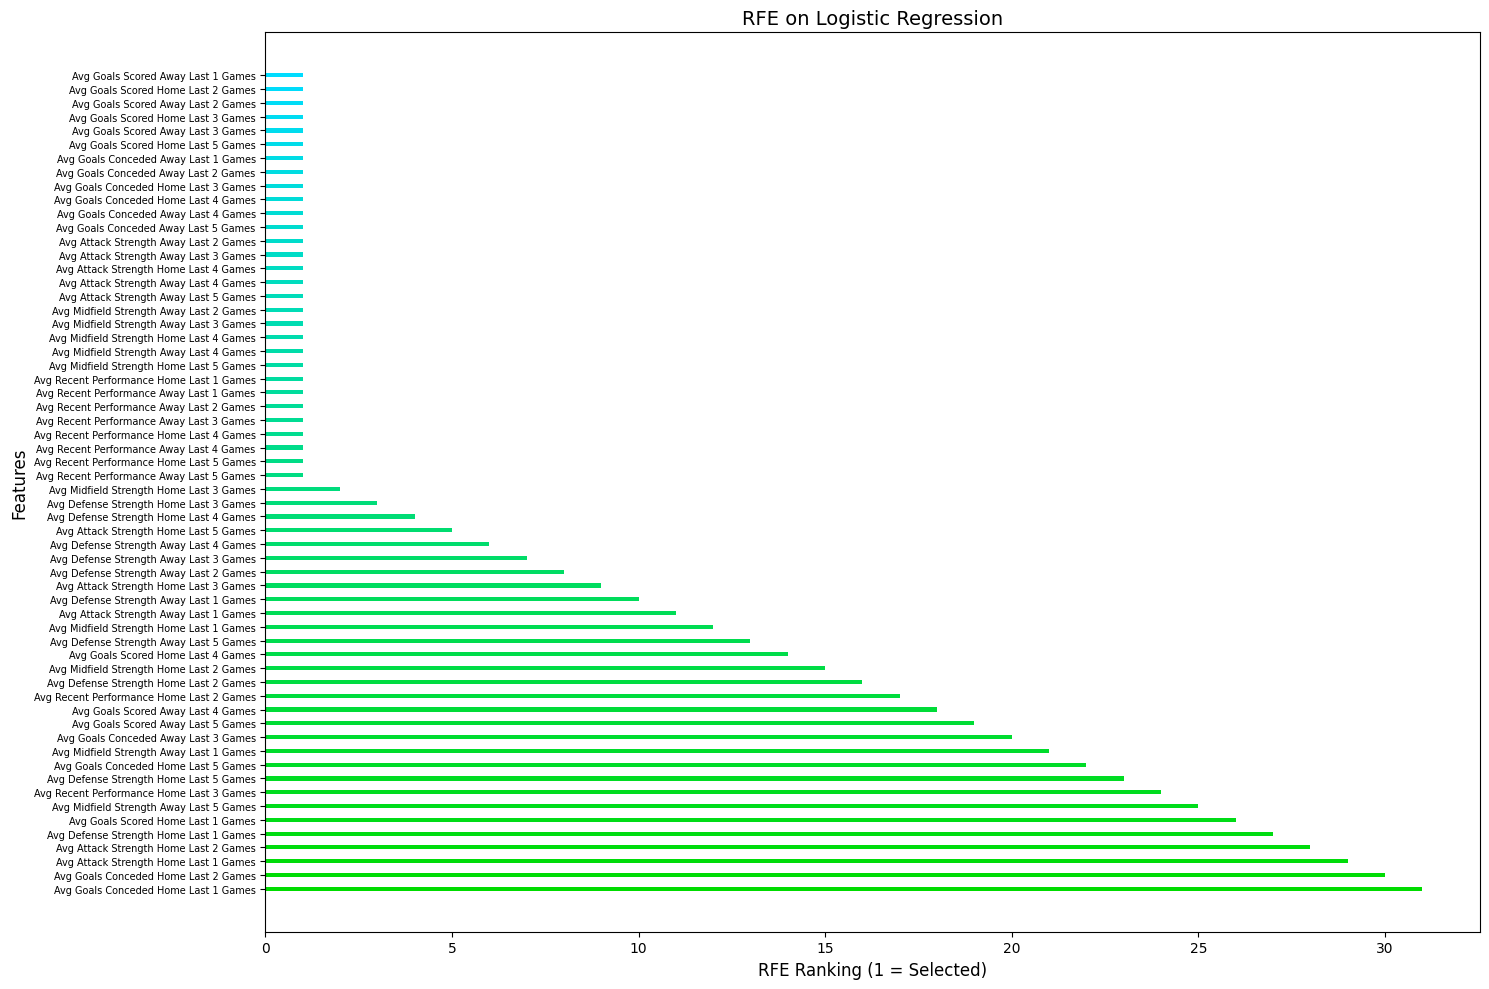

In [93]:
def recursive_feature_elimination_LR(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Match Outcome']
    
    data = standardisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
        
    # perform RFE
    rfe = RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=number_of_components) # taken from PCA
    rfe.fit(data, target)
    
    # get feature rankings and selected features
    feature_ranking = rfe.ranking_
    selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]
    
    # plot feature rankings
    plt.figure(figsize=(15, 10))
    sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
    sorted_names, sorted_ranks = zip(*sorted_features)

    # increase spacing between bars
    y_positions = np.arange(len(sorted_names)) * 2
    bar_height = 0.6

    # generate gradient colors from blue to green
    colors = [(0, 220/255, 1 - alpha) for alpha in np.linspace(0, 1, len(sorted_ranks))]

    # plot horizontal bar chart with gradient colors
    for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
        plt.barh(ypos, rank, height=bar_height, color=color)

    plt.yticks(y_positions, sorted_names, fontsize=7)
    plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title("RFE on Logistic Regression", fontsize=14)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show() 
    
    return selected_features
            
    

logistic_features = recursive_feature_elimination_LR(df)

For K Nearest Neighbours, we implemented Variance Thresholding followed by Mutual Information. 

Variance Minimum:  0.013576172443849375  ---->  Variance Maximum:  0.19291592322287476


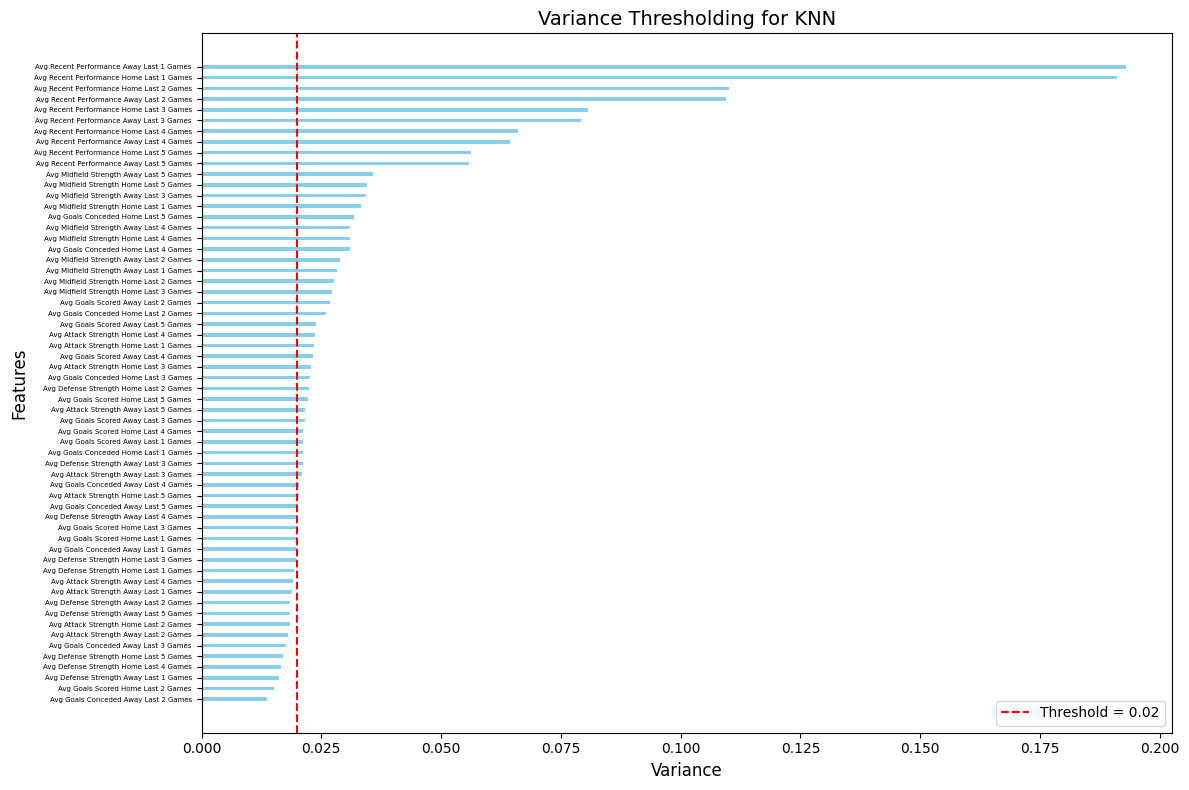

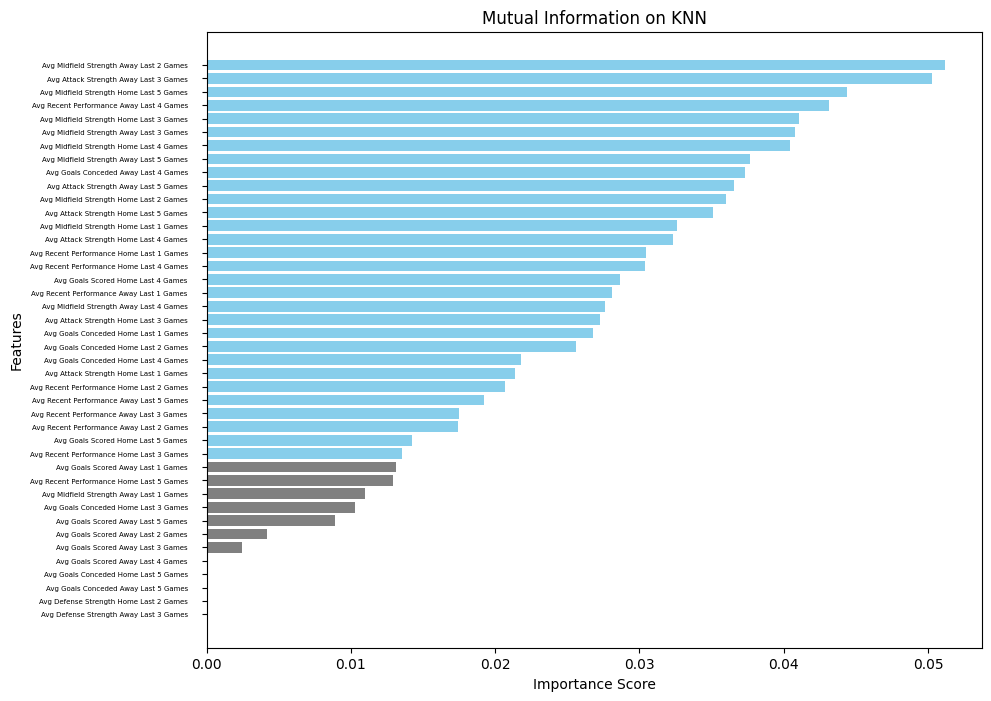

In [94]:
def knn_feature_selection(df):
    
    # first step is calculating minimal variance features
    def variance_thresholding(data, threshold=0.02):
        variances = data.var()
        print("Variance Minimum: ", variances.min(), " ---->  Variance Maximum: ", variances.max())
    
        # filter features based on the threshold
        retained_features = variances[variances >= threshold].index
        reduced_data = data[retained_features]
        sorted_variances = variances.sort_values(ascending=False)

        # plot horizontal bar graph for feature variances
        plt.figure(figsize=(12, 8))
        y_positions = np.arange(len(sorted_variances)) * 3  # increase spacing between bars
        plt.barh(y_positions, sorted_variances, color='skyblue', height=1.0)
        plt.gca().invert_yaxis()
        
        # add a threshold line
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
        
        plt.yticks(y_positions, sorted_variances.index, fontsize=5)
        plt.xlabel('Variance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title('Variance Thresholding for KNN', fontsize=14)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
        

        # print removed features and their variances
        removed_features = sorted_variances[sorted_variances < threshold]

        return reduced_data
    
    # second step is mutual information between features and target
    def mutual_info(data, target):
        # apply information gain
        gain = mutual_info_regression(data, target)

        # dictionary of feature importance scores
        feature_names = list(data.columns)
        scores = {}
        for i in range(len(feature_names)):
            scores[feature_names[i]] = gain[i]

        # descending sort by importance score
        sorted_features = sorted(scores.items(), key=lambda x:x[1], reverse=True)

#         print("\nMutual Information Importance Score: ")
#         print("------------------------------------\n")
#         for feature, score in sorted_features:
#             print(f"{feature + ' score:':55}\t{score:.16f}")

        # plot a bar chat of feature importance scores
        fig, ax = plt.subplots(figsize=(10, 8))
        y_pos = np.arange(len(sorted_features))
        colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(sorted_features))]
        ax.barh(y_pos, [score for feature, score in sorted_features], align="center", color=colours)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([feature for feature, score in sorted_features])
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_xlabel("Importance Score")
        ax.set_ylabel("Features")
        ax.set_title("Mutual Information on KNN")
        ax.tick_params(axis="y", pad=10, labelsize=5)
        plt.show()
        
        # returns most important features
        selected_features = [feature for feature, _ in sorted_features[:number_of_components]]
 
        return selected_features
        
    
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    
    # normalise the data to put all the variances on the same scale
    # otherwise the difference between variances would be 0.0558 to 8728992.4427
    data = normalisation(data, terms=list(data.columns))
    
    variance_data = variance_thresholding(data)
    
    # use label encoding on the target data, keep it discrete
    target = df['Match Outcome']
    target = label_encoding(target, dataframe=False)
    
    return mutual_info(variance_data, target)
    

knn_features = knn_feature_selection(df)

Next is Recursive Feature Engineering for SVM. It will be a repeat of the first selection function, this time using a SVM model for feature selection. Once again, embedded selection methods are implemented in Model Training.

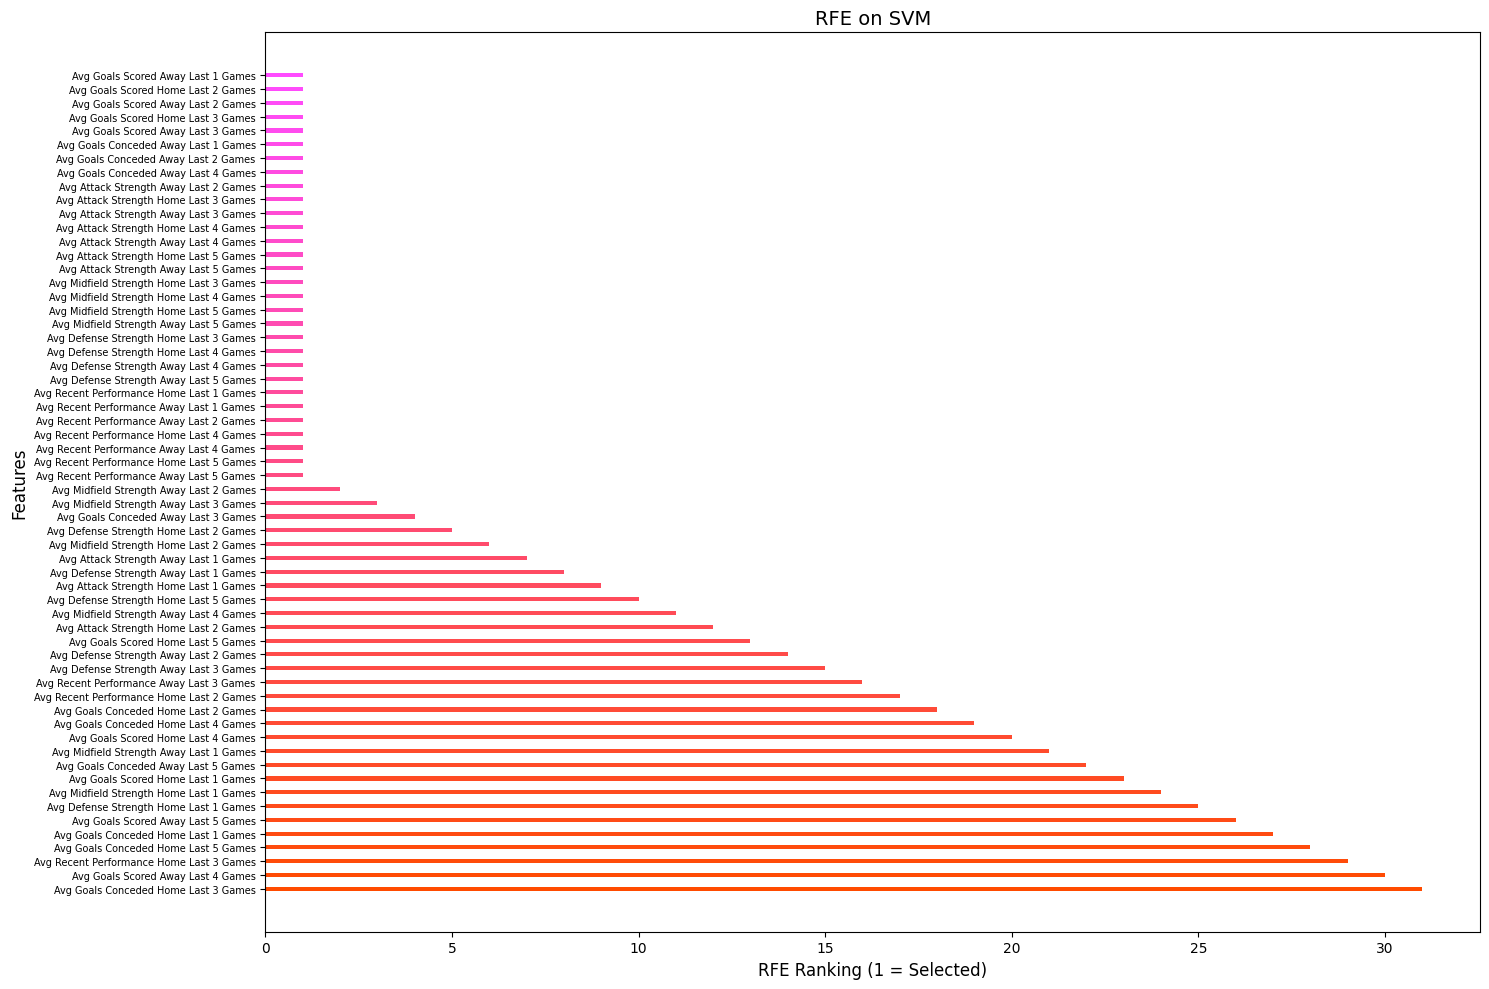

In [95]:
def recursive_feature_elimination_svm(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Match Outcome']
    
    data = standardisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
        
    # perform RFE
    rfe = RFE(estimator=SVC(kernel="linear"), n_features_to_select=number_of_components) # taken from PCA
    rfe.fit(data, target)
    
    # get feature rankings and selected features
    feature_ranking = rfe.ranking_
    selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]
    
    # plot feature rankings
    plt.figure(figsize=(15, 10))
    sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
    sorted_names, sorted_ranks = zip(*sorted_features)

    # increase spacing between bars
    y_positions = np.arange(len(sorted_names)) * 2
    bar_height = 0.6

    # generate gradient colors from blue to green
    colors = [(1, 75/255, 1 - alpha) for alpha in np.linspace(0, 1, len(sorted_ranks))]

    # plot horizontal bar chart with gradient colors
    for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
        plt.barh(ypos, rank, height=bar_height, color=color)

    plt.yticks(y_positions, sorted_names, fontsize=7)
    plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title("RFE on SVM", fontsize=14)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return selected_features
            
    
svm_features = recursive_feature_elimination_svm(df)

Below is the manual feature selection method for LSTM: Mutual Information and then Tree-based RFE. Once again, the embedded methods (l1, l2, l1 & l2, dropout regularisation) are implemented in the Model Training section.

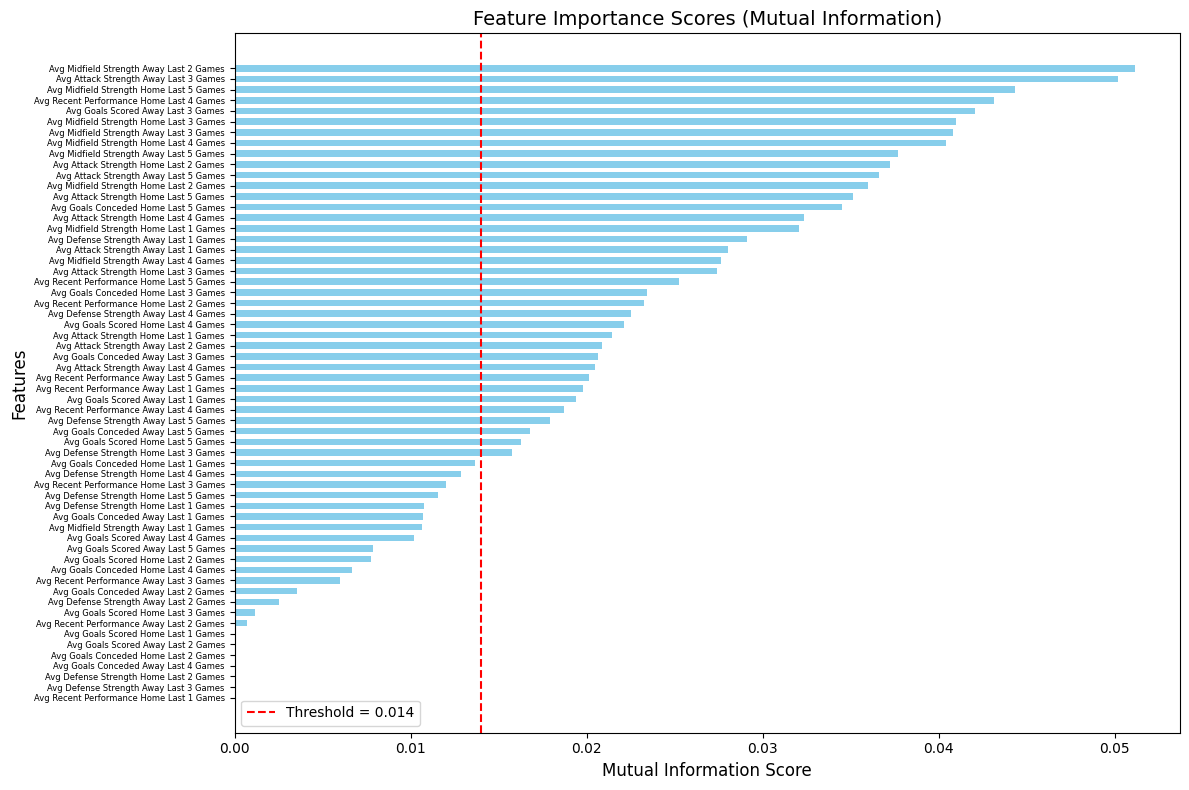


Selected Features based on Mutual Information Threshold: 37 / 60


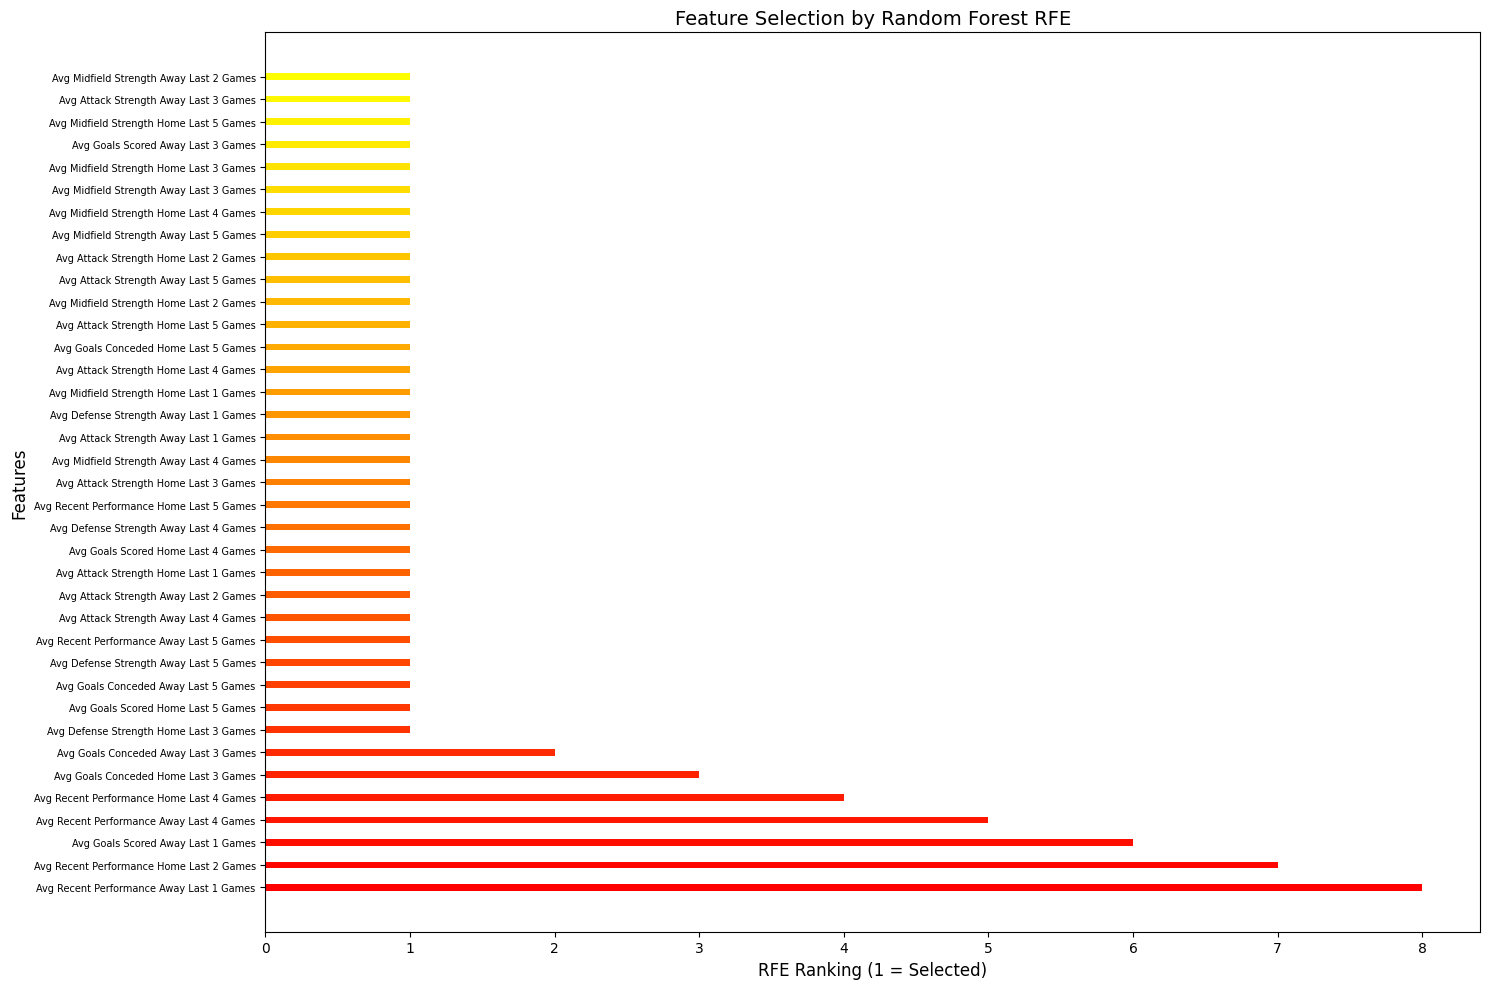

In [96]:
def lstm_feature_selection(df):
    # first applies mutual information and removes the redundant features
    def mutual_info(data, target, threshold=0.014):
        gain = mutual_info_regression(data, target)

        # dictionary of feature importance scores
        feature_names = list(data.columns)
        scores = {}
        for i in range(len(feature_names)):
            scores[feature_names[i]] = gain[i]

        # sort features by importance score in descending order
        sorted_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        # plot a bar chart of feature importance scores
        fig, ax = plt.subplots(figsize=(12, 8))
        y_pos = np.arange(len(sorted_features))
        ax.barh(y_pos, [score for _, score in sorted_features], align="center", color="skyblue", height=0.6)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([feature for feature, _ in sorted_features], fontsize=6)
        ax.invert_yaxis()
        ax.set_xlabel("Mutual Information Score", fontsize=12)
        ax.set_ylabel("Features", fontsize=12)
        ax.set_title("Feature Importance Scores (Mutual Information)", fontsize=14)
        plt.axvline(x=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # filter features based on the threshold
        selected_features = [feature for feature, score in sorted_features if score >= threshold]
        print("\nSelected Features based on Mutual Information Threshold:", len(selected_features), "/", len(data.columns))

        return data[selected_features].copy()
    
    # perform tree based RFE on the remaining features
    def recursive_feature_elimination_RF(data, target):
        data = standardisation(data, terms=list(data.columns))

        # collect the feature names
        feature_names = list(data.columns)

        # perform RFE
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=number_of_components) # taken from PCA
        rfe.fit(data, target)

        # get feature rankings and selected features
        feature_ranking = rfe.ranking_
        selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]

        # plot feature rankings
        plt.figure(figsize=(15, 10))
        sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
        sorted_names, sorted_ranks = zip(*sorted_features)

        # increase spacing between bars
        y_positions = np.arange(len(sorted_names)) * 2
        bar_height = 0.6

        # generate gradient colors from blue to green
        colors = [(1, 1 - alpha, 0) for alpha in np.linspace(0, 1, len(sorted_ranks))]

        # plot horizontal bar chart with gradient colors
        for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
            plt.barh(ypos, rank, height=bar_height, color=color)

        plt.yticks(y_positions, sorted_names, fontsize=7)
        plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.title("Feature Selection by Random Forest RFE", fontsize=14)

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show() 

        return selected_features
    
    
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    
    # use label encoding on the target data, keep it discrete
    target = df['Match Outcome']
    target = label_encoding(target, dataframe=False)
    
    reduced_data = mutual_info(data, target)
    
    return recursive_feature_elimination_RF(reduced_data, target)


    
lstm_features = lstm_feature_selection(df)

Finally, we perform feature selection for Random Forest- we consider Variance Threshold, ANOVA F-value, and Mutual information.
    
Variance Threshold removes features with near-zero variance because RF performs poorly with constant or near-constant features - threshold of 0.01 removes features that are almost constant
    
ANOVA F-value measures the linear relationship between features and the target which is particularly useful for RF as it helps identify features that can be used for clean splits
    
Mutual Information - Captures both linear and non-linear relationships and complements F-test by finding non-linear patterns. Important for RF as it can utilize non-linear relationships in tree splits

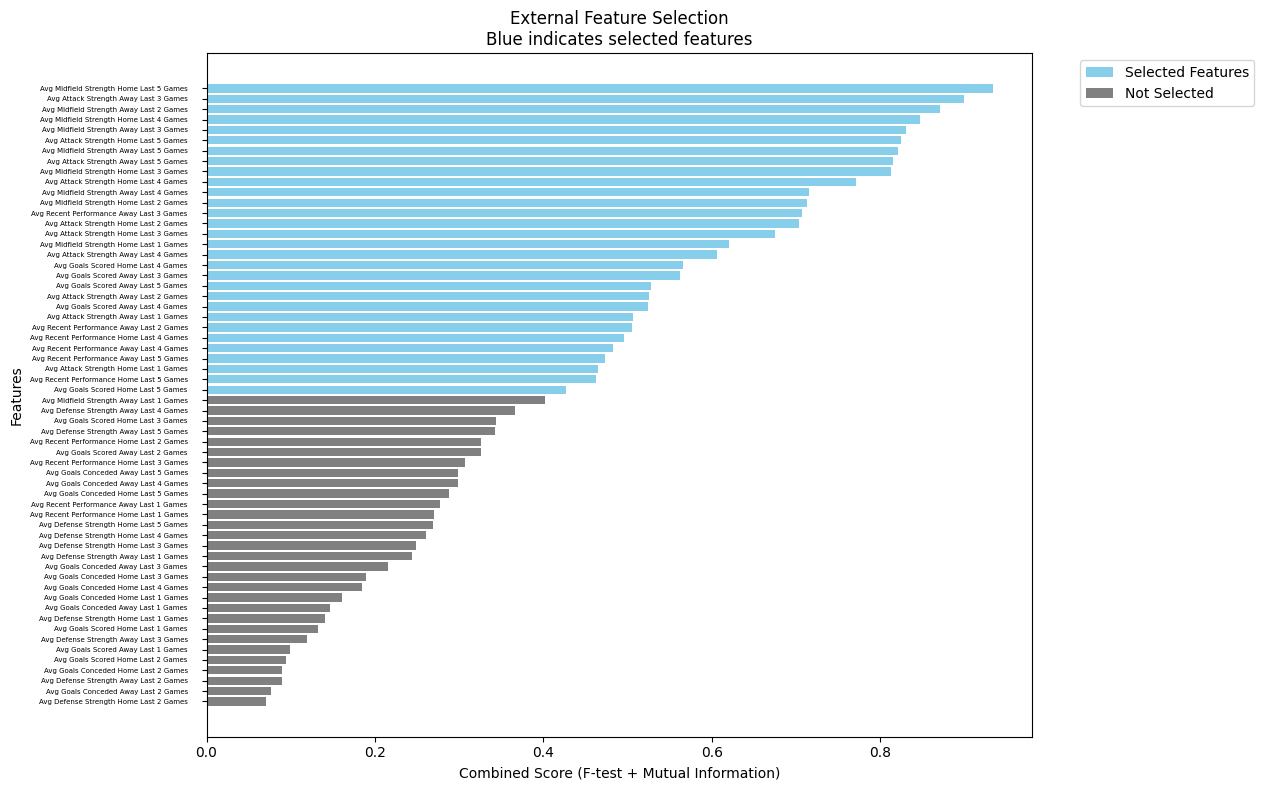

In [97]:
def random_forest_external_selection(df):
    from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
    from sklearn.feature_selection import VarianceThreshold
    
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team'] 
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Match Outcome'] 
    feature_names = list(data.columns)
    
    # 1. Variance Threshold
    selector_variance = VarianceThreshold(threshold=0.01)  # Remove features with low variance
    data_variance = selector_variance.fit_transform(data)
    variance_mask = selector_variance.get_support()
    
    # 2. ANOVA F-value
    selector_f = SelectKBest(score_func=f_classif, k=number_of_components)
    selector_f.fit(data, target)
    f_scores = selector_f.scores_
    
    # 3. Mutual Information
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=number_of_components)
    selector_mi.fit(data, target)
    mi_scores = selector_mi.scores_
    
    # Combine results into DataFrame
    feature_scores = pd.DataFrame({
        'Feature': feature_names,
        'Variance_Selected': variance_mask,
        'F_Score': f_scores,
        'MI_Score': mi_scores
    })
    
    # Normalize F and MI scores to 0-1 range
    feature_scores['F_Score_Norm'] = (feature_scores['F_Score'] - feature_scores['F_Score'].min()) / \
                                   (feature_scores['F_Score'].max() - feature_scores['F_Score'].min())
    feature_scores['MI_Score_Norm'] = (feature_scores['MI_Score'] - feature_scores['MI_Score'].min()) / \
                                    (feature_scores['MI_Score'].max() - feature_scores['MI_Score'].min())
    
    # Calculate combined score
    feature_scores['Combined_Score'] = (feature_scores['F_Score_Norm'] + 
                                      feature_scores['MI_Score_Norm']) / 2
    
    # Sort by combined score
    feature_scores = feature_scores.sort_values('Combined_Score', ascending=False)
    
    # Select features that pass variance threshold and have highest combined scores
    final_selected = feature_scores[feature_scores['Variance_Selected']]\
        .head(number_of_components)['Feature'].tolist()
    
    plt.figure(figsize=(12, 8))
    
    colors = ['skyblue' if feature in final_selected else 'gray' 
             for feature in feature_scores['Feature']]
    
    plt.barh(feature_scores['Feature'], 
            feature_scores['Combined_Score'],
            color=colors)
    
    plt.xlabel('Combined Score (F-test + Mutual Information)')
    plt.ylabel('Features')
    plt.title('External Feature Selection\nBlue indicates selected features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', label='Selected Features'),
        Patch(facecolor='gray', label='Not Selected')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

    return final_selected

rf_features = random_forest_external_selection(df)

## Training

Moving onto the Training phase, below are a few helper methods for the model testing phase.

In [98]:
def chronological_split(df, train_ratio=0.8, chronological=False):
    df = df.sort_values(by='Date')
    df.drop(columns=['Date'], inplace=True)
    df.dropna(inplace=True)
    if chronological:
        train_size = int(len(df) * train_ratio)
        train_df = df[:train_size]
        test_df = df[train_size:]
    else:
        train_df, test_df = train_test_split(df, train_size=train_ratio, random_state=31, shuffle=True)
    return train_df, test_df

def encode_teams(df, encoding="one-hot"):
    if encoding == "one-hot":
        encoder = OneHotEncoder()
        encoded_teams = encoder.fit_transform(df[['Home Team']]).toarray()
        encoded_team_columns = encoder.get_feature_names_out(['Home Team'])
        
        encoded_df = pd.DataFrame(encoded_teams, columns=encoded_team_columns, index=df.index)
        df = pd.concat([df, encoded_df], axis=1)
        return df.drop(['Home Team'], axis=1)
    else:
        teams = df['Home Team'].unique()        
        encoder = LabelEncoder()
        encoder.fit(teams)
        
        df['Home Team'] = encoder.transform(df['Home Team'])
        
        return df

The RecencyModelTrainingNew class contains all the methods to train LR, KNN, SVM, LSTM, RF models and their regularised versions. The class also contains methods to analyse models and plot their graphs. 

In [99]:
class RecencyModelTrainingNew:
    def __init__(self):
        pass

    
    # logistic regression model
    def train_with_iterations(self, X_train, y_train, X_test, y_test, iterations):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for max_iter in iterations:
            model = LogisticRegression(
                multi_class='multinomial', solver='lbfgs', max_iter=max_iter,
                random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics
    
    
    # logistic regression model with LASSO regression - regularisation strength C
    def train_with_iterations_l1(self, X_train, y_train, X_test, y_test, iterations, C=1.0):        
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        feature_names = list(X_train.columns)
        selected_features = []

        for max_iter in iterations:
            model = LogisticRegression(
                penalty='l1', solver='liblinear', max_iter=max_iter, C=C, random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

            # get selected features (non-zero coefficients)
            non_zero_indices = np.where(model.coef_[0] != 0)[0]
            selected_features = [feature_names[i] for i in non_zero_indices if "Home Team" not in feature_names[i]]
            #print(f"Selected Features (max_iter={max_iter}): {selected_features}\n")

        print(f"Logistic Regression => LASSO Regularisation Selected Features (max_iter={iterations[-1]}): {selected_features}\n")

        return metrics
    
    
    # logistic regression model with Ridge regression - regularisation strength C
    def train_with_iterations_l2(self, X_train, y_train, X_test, y_test, iterations, C=1.0):        
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        feature_names = list(X_train.columns)

        for max_iter in iterations:
            model = LogisticRegression(
                penalty='l2', solver='lbfgs', max_iter=max_iter, C=C, random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        print(f"Logistic Regression => Ridge Regression Selected Features (max_iter={iterations[-1]}): Every feature. Just different weights.")
            
        return metrics
    
    
    #  logistic regression model with Elastic Net regularisation - regularisation strength C
    def train_with_iterations_l1_l2(self, X_train, y_train, X_test, y_test, iterations, C=1.0, l1_ratio=0.5):        
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        feature_names = list(X_train.columns)
        selected_features = []

        for max_iter in iterations:
            model = LogisticRegression(
                penalty='elasticnet', solver='saga', max_iter=max_iter, C=C, 
                l1_ratio=l1_ratio, random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

            # Get selected features (non-zero coefficients)
            non_zero_indices = np.where(model.coef_[0] != 0)[0]
            selected_features = [feature_names[i] for i in non_zero_indices if "Home Team" not in feature_names[i]]
        
        print(f"Logistic Regression => Elastic Net Selected Features (max_iter={iterations[-1]}): {selected_features}\n")
        return metrics

    
    # k nearest neighbours model
    def train_and_evaluate_knn(self, X_train, y_train, X_test, y_test, neighbors_range):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for n_neighbors in neighbors_range:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)

            train_predictions = knn.predict(X_train)
            test_predictions = knn.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics

    
    # support vector machine model
    def train_and_evaluate_svm(self, X_train, y_train, X_test, y_test, C_range=[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for C in C_range:
            svm = SVC(kernel='linear', C=C, random_state=31)
            svm.fit(X_train, y_train)

            train_predictions = svm.predict(X_train)
            test_predictions = svm.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, C_range
    
    
    # support vector model with l1 regression - regularisation strength C
    def train_and_evaluate_svm_l1(self, X_train, y_train, X_test, y_test, C_range=[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for C in C_range:
            svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=31)
            svm.fit(X_train, y_train)

            train_predictions = svm.predict(X_train)
            test_predictions = svm.predict(X_test)

            # print selected features
            feature_names = X_train.columns
            selected_features = [feature_names[i] for i in range(len(feature_names)) if svm.coef_[0, i] != 0 and "Home Team" not in feature_names[i]]
            original_feature_num = len([col for col in list(X_train.columns) if "Home Team" not in col])
            print(f"SVM => Selected Features with L1 Regularization (C={C}): {len(selected_features)}/{original_feature_num}\n\n{selected_features}\n")

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, C_range
    
    
    # support vector model with l2 regression - regularisation strength C
    def train_and_evaluate_svm_l2(self, X_train, y_train, X_test, y_test, C_range=[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for C in C_range:
            # SVM with L2 regularization
            svm = LinearSVC(penalty='l2', dual=True, C=C, random_state=31)
            svm.fit(X_train, y_train)

            train_predictions = svm.predict(X_train)
            test_predictions = svm.predict(X_test)

            print(f"SVM => Selected Features with L2 Regularisation (C={C}): Every feature. Just different weights.")
            
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, C_range


    def train_and_evaluate_lstm(self, X_train, y_train, X_test, y_test, max_epochs=10):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        # Prepare data once
        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)
        X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        lstm_model = Sequential([
            LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
            LSTM(64, return_sequences=False),
            Dense(3, activation='softmax')
        ])
        
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        for _ in range(max_epochs):
            lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=1, batch_size=32, verbose=1)
            train_predictions = lstm_model.predict(X_train_reshaped).argmax(axis=1)
            test_predictions = lstm_model.predict(X_test_reshaped).argmax(axis=1)
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, range(1, max_epochs + 1)

    def train_and_evaluate_lstm_l1(self, X_train, y_train, X_test, y_test, max_epochs=10, l1_penalty=0.01):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)
        X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # L1 regularized LSTM
        lstm_model = Sequential([
            LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), 
                return_sequences=True, kernel_regularizer=regularizers.l1(l1_penalty)),
            LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l1(l1_penalty)),
            Dense(3, activation='softmax')
        ])
        
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        for _ in range(max_epochs):
            lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=1, batch_size=32, verbose=1)
            train_predictions = lstm_model.predict(X_train_reshaped).argmax(axis=1)
            test_predictions = lstm_model.predict(X_test_reshaped).argmax(axis=1)
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, range(1, max_epochs + 1)

    def train_and_evaluate_lstm_l2(self, X_train, y_train, X_test, y_test, max_epochs=10, l2_penalty=0.01):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)
        X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # L2 regularized LSTM
        lstm_model = Sequential([
            LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), 
                return_sequences=True, kernel_regularizer=regularizers.l2(l2_penalty)),
            LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(l2_penalty)),
            Dense(3, activation='softmax')
        ])
        
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        for _ in range(max_epochs):
            lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=1, batch_size=32, verbose=1)
            train_predictions = lstm_model.predict(X_train_reshaped).argmax(axis=1)
            test_predictions = lstm_model.predict(X_test_reshaped).argmax(axis=1)
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, range(1, max_epochs + 1)

    def train_and_evaluate_lstm_l1_l2(self, X_train, y_train, X_test, y_test, max_epochs=10, l1_l2_penalty=0.01):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)
        X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # L1L2 regularized LSTM
        lstm_model = Sequential([
            LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), 
                return_sequences=True, kernel_regularizer=regularizers.l1_l2(l1=l1_l2_penalty, l2=l1_l2_penalty)),
            LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l1_l2(l1=l1_l2_penalty, l2=l1_l2_penalty)),
            Dense(3, activation='softmax')
        ])
        
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        for _ in range(max_epochs):
            lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=1, batch_size=32, verbose=1)
            train_predictions = lstm_model.predict(X_train_reshaped).argmax(axis=1)
            test_predictions = lstm_model.predict(X_test_reshaped).argmax(axis=1)
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, range(1, max_epochs + 1)

    def train_and_evaluate_lstm_dropout(self, X_train, y_train, X_test, y_test, max_epochs=10, dropout_rate=0.2):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)
        X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # Dropout LSTM
        lstm_model = Sequential([
            LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
            Dropout(dropout_rate),
            LSTM(64, return_sequences=False),
            Dropout(dropout_rate),
            Dense(3, activation='softmax')
        ])
        
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train and evaluate
        for _ in range(max_epochs):
            lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=1, batch_size=32, verbose=1)
            train_predictions = lstm_model.predict(X_train_reshaped).argmax(axis=1)
            test_predictions = lstm_model.predict(X_test_reshaped).argmax(axis=1)
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics, range(1, max_epochs + 1)
    

    def train_and_evaluate_rf(self, X_train, y_train, X_test, y_test, n_estimators_range=[10, 50, 100, 150, 200, 250, 300]):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        for n_estimators in n_estimators_range:
            # Basic Random Forest without any feature selection
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=4,
                min_samples_split=50,
                min_samples_leaf=25,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            )
            rf.fit(X_train, y_train)
            
            train_predictions = rf.predict(X_train)
            test_predictions = rf.predict(X_test)
            
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)
        
        return metrics, n_estimators_range
         
        
    def train_and_evaluate_rf_selectfrommodel(self, X_train, y_train, X_test, y_test, n_estimators_range=[10, 50, 100, 150, 200, 250, 300]):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        for n_estimators in n_estimators_range:
            # SelectFromModel Method with regularized RF
            base_rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=4,
                min_samples_split=50,
                min_samples_leaf=25,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            )
            
            selector = SelectFromModel(
                base_rf,
                max_features=number_of_components,
                threshold=-np.inf
            )
            selector.fit(X_train, y_train)
            
            selected_features = X_train.columns[selector.get_support()].tolist()
            print(f"Random Forest => Selected Features with SelectFromModel (n_estimators={n_estimators}): {len(selected_features)}")
            print(selected_features)
            
            # Train and evaluate with selected features
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]
            
            final_rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=4,
                min_samples_split=50,
                min_samples_leaf=25,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            )
            final_rf.fit(X_train_selected, y_train)
            
            train_predictions = final_rf.predict(X_train_selected)
            test_predictions = final_rf.predict(X_test_selected)
            
            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)
        
        return metrics, n_estimators_range
    
    
    def _compute_metrics(self, metrics, train_predictions, test_predictions, y_train, y_test):
        train_accuracy = accuracy_score(y_train, train_predictions)
        test_accuracy = accuracy_score(y_test, test_predictions)

        metrics['train_accuracy'].append(train_accuracy)
        metrics['test_accuracy'].append(test_accuracy)

        metrics['train_rmse'].append(np.sqrt(np.mean((y_train - train_predictions) ** 2)))
        metrics['test_rmse'].append(np.sqrt(np.mean((y_test - test_predictions) ** 2)))

        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            y_train, train_predictions, average='weighted'
        )
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            y_test, test_predictions, average='weighted'
        )

        metrics['train_precision'].append(train_precision)
        metrics['test_precision'].append(test_precision)
        metrics['train_recall'].append(train_recall)
        metrics['test_recall'].append(test_recall)
        metrics['train_f1'].append(train_f1)
        metrics['test_f1'].append(test_f1)

        
    def plot_metrics(self, metrics, model_name, param_values=None, param_name="Parameter Value"):
        metric_keys = list(metrics.keys())
        n_metrics = len(metric_keys)

        plt.figure(figsize=(15, 10))
        for i, key in enumerate(metric_keys, 1):
            plt.subplot((n_metrics + 1) // 2, 2, i)

            # Print the metric data for debugging
            print(f"Plotting Metric: {key}")
            print(f"Metric Data: {metrics[key]}")
            
            if param_values is not None:
                print(f"Parameter Values: {param_values}")
                # Ensure that param_values and metrics match in length
                if len(metrics[key]) != len(param_values):
                    print(f"Warning: Length mismatch between param_values and {key} metric")
                plt.plot(param_values, metrics[key], label=key, marker='o')
                x_vals = param_values
            else:
                plt.plot(metrics[key], label=key, marker='o')
                x_vals = range(len(metrics[key]))

            # Check if there are multiple values to plot
            if len(x_vals) > 1:
                for x, y in zip(x_vals, metrics[key]):
                    plt.text(x, y, f'{y:.2f}', fontsize=8, ha='center', va='bottom')
            else:
                print(f"Warning: Only one data point for {key}. This may indicate an issue with data collection.")

            plt.xlabel(param_name)
            plt.ylabel(f'{key}')
            plt.title(f'{model_name} - {key} over {param_name}')
            plt.grid()

        plt.tight_layout()
        plt.show()
        
        
    def save_model(self, filename):
        joblib.dump(self.model, filename)

        
    def load_model(self, filename):
        self.model = joblib.load(filename)


## Baseline Recency Model Training

The first model training, focused solely on recency features.

In [100]:
first_df = encode_teams(df)
numerical_features = [col for col in first_df.columns if 'Avg' in col]
first_df = standardisation(first_df, numerical_features)

first_train_df, first_test_df = chronological_split(first_df)

first_X_train, first_y_train = first_train_df.drop('Match Outcome', axis=1), first_train_df['Match Outcome']
first_X_test, first_y_test = first_test_df.drop('Match Outcome', axis=1), first_test_df['Match Outcome']

In [101]:
# Model Training
print('Starting Training...')
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
n_estimators_range = [10, 50, 100, 150, 200, 250, 300]
metrics_logistic = trainer.train_with_iterations(first_X_train, first_y_train, first_X_test, first_y_test, iterations)
metrics_knn = trainer.train_and_evaluate_knn(first_X_train, first_y_train, first_X_test, first_y_test, neighbors_range)
metrics_svm = trainer.train_and_evaluate_svm(first_X_train, first_y_train, first_X_test, first_y_test)
metrics_lstm = trainer.train_and_evaluate_lstm(first_X_train, first_y_train, first_X_test, first_y_test)
metrics_rf = trainer.train_and_evaluate_rf(first_X_train, first_y_train, first_X_test, first_y_test, n_estimators_range)

print('Finished Training.')

Starting Training...
17/17 [==============================] - 0s 4ms/step
Finished Training.


## Feature Selection Model Training

These models will be trained with datasets created from our previous manual feature selection methods. Each of the five models used a specific selection method that corresponded well with the model type. 

In [102]:
missing_features = ['Home Team', 'Match Outcome', 'Date'] # removed during feature selection

logistic_df = df[missing_features + logistic_features]
knn_df = df[missing_features + knn_features]
svm_df = df[missing_features + svm_features]
lstm_df = df[missing_features + lstm_features]
rf_df = df[missing_features + rf_features]

In [103]:
print('Preprocessing Data...')

# encoding and standardising for each of the four feature sets
logistic_df = encode_teams(logistic_df)
knn_df = encode_teams(knn_df)
svm_df = encode_teams(svm_df)
lstm_df = encode_teams(lstm_df)
rf_df = encode_teams(rf_df)


logistic_df = standardisation(logistic_df, logistic_features)
knn_df = standardisation(knn_df, knn_features)
svm_df = standardisation(svm_df, svm_features)
lstm_df = standardisation(lstm_df, lstm_features)
rf_df = standardisation(rf_df, rf_features)

# split the data into X (data) and y (target) for training and testing
logistic_train_df, logistic_test_df = chronological_split(logistic_df)
knn_train_df, knn_test_df = chronological_split(knn_df)
svm_train_df, svm_test_df = chronological_split(svm_df)
lstm_train_df, lstm_test_df = chronological_split(lstm_df)
rf_train_df, rf_test_df = chronological_split(rf_df)

logistic_X_train, logistic_y_train = logistic_train_df.drop('Match Outcome', axis=1), logistic_train_df['Match Outcome']
logistic_X_test, logistic_y_test = logistic_test_df.drop('Match Outcome', axis=1), logistic_test_df['Match Outcome']

knn_X_train, knn_y_train = knn_train_df.drop('Match Outcome', axis=1), knn_train_df['Match Outcome']
knn_X_test, knn_y_test = knn_test_df.drop('Match Outcome', axis=1), knn_test_df['Match Outcome']

svm_X_train, svm_y_train = svm_train_df.drop('Match Outcome', axis=1), svm_train_df['Match Outcome']
svm_X_test, svm_y_test = svm_test_df.drop('Match Outcome', axis=1), svm_test_df['Match Outcome']

lstm_X_train, lstm_y_train = lstm_train_df.drop('Match Outcome', axis=1), lstm_train_df['Match Outcome']
lstm_X_test, lstm_y_test = lstm_test_df.drop('Match Outcome', axis=1), lstm_test_df['Match Outcome']

rf_X_train, rf_y_train = rf_train_df.drop('Match Outcome', axis=1), rf_train_df['Match Outcome']
rf_X_test, rf_y_test = rf_test_df.drop('Match Outcome', axis=1), rf_test_df['Match Outcome']

Preprocessing Data...


In [104]:
# Model Training
print('Starting Training...')
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
n_estimators_range = [10, 50, 100, 150, 200, 250, 300]

metrics_logistic2 = trainer.train_with_iterations(logistic_X_train, logistic_y_train, logistic_X_test, logistic_y_test, iterations)
metrics_knn2 = trainer.train_and_evaluate_knn(knn_X_train, knn_y_train, knn_X_test, knn_y_test, neighbors_range)
metrics_svm2 = trainer.train_and_evaluate_svm(svm_X_train, svm_y_train, svm_X_test, svm_y_test)
metrics_lstm2 = trainer.train_and_evaluate_lstm(lstm_X_train, lstm_y_train, lstm_X_test, lstm_y_test)
metrics_rf2 = trainer.train_and_evaluate_rf(logistic_X_train, logistic_y_train, logistic_X_test, logistic_y_test, n_estimators_range)

print('Finished Training.')

Starting Training...
17/17 [==============================] - 0s 3ms/step
Finished Training.


## Embedded Feature Selection Model Training

In the following selection, we will focus on embedded feature selection methods. For the Logistic Regression model, we will use the entire recency data set and try out LASSO regression, Ridge regression, and Elastic Net regularisation to see which technique fairs best.

The KNN model does not support any traditional regularisation techniques as it is non-parametric. It is possible to indirectly apply regularisation-like effects to the model. However, we will not be looking at these indirect methods. 

SVM models, on the other hand, do support traditional regularisation techniques. We will implement L1 and L2 regression. Elastic Net regularisation is not very commonly used and will not be tested.

Similarly, LSTM models allow L1 and L2 regression techniques that control the weights of the model. Furthermore, we will implemented drop out regularisation - where a fraction of the neurons are randomly removed to prevent highly correlated units.  

For RF, we will use an L1-like regression technique.

In [105]:
print('Preprocessing Data...')


full_df = encode_teams(df)
full_df = standardisation(full_df, numerical_features)

full_train_df, full_test_df = chronological_split(full_df)

full_X_train, full_y_train = full_train_df.drop('Match Outcome', axis=1), full_train_df['Match Outcome']
full_X_test, full_y_test = full_test_df.drop('Match Outcome', axis=1), full_test_df['Match Outcome']

Preprocessing Data...


In [106]:
# Model Training
print('Starting Training...')
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]

metrics_logistic_l1 = trainer.train_with_iterations_l1(full_X_train, full_y_train, full_X_test, full_y_test, iterations)
metrics_logistic_l2 = trainer.train_with_iterations_l2(full_X_train, full_y_train, full_X_test, full_y_test, iterations)
metrics_logistic_l1_l2 = trainer.train_with_iterations_l1_l2(full_X_train, full_y_train, full_X_test, full_y_test, iterations, l1_ratio=0.5)

metrics_svm_l1 = trainer.train_and_evaluate_svm_l1(full_X_train, full_y_train, full_X_test, full_y_test)
metrics_svm_l2 = trainer.train_and_evaluate_svm_l2(full_X_train, full_y_train, full_X_test, full_y_test)

metrics_lstm_l1 = trainer.train_and_evaluate_lstm_l1(full_X_train, full_y_train, full_X_test, full_y_test)
metrics_lstm_l2 = trainer.train_and_evaluate_lstm_l2(full_X_train, full_y_train, full_X_test, full_y_test)
metrics_lstm_l1_l2 = trainer.train_and_evaluate_lstm_l1_l2(full_X_train, full_y_train, full_X_test, full_y_test)
metrics_lstm_dropout = trainer.train_and_evaluate_lstm_dropout(full_X_train, full_y_train, full_X_test, full_y_test)

metrics_rf_l1 = trainer.train_and_evaluate_rf_selectfrommodel(full_X_train, full_y_train, full_X_test, full_y_test)    # SelectFromModel (L1-like)

print('Finished Training.')

Starting Training...
Logistic Regression => LASSO Regularisation Selected Features (max_iter=190): ['Avg Goals Scored Home Last 1 Games', 'Avg Goals Scored Away Last 1 Games', 'Avg Goals Scored Home Last 2 Games', 'Avg Goals Scored Away Last 2 Games', 'Avg Goals Scored Home Last 3 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Goals Scored Home Last 4 Games', 'Avg Goals Scored Away Last 5 Games', 'Avg Goals Conceded Away Last 1 Games', 'Avg Goals Conceded Home Last 2 Games', 'Avg Goals Conceded Away Last 2 Games', 'Avg Goals Conceded Home Last 3 Games', 'Avg Goals Conceded Away Last 3 Games', 'Avg Goals Conceded Home Last 4 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Goals Conceded Home Last 5 Games', 'Avg Attack Strength Home Last 1 Games', 'Avg Attack Strength Away Last 1 Games', 'Avg Attack Strength Home Last 2 Games', 'Avg Attack Strength Away Last 2 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Attack Strength Away Last 4 Games', 'Avg Attack Strength Away Last

# Results

Here, we compare the different models:

## Baseline Recency Model Testing

Plotting Metric: train_accuracy
Metric Data: [0.5164473684210527, 0.5526315789473685, 0.5568609022556391, 0.5620300751879699, 0.5629699248120301, 0.5653195488721805, 0.5667293233082706, 0.5667293233082706, 0.5653195488721805, 0.5657894736842105, 0.5671992481203008, 0.5653195488721805, 0.5657894736842105, 0.5643796992481203, 0.5648496240601504, 0.5657894736842105, 0.5653195488721805, 0.5653195488721805, 0.5653195488721805, 0.5653195488721805]
Parameter Values: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
Plotting Metric: test_accuracy
Metric Data: [0.5263157894736842, 0.5169172932330827, 0.5112781954887218, 0.5225563909774437, 0.5244360902255639, 0.5394736842105263, 0.5263157894736842, 0.5244360902255639, 0.5263157894736842, 0.5244360902255639, 0.5263157894736842, 0.5300751879699248, 0.5300751879699248, 0.5300751879699248, 0.5263157894736842, 0.5281954887218046, 0.5281954887218046, 0.5281954887218046, 0.5281954887218046, 0.5281954887218046]
Paramete

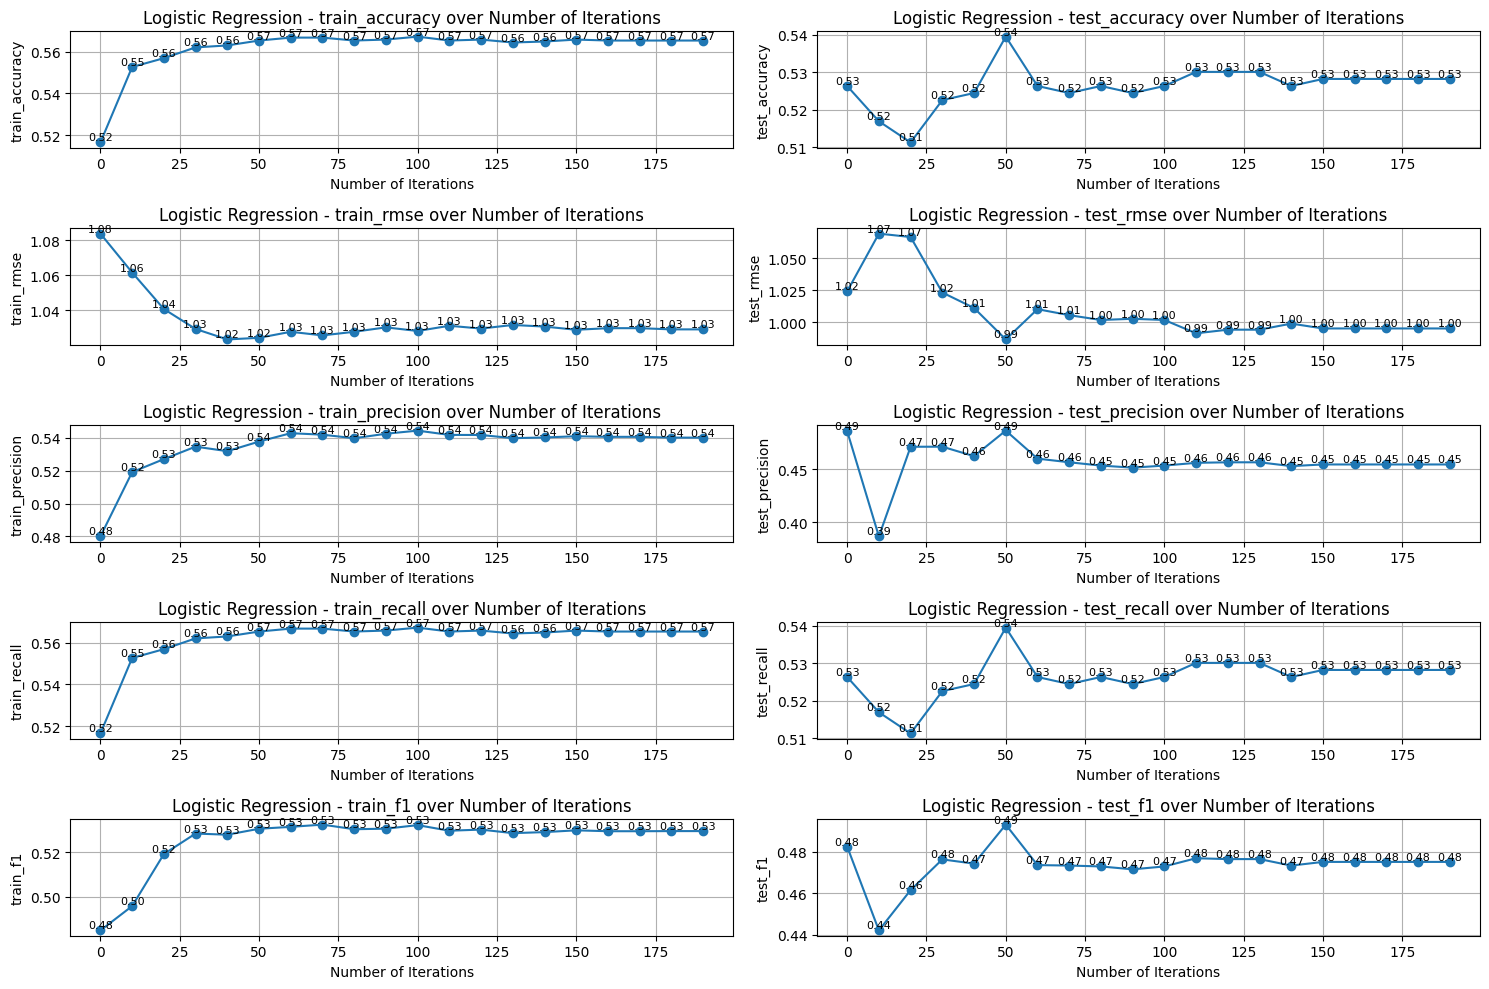

Plotting Metric: train_accuracy
Metric Data: [1.0, 0.6898496240601504, 0.6245300751879699, 0.6118421052631579, 0.5836466165413534, 0.5775375939849624, 0.5634398496240601, 0.5479323308270677, 0.5512218045112782, 0.5451127819548872, 0.5484022556390977, 0.5394736842105263, 0.5427631578947368, 0.543233082706767, 0.537124060150376, 0.5385338345864662, 0.537124060150376, 0.5418233082706767, 0.5361842105263158, 0.5357142857142857, 0.5310150375939849, 0.5390037593984962, 0.5338345864661654, 0.5324248120300752, 0.5361842105263158, 0.5338345864661654]
Parameter Values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
Plotting Metric: test_accuracy
Metric Data: [0.4116541353383459, 0.42857142857142855, 0.4342105263157895, 0.4567669172932331, 0.44360902255639095, 0.4774436090225564, 0.49624060150375937, 0.5075187969924813, 0.5037593984962406, 0.5037593984962406, 0.5075187969924813, 0.4981203007518797, 0.4924812030075188, 0.49624060150375937, 0.501

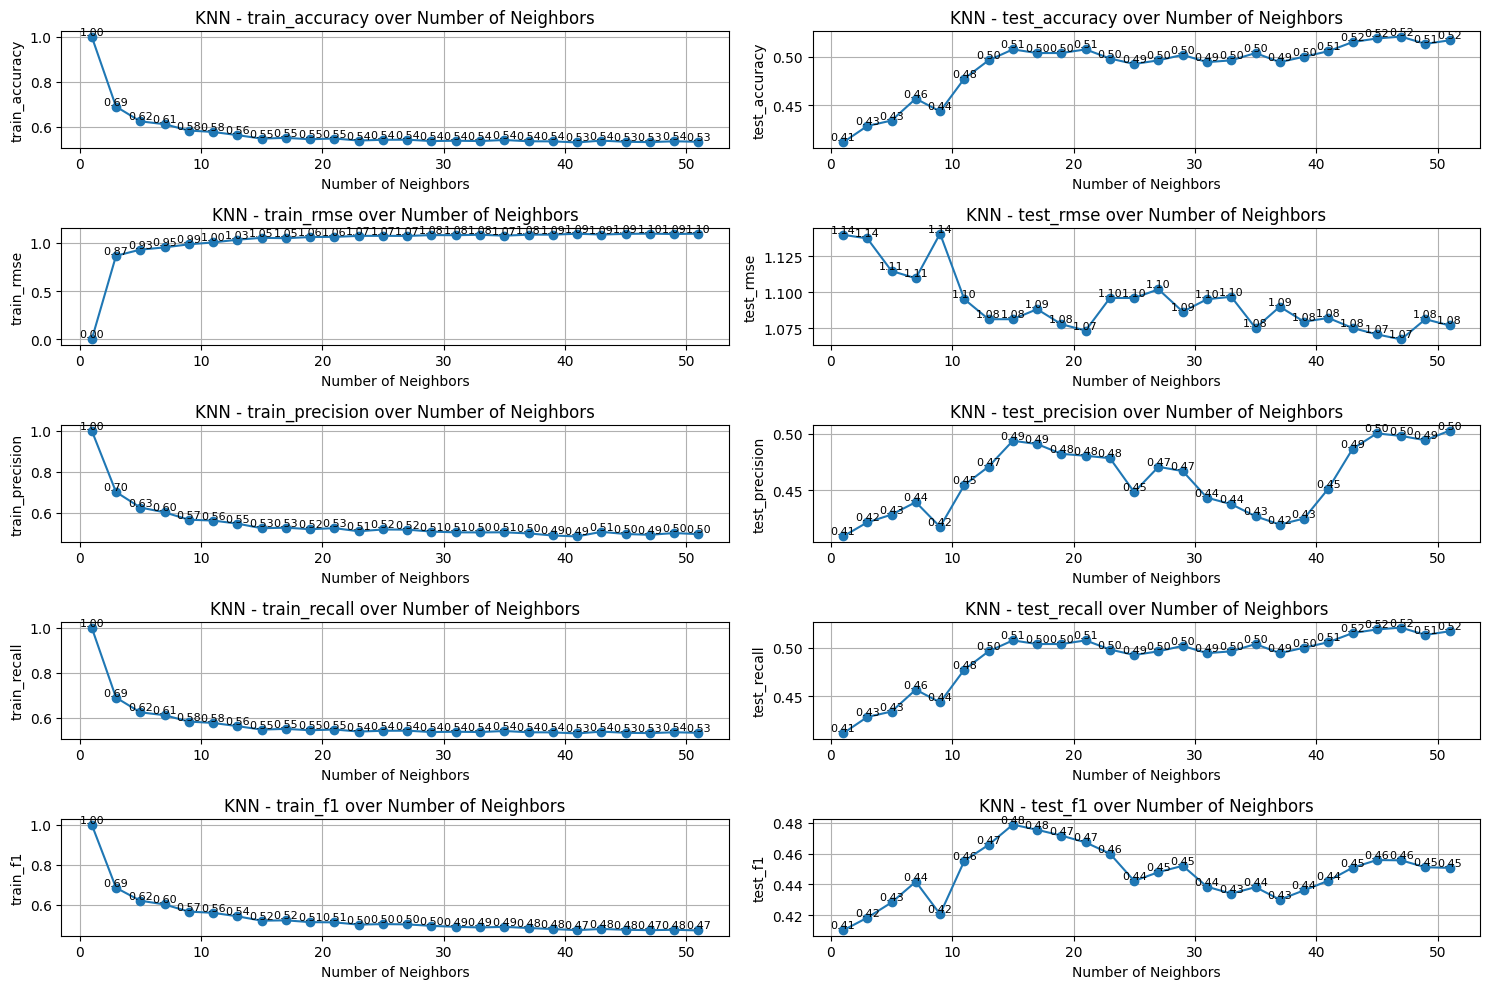

Plotting Metric: train_accuracy
Metric Data: [0.5549812030075187, 0.5718984962406015, 0.5728383458646616, 0.5709586466165414, 0.5718984962406015, 0.5681390977443609]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_accuracy
Metric Data: [0.5300751879699248, 0.5357142857142857, 0.5357142857142857, 0.5338345864661654, 0.5338345864661654, 0.5357142857142857]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_rmse
Metric Data: [1.0624308911624514, 1.0280374031403912, 1.0268939955981282, 1.0257493134949387, 1.0239151603717458, 1.031232199664101]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_rmse
Metric Data: [1.0548848064538696, 1.027808823392565, 1.036005922124334, 1.0287228376446833, 1.0287228376446833, 1.025061890667704]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_precision
Metric Data: [0.4316706483523363, 0.5539601018675722, 0.555954224959914, 0.5486362908730176, 0.5495159326751052, 0.54

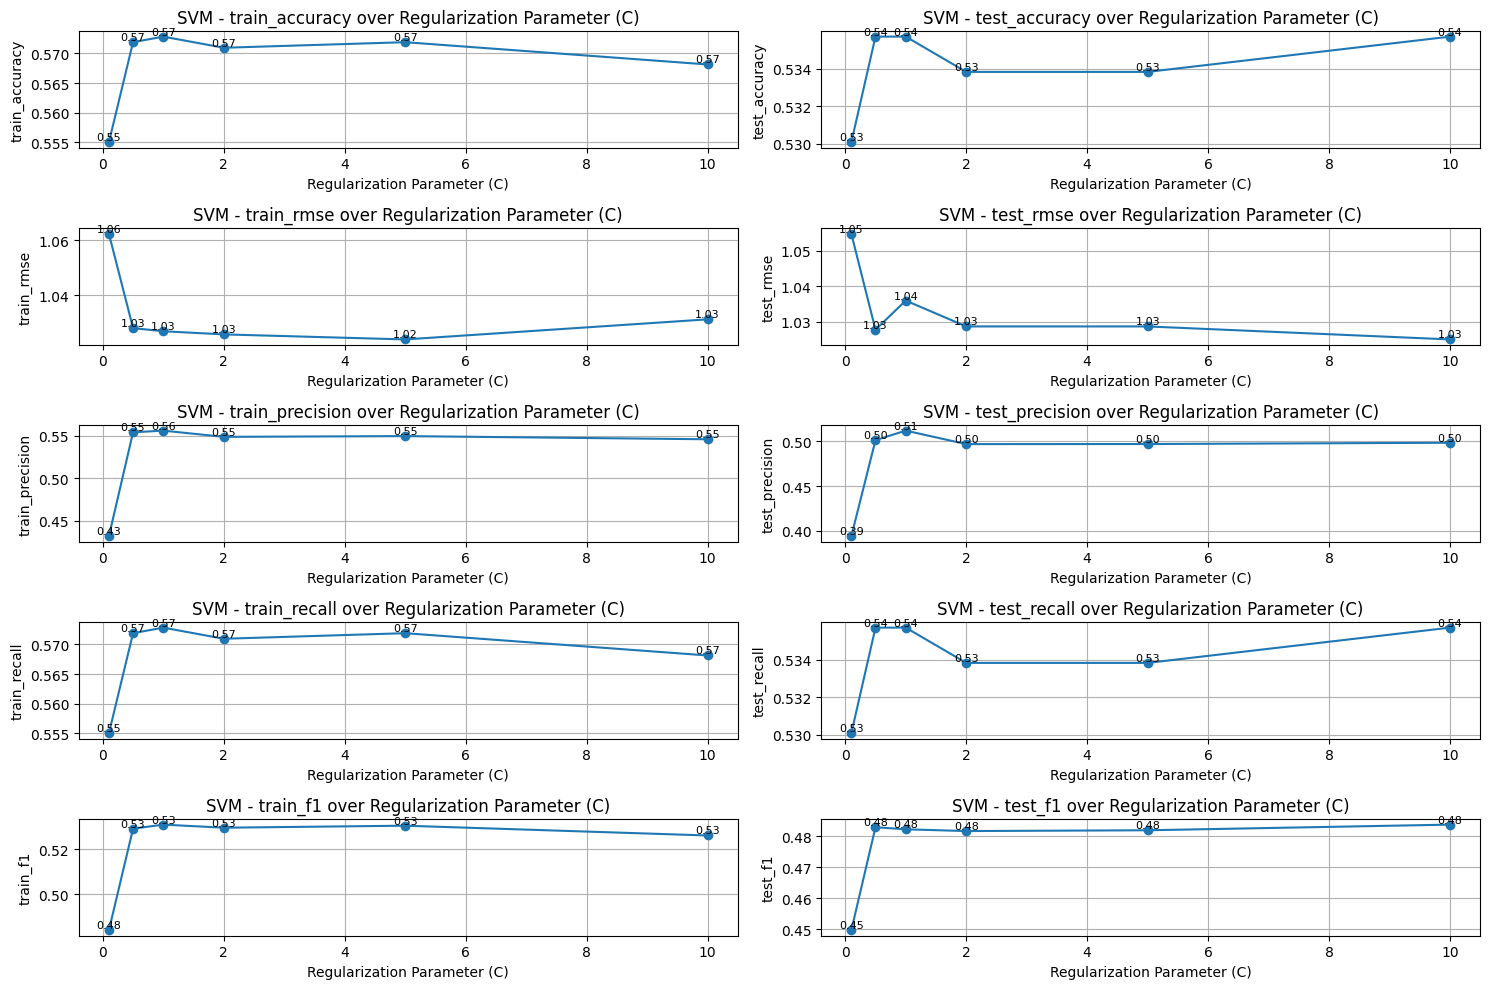

Plotting Metric: train_accuracy
Metric Data: [0.3449248120300752, 0.37546992481203006, 0.3881578947368421, 0.38956766917293234, 0.399906015037594, 0.3801691729323308, 0.4158834586466165, 0.4440789473684211, 0.4351503759398496, 0.4567669172932331]
Parameter Values: range(1, 11)
Plotting Metric: test_accuracy
Metric Data: [0.32142857142857145, 0.3533834586466165, 0.36278195488721804, 0.34962406015037595, 0.34774436090225563, 0.31954887218045114, 0.3609022556390977, 0.3533834586466165, 0.34210526315789475, 0.34210526315789475]
Parameter Values: range(1, 11)
Plotting Metric: train_rmse
Metric Data: [1.6972445603814321, 1.6275644888647374, 1.6117519539005547, 1.6485069572100461, 1.6496468065819925, 1.6982133468526772, 1.6344792921266935, 1.6204751925358376, 1.6801304550137355, 1.6594455093483005]
Parameter Values: range(1, 11)
Plotting Metric: test_rmse
Metric Data: [1.747716017605689, 1.6673557472746856, 1.635485258287334, 1.6377822892764684, 1.6152469026099314, 1.6841811557589443, 1.62047

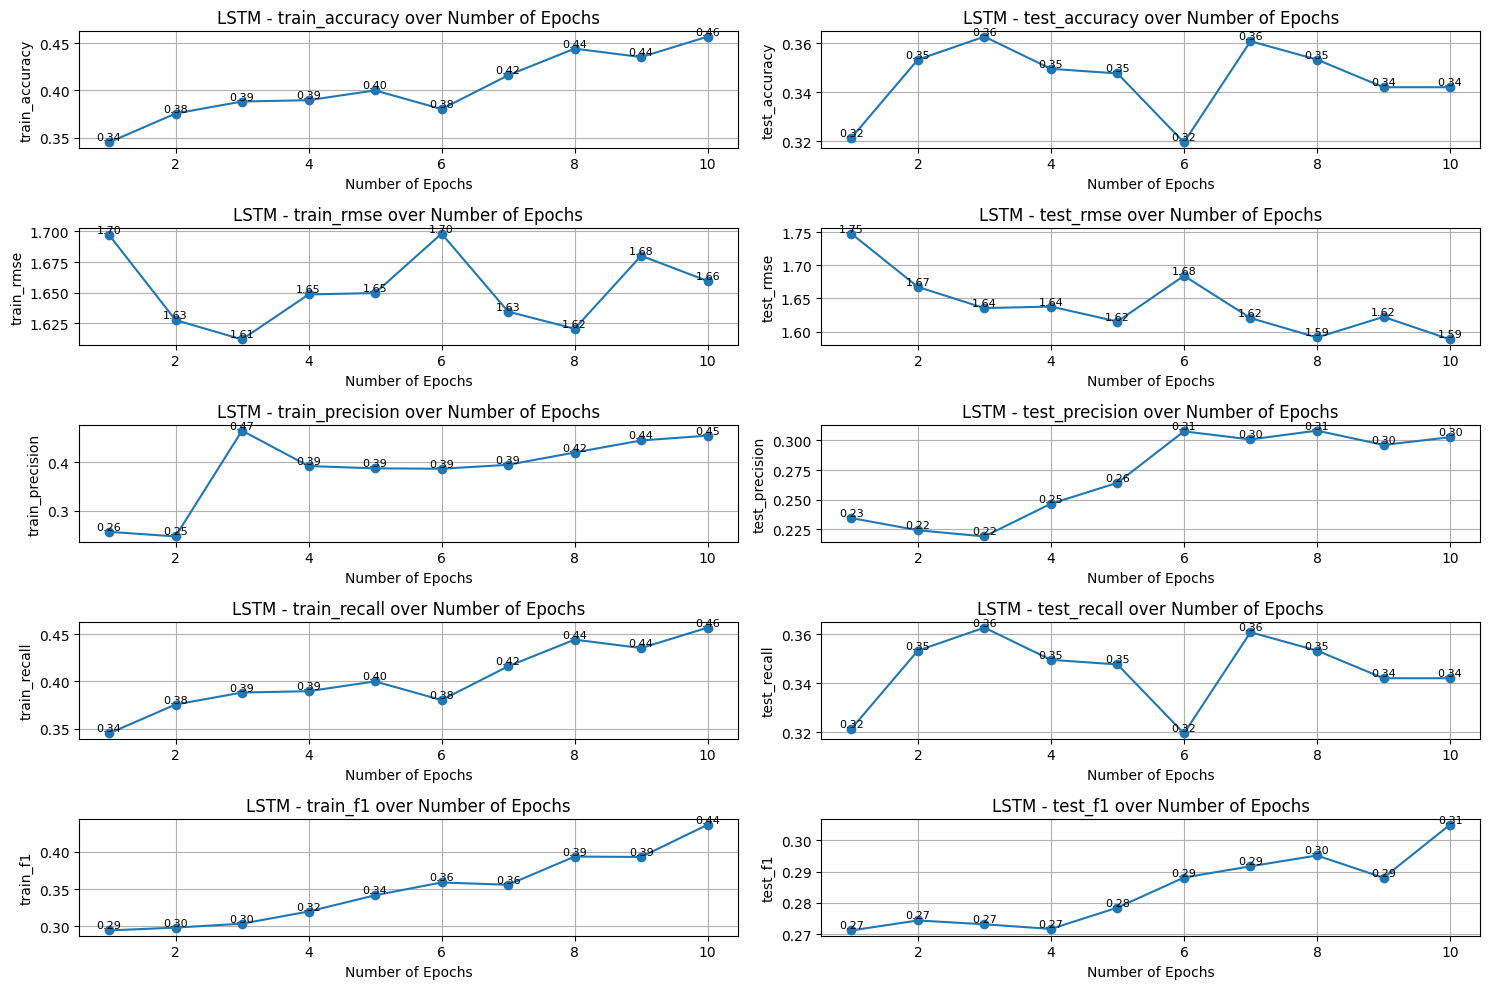

Plotting Metric: train_accuracy
Metric Data: [0.4849624060150376, 0.506578947368421, 0.5136278195488722, 0.5155075187969925, 0.5159774436090225, 0.5155075187969925, 0.5145676691729323]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: test_accuracy
Metric Data: [0.47368421052631576, 0.49624060150375937, 0.49624060150375937, 0.4906015037593985, 0.48872180451127817, 0.48872180451127817, 0.4868421052631579]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: train_rmse
Metric Data: [0.9471464861178621, 0.9364185491798634, 0.9311344039372021, 0.9278481856635263, 0.9306295871996703, 0.9278481856635263, 0.9253123837487516]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: test_rmse
Metric Data: [0.908398574374053, 0.8768106936398546, 0.883218652412824, 0.8895804536176852, 0.8906363358334124, 0.8937964983435144, 0.8916909677432464]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: train_precision
Metric Data: [0.5597814

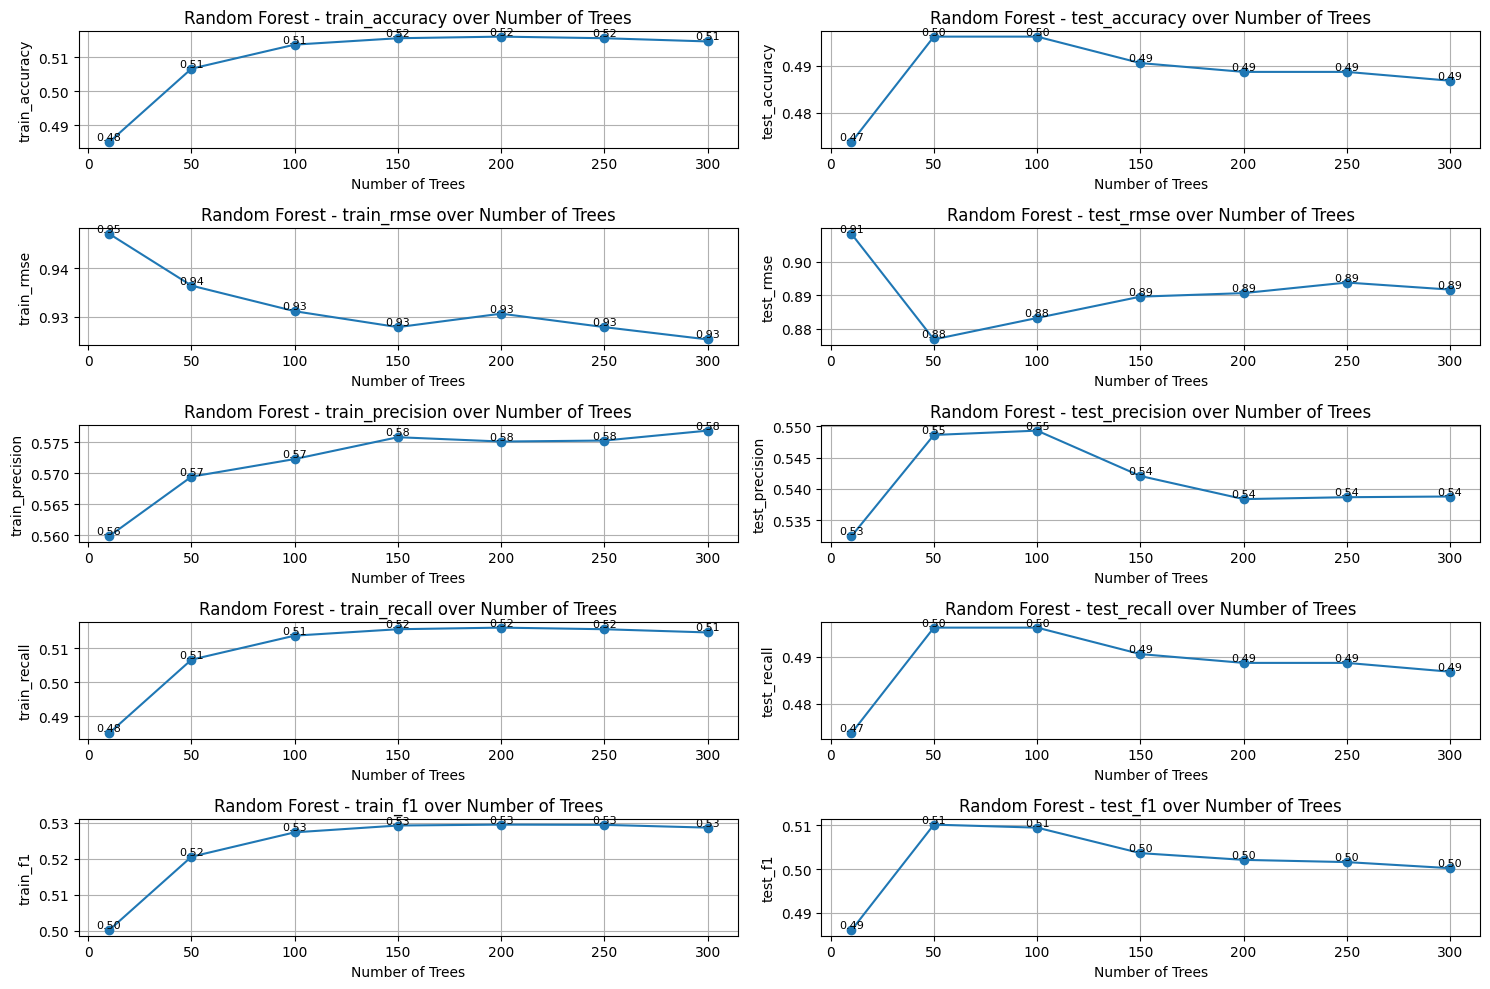

In [107]:
# Define parameter ranges
iterations = np.arange(0, 200, 10)  # for logistic regression [0, 10, ..., 190]
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
c_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # for SVM
epochs = range(1, 11)  # for LSTM [1, 2, ..., 10]
n_estimators = [10, 50, 100, 150, 200, 250, 300]  # for Random Forest

# Helper function to safely get metrics
def get_metrics(metrics_obj):
    if isinstance(metrics_obj, tuple):
        return metrics_obj[0]
    return metrics_obj

# Plot metrics for each model
trainer.plot_metrics(get_metrics(metrics_logistic), "Logistic Regression", 
                    param_values=iterations,
                    param_name="Number of Iterations")

trainer.plot_metrics(get_metrics(metrics_knn), "KNN", 
                    param_values=neighbors_range,
                    param_name="Number of Neighbors")

trainer.plot_metrics(get_metrics(metrics_svm), "SVM", 
                    param_values=c_values,
                    param_name="Regularization Parameter (C)")

trainer.plot_metrics(get_metrics(metrics_lstm), "LSTM", 
                    param_values=epochs,
                    param_name="Number of Epochs")

trainer.plot_metrics(get_metrics(metrics_rf), "Random Forest", 
                    param_values=n_estimators,
                    param_name="Number of Trees")



## Feature Selection Model Testing

Plotting Metric: train_accuracy
Metric Data: [0.519266917293233, 0.5465225563909775, 0.5615601503759399, 0.5634398496240601, 0.5653195488721805, 0.5681390977443609, 0.5676691729323309, 0.5671992481203008, 0.5653195488721805, 0.5657894736842105, 0.5662593984962406, 0.5653195488721805, 0.5662593984962406, 0.5653195488721805, 0.5653195488721805, 0.5657894736842105, 0.5657894736842105, 0.5657894736842105, 0.5657894736842105, 0.5657894736842105]
Parameter Values: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
Plotting Metric: test_accuracy
Metric Data: [0.5319548872180451, 0.5150375939849624, 0.5281954887218046, 0.5281954887218046, 0.543233082706767, 0.543233082706767, 0.5357142857142857, 0.5338345864661654, 0.5357142857142857, 0.5394736842105263, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061, 0.5375939849624061]
Parameter V

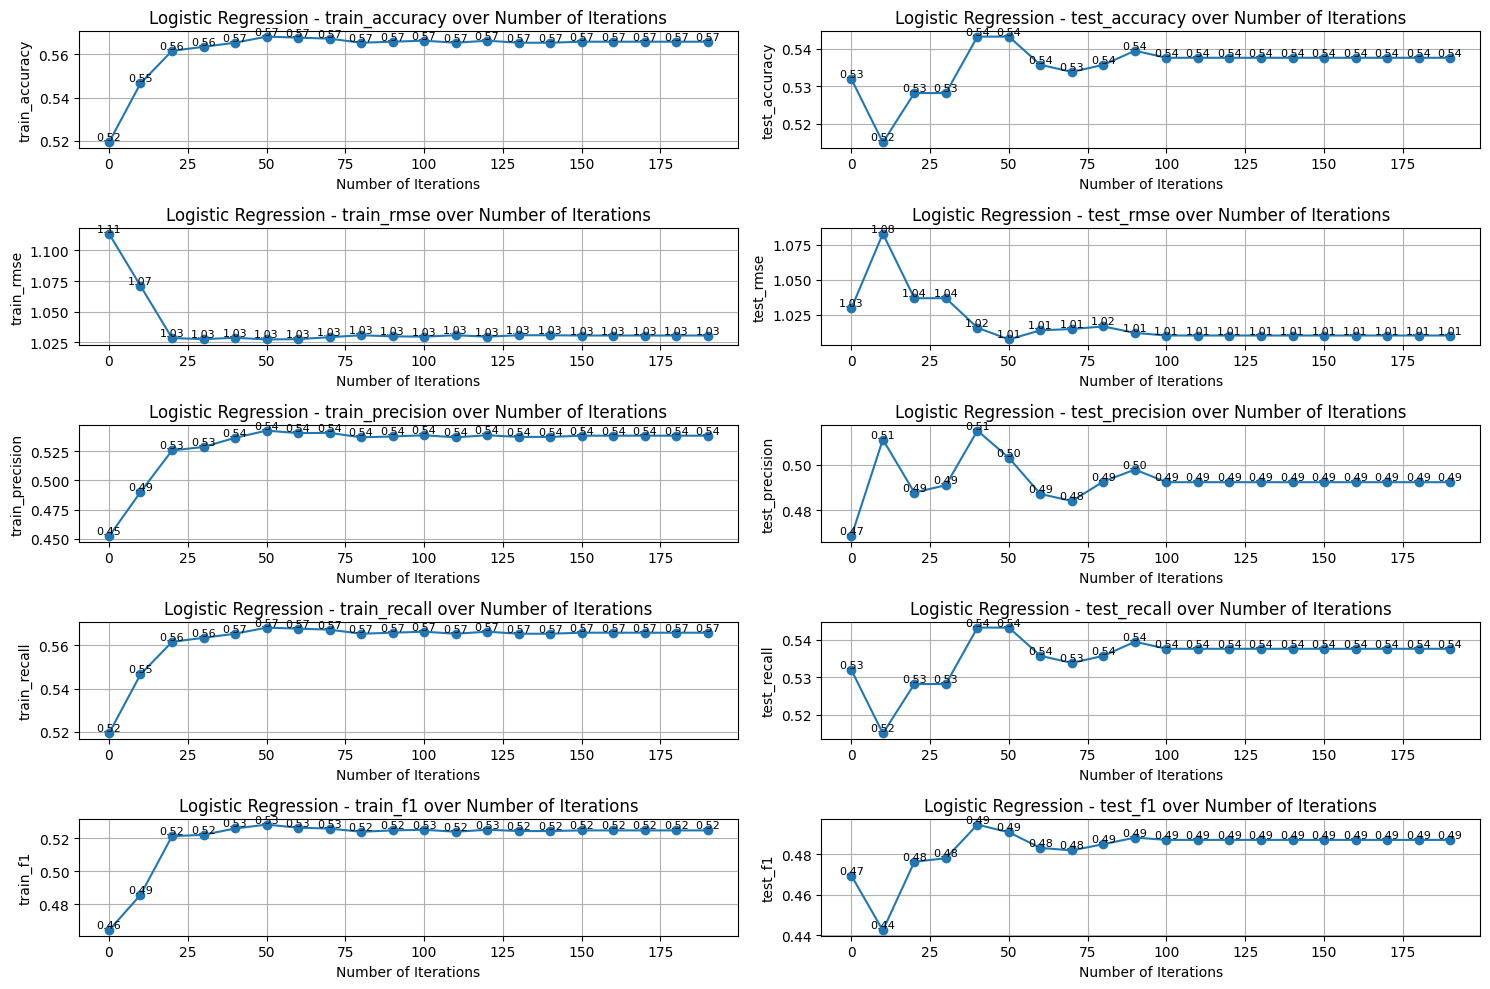

Plotting Metric: train_accuracy
Metric Data: [1.0, 0.674812030075188, 0.6080827067669173, 0.6033834586466166, 0.5911654135338346, 0.5775375939849624, 0.5625, 0.5606203007518797, 0.5531015037593985, 0.5390037593984962, 0.5455827067669173, 0.5516917293233082, 0.5427631578947368, 0.5488721804511278, 0.5357142857142857, 0.5427631578947368, 0.5390037593984962, 0.5357142857142857, 0.5314849624060151, 0.5361842105263158, 0.5324248120300752, 0.5319548872180451, 0.5333646616541353, 0.5357142857142857, 0.537124060150376, 0.5338345864661654]
Parameter Values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
Plotting Metric: test_accuracy
Metric Data: [0.41353383458646614, 0.4323308270676692, 0.45300751879699247, 0.4680451127819549, 0.4868421052631579, 0.4718045112781955, 0.4774436090225564, 0.48120300751879697, 0.4793233082706767, 0.4868421052631579, 0.4755639097744361, 0.4793233082706767, 0.4868421052631579, 0.48120300751879697, 0.5, 0.5, 0.4887

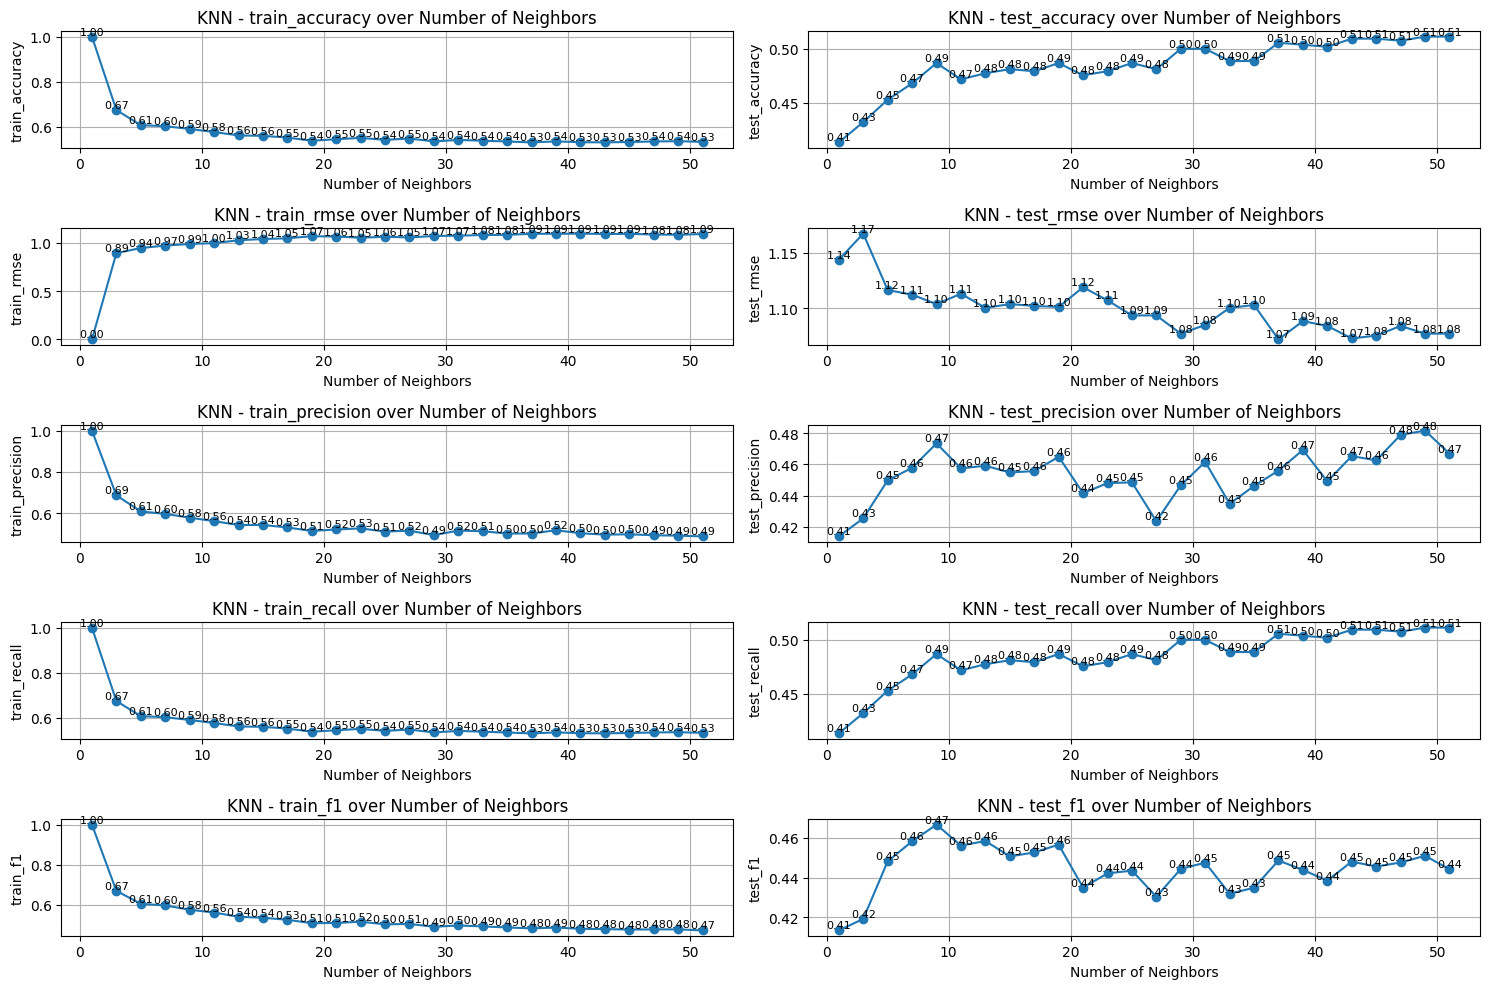

Plotting Metric: train_accuracy
Metric Data: [0.5578007518796992, 0.5615601503759399, 0.5653195488721805, 0.5615601503759399, 0.5615601503759399, 0.5620300751879699]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_accuracy
Metric Data: [0.5281954887218046, 0.5357142857142857, 0.5357142857142857, 0.5451127819548872, 0.5451127819548872, 0.5451127819548872]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_rmse
Metric Data: [1.0571098348835464, 1.0432381629626353, 1.038723913473187, 1.0439136166837486, 1.042562271629644, 1.041660400983662]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_rmse
Metric Data: [1.0584426067953328, 1.027808823392565, 1.0305484341786026, 1.0149261982873063, 1.012144303064323, 1.012144303064323]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_precision
Metric Data: [0.43430799450025454, 0.53772813181482, 0.545761624515857, 0.5404740228723902, 0.5389830276783966, 0.53932

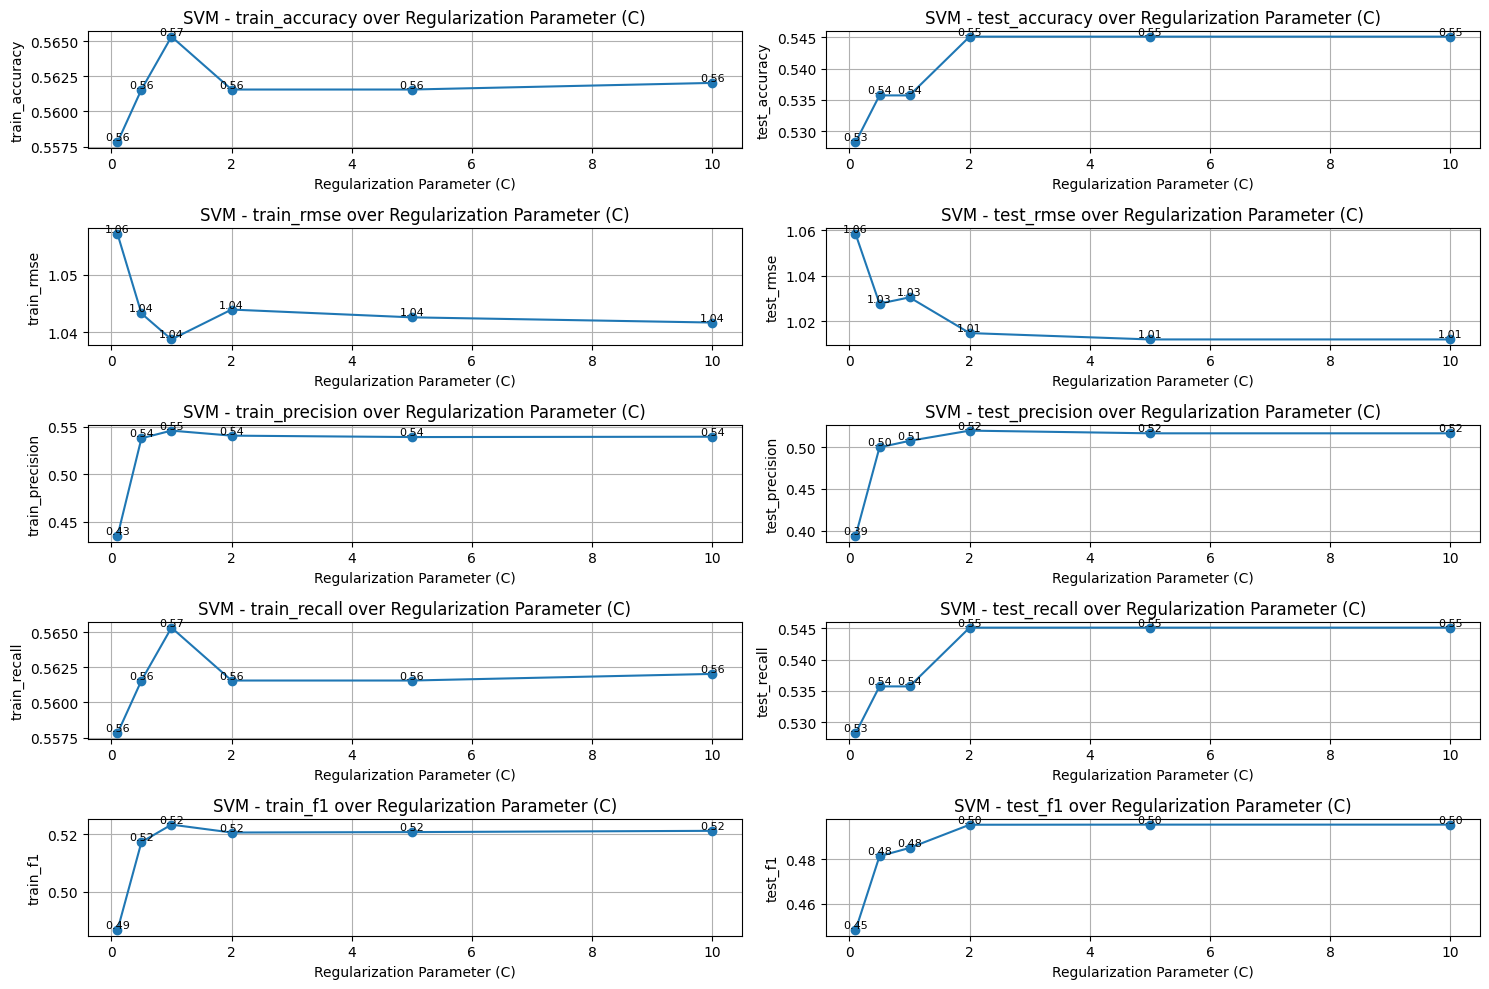

Plotting Metric: train_accuracy
Metric Data: [0.3425751879699248, 0.36701127819548873, 0.37406015037593987, 0.3782894736842105, 0.39144736842105265, 0.3792293233082707, 0.39614661654135336, 0.3933270676691729, 0.4031954887218045, 0.42105263157894735]
Parameter Values: range(1, 11)
Plotting Metric: test_accuracy
Metric Data: [0.32142857142857145, 0.34022556390977443, 0.34962406015037595, 0.34962406015037595, 0.3609022556390977, 0.3383458646616541, 0.34962406015037595, 0.3609022556390977, 0.34210526315789475, 0.34962406015037595]
Parameter Values: range(1, 11)
Plotting Metric: train_rmse
Metric Data: [1.6959981646322881, 1.6522085924854364, 1.6419374673283211, 1.6402193599857857, 1.61989510474473, 1.6583123951777, 1.6317456863624324, 1.6442254844178223, 1.6539142453062878, 1.6175726732927516]
Parameter Values: range(1, 11)
Plotting Metric: test_rmse
Metric Data: [1.749328550027081, 1.7069076819167657, 1.6880829541673525, 1.6880829541673525, 1.652635170725468, 1.6763503142063862, 1.643510

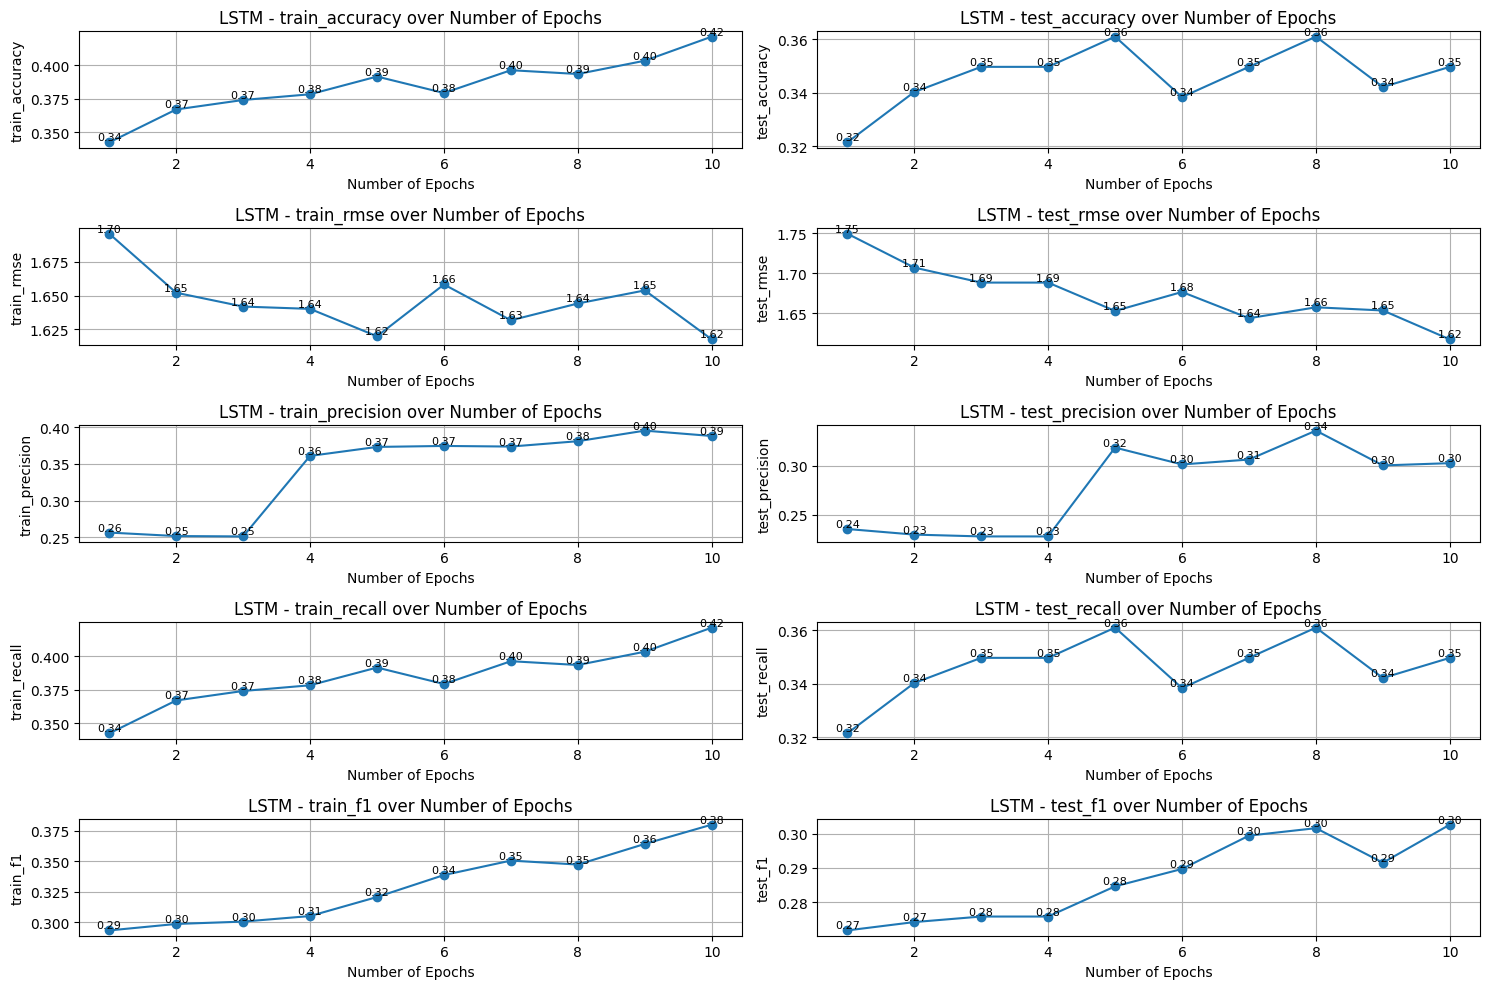

Plotting Metric: train_accuracy
Metric Data: [0.4718045112781955, 0.49718045112781956, 0.5009398496240601, 0.49953007518796994, 0.5046992481203008, 0.506109022556391, 0.5028195488721805]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: test_accuracy
Metric Data: [0.4793233082706767, 0.4830827067669173, 0.48120300751879697, 0.4868421052631579, 0.48872180451127817, 0.4943609022556391, 0.4906015037593985]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: train_rmse
Metric Data: [0.930124496477417, 0.919453499010203, 0.9242961150360185, 0.9181748813717107, 0.9230242056471359, 0.9237875614266607, 0.9232787276995806]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: test_rmse
Metric Data: [0.8605820726458334, 0.8810878443570108, 0.8885233166386386, 0.8821538917455415, 0.8874649204122979, 0.8874649204122979, 0.8864052604279183]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: train_precision
Metric Data: [0.56690055

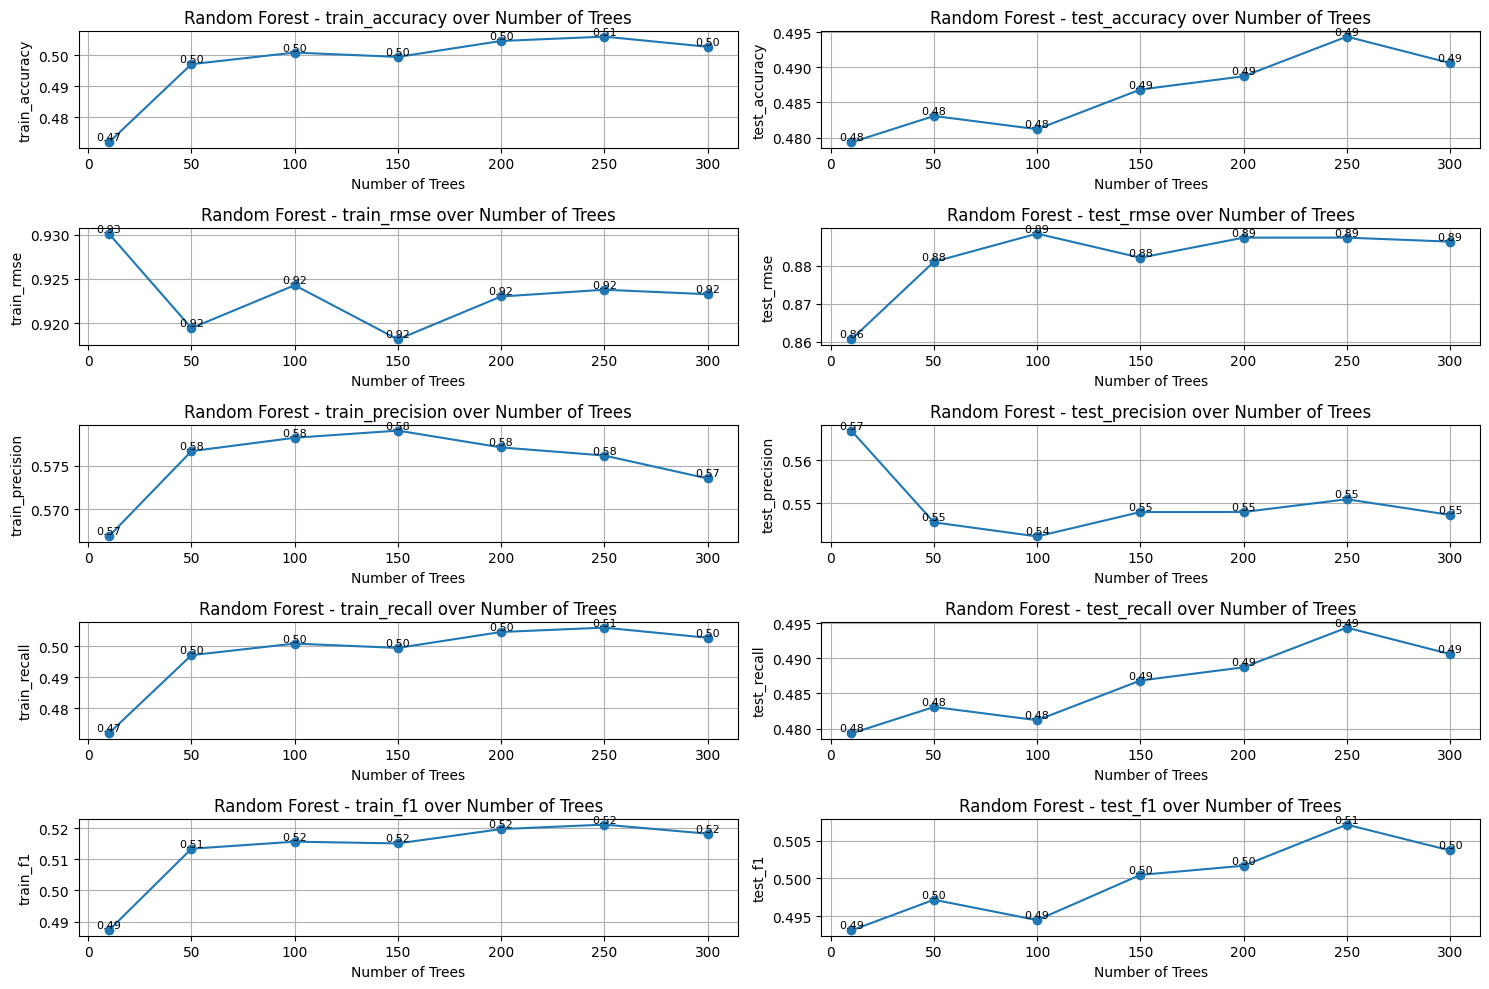

In [108]:
# Define parameter ranges
iterations = np.arange(0, 200, 10)  # for logistic regression [0, 10, ..., 190]
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
c_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # for SVM
epochs = range(1, 11)  # for LSTM [1, 2, ..., 10]
n_estimators = [10, 50, 100, 150, 200, 250, 300]  # for Random Forest

# Helper function to safely get metrics
def get_metrics(metrics_obj):
    if isinstance(metrics_obj, tuple):
        return metrics_obj[0]
    return metrics_obj

# Plot metrics for each model
trainer.plot_metrics(get_metrics(metrics_logistic2), "Logistic Regression", 
                    param_values=iterations,
                    param_name="Number of Iterations")

trainer.plot_metrics(get_metrics(metrics_knn2), "KNN", 
                    param_values=neighbors_range,
                    param_name="Number of Neighbors")

trainer.plot_metrics(get_metrics(metrics_svm2), "SVM", 
                    param_values=c_values,
                    param_name="Regularization Parameter (C)")

trainer.plot_metrics(get_metrics(metrics_lstm2), "LSTM", 
                    param_values=epochs,
                    param_name="Number of Epochs")

trainer.plot_metrics(get_metrics(metrics_rf2), "Random Forest", 
                    param_values=n_estimators,
                    param_name="Number of Trees")


## Embedded Feature Selection Model Testing

Plotting Metric: train_accuracy
Metric Data: [0.3294172932330827, 0.5681390977443609, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406, 0.5662593984962406]
Parameter Values: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
Plotting Metric: test_accuracy
Metric Data: [0.3233082706766917, 0.5263157894736842, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639, 0.5244360902255639]
Paramete

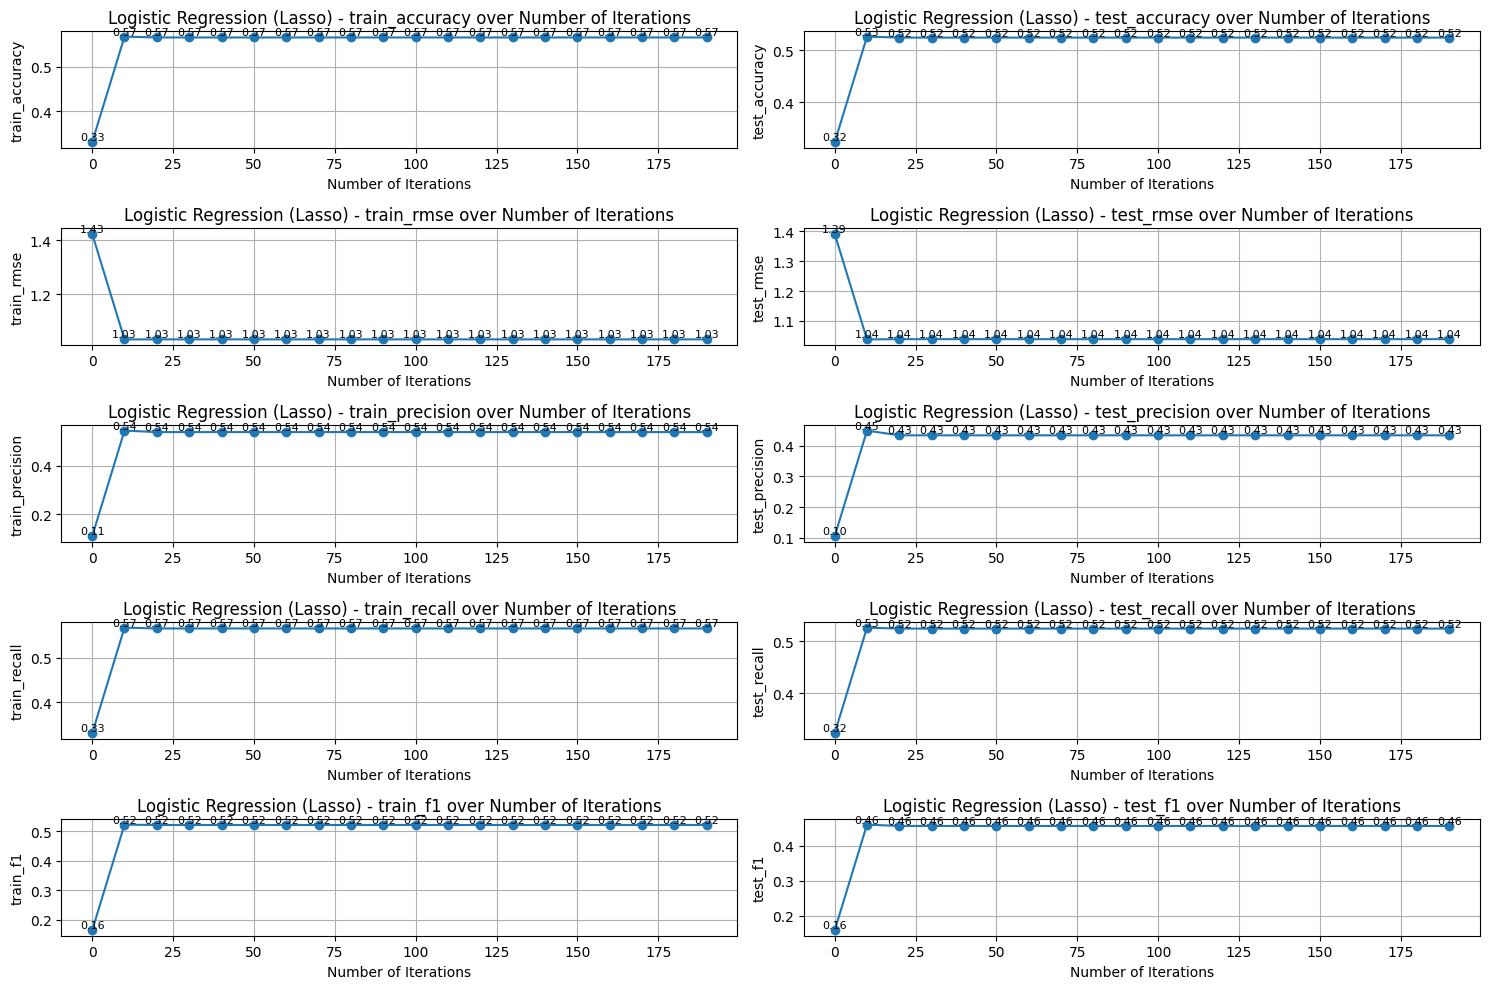

Plotting Metric: train_accuracy
Metric Data: [0.5164473684210527, 0.5526315789473685, 0.5568609022556391, 0.5620300751879699, 0.5629699248120301, 0.5653195488721805, 0.5667293233082706, 0.5667293233082706, 0.5653195488721805, 0.5657894736842105, 0.5671992481203008, 0.5653195488721805, 0.5657894736842105, 0.5643796992481203, 0.5648496240601504, 0.5657894736842105, 0.5653195488721805, 0.5653195488721805, 0.5653195488721805, 0.5653195488721805]
Parameter Values: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
Plotting Metric: test_accuracy
Metric Data: [0.5263157894736842, 0.5169172932330827, 0.5112781954887218, 0.5225563909774437, 0.5244360902255639, 0.5394736842105263, 0.5263157894736842, 0.5244360902255639, 0.5263157894736842, 0.5244360902255639, 0.5263157894736842, 0.5300751879699248, 0.5300751879699248, 0.5300751879699248, 0.5263157894736842, 0.5281954887218046, 0.5281954887218046, 0.5281954887218046, 0.5281954887218046, 0.5281954887218046]
Paramete

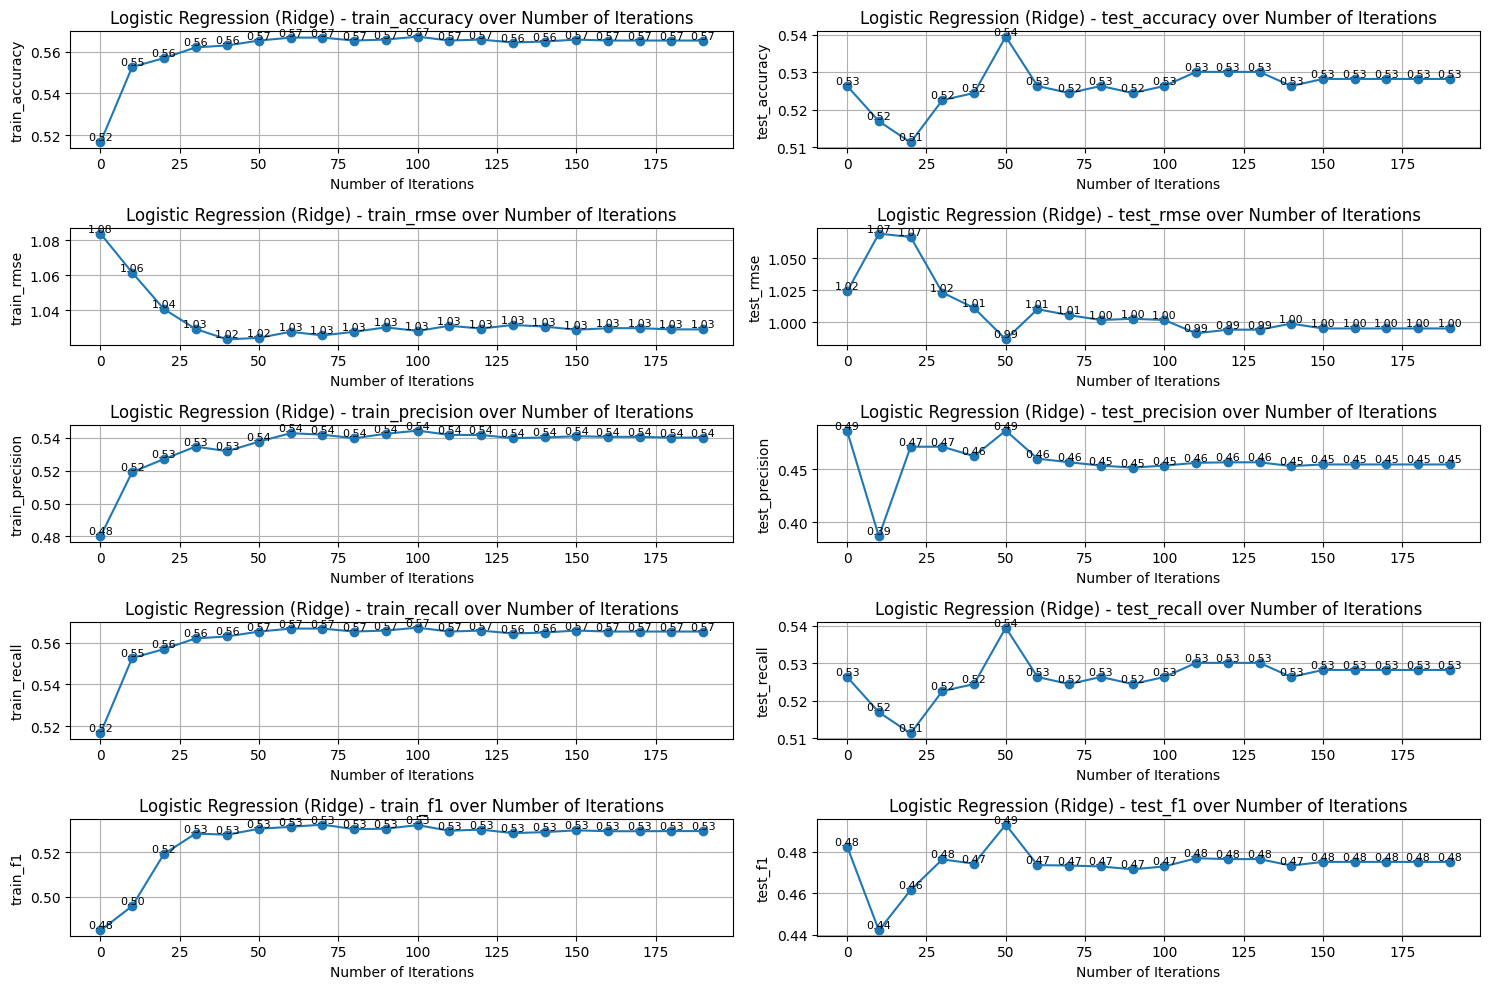

Plotting Metric: train_accuracy
Metric Data: [0.3294172932330827, 0.5582706766917294, 0.5610902255639098, 0.5615601503759399, 0.5601503759398496, 0.5610902255639098, 0.5615601503759399, 0.5620300751879699, 0.5629699248120301, 0.5639097744360902, 0.5634398496240601, 0.5634398496240601, 0.5634398496240601, 0.5634398496240601, 0.5634398496240601, 0.5634398496240601, 0.5634398496240601, 0.5634398496240601, 0.5639097744360902, 0.5639097744360902]
Parameter Values: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
Plotting Metric: test_accuracy
Metric Data: [0.3233082706766917, 0.5206766917293233, 0.5263157894736842, 0.5338345864661654, 0.5357142857142857, 0.5357142857142857, 0.5357142857142857, 0.5357142857142857, 0.5338345864661654, 0.5319548872180451, 0.5319548872180451, 0.5338345864661654, 0.5338345864661654, 0.5338345864661654, 0.5338345864661654, 0.5338345864661654, 0.5338345864661654, 0.5338345864661654, 0.5338345864661654, 0.5338345864661654]
Paramete

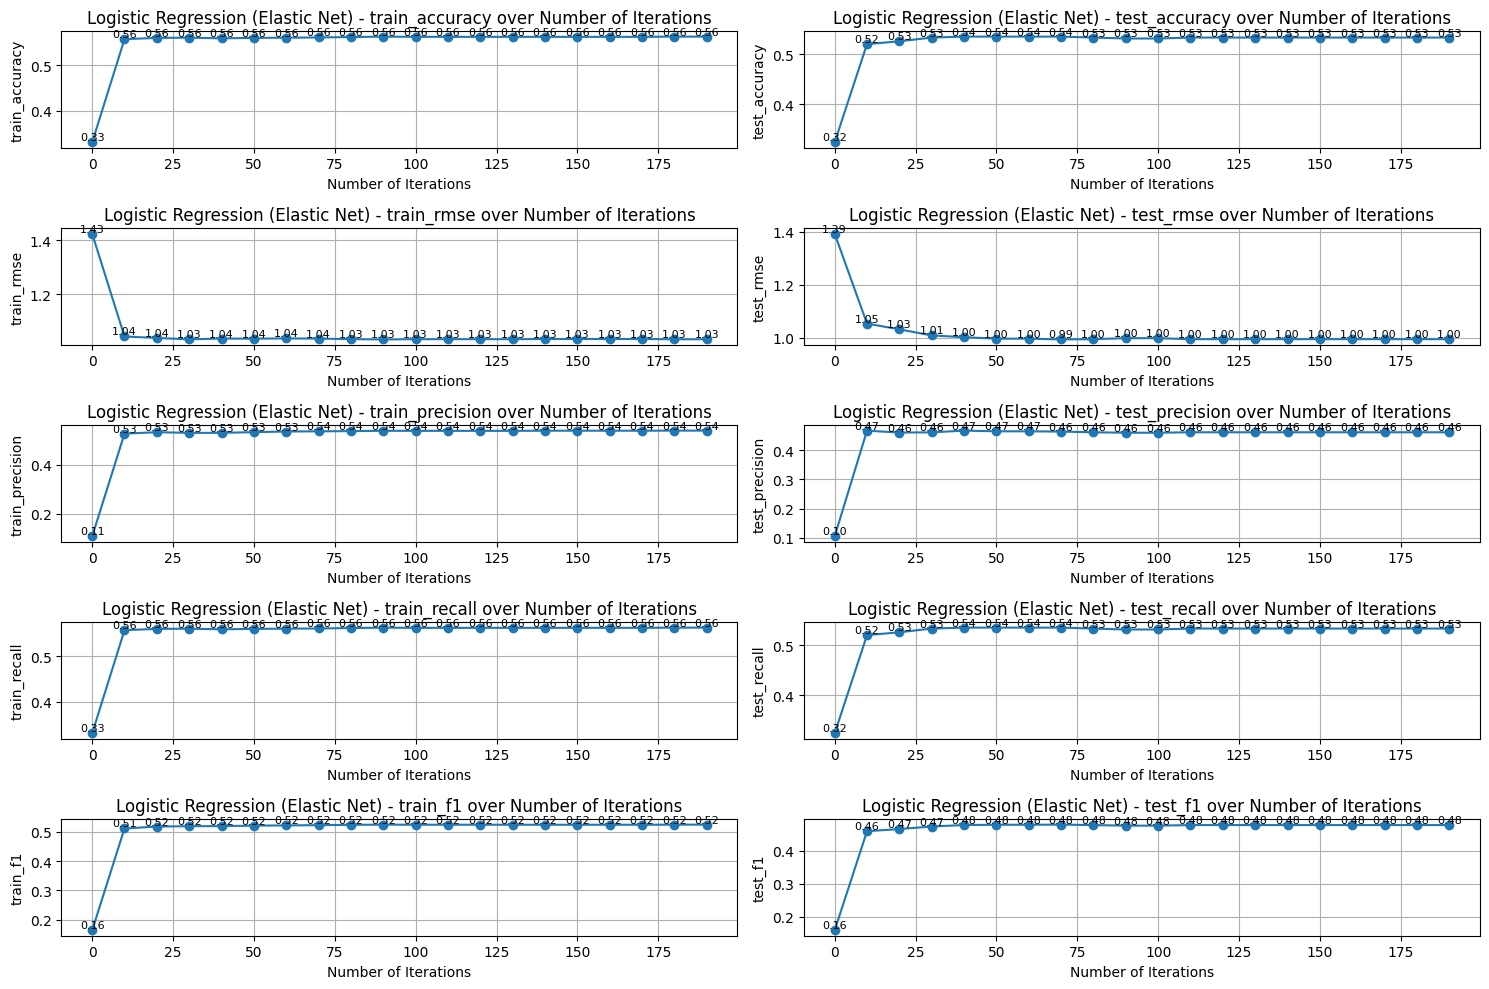

Plotting Metric: train_accuracy
Metric Data: [0.5573308270676691, 0.5653195488721805, 0.5643796992481203, 0.568609022556391, 0.5671992481203008, 0.5662593984962406]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_accuracy
Metric Data: [0.5244360902255639, 0.5357142857142857, 0.5338345864661654, 0.5357142857142857, 0.5319548872180451, 0.5300751879699248]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_rmse
Metric Data: [1.0546620454321791, 1.0434633627845706, 1.042562271629644, 1.0378187072764358, 1.0391762208812867, 1.041660400983662]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_rmse
Metric Data: [1.0602170298462197, 1.019545822516343, 1.0149261982873063, 1.008423171705749, 1.0130724502589556, 1.0112153039671836]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_precision
Metric Data: [0.52506078893185, 0.5521112816100511, 0.5471717352260516, 0.5560791543153855, 0.5530294951015959, 0.5532

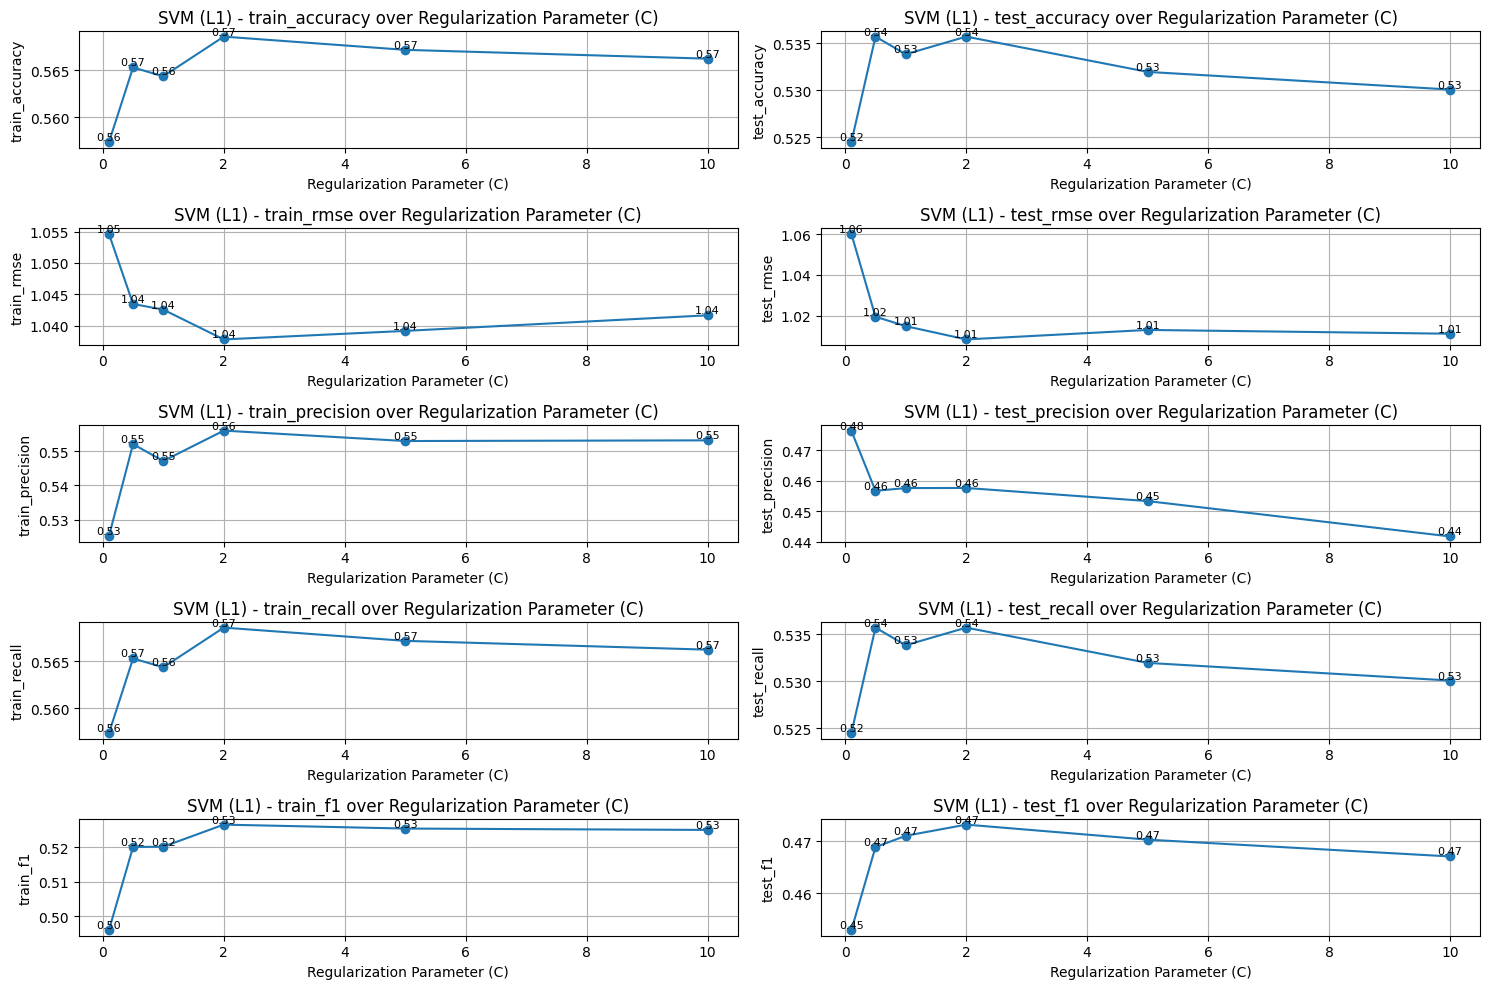

Plotting Metric: train_accuracy
Metric Data: [0.5625, 0.5676691729323309, 0.5657894736842105, 0.5662593984962406, 0.5681390977443609, 0.5446428571428571]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_accuracy
Metric Data: [0.5300751879699248, 0.5338345864661654, 0.5300751879699248, 0.5357142857142857, 0.5394736842105263, 0.4981203007518797]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_rmse
Metric Data: [1.0461619794362846, 1.0382714090241494, 1.0412091727186155, 1.0403061290337874, 1.0319155120745838, 1.0599953894069114]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: test_rmse
Metric Data: [1.022307576982039, 1.012144303064323, 1.0112153039671836, 1.008423171705749, 0.9952896582198564, 1.0646401488843737]
Parameter Values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
Plotting Metric: train_precision
Metric Data: [0.545672571818363, 0.5534422955593183, 0.5509266218909077, 0.551167077373027, 0.5475242614715694, 0.51758089348994

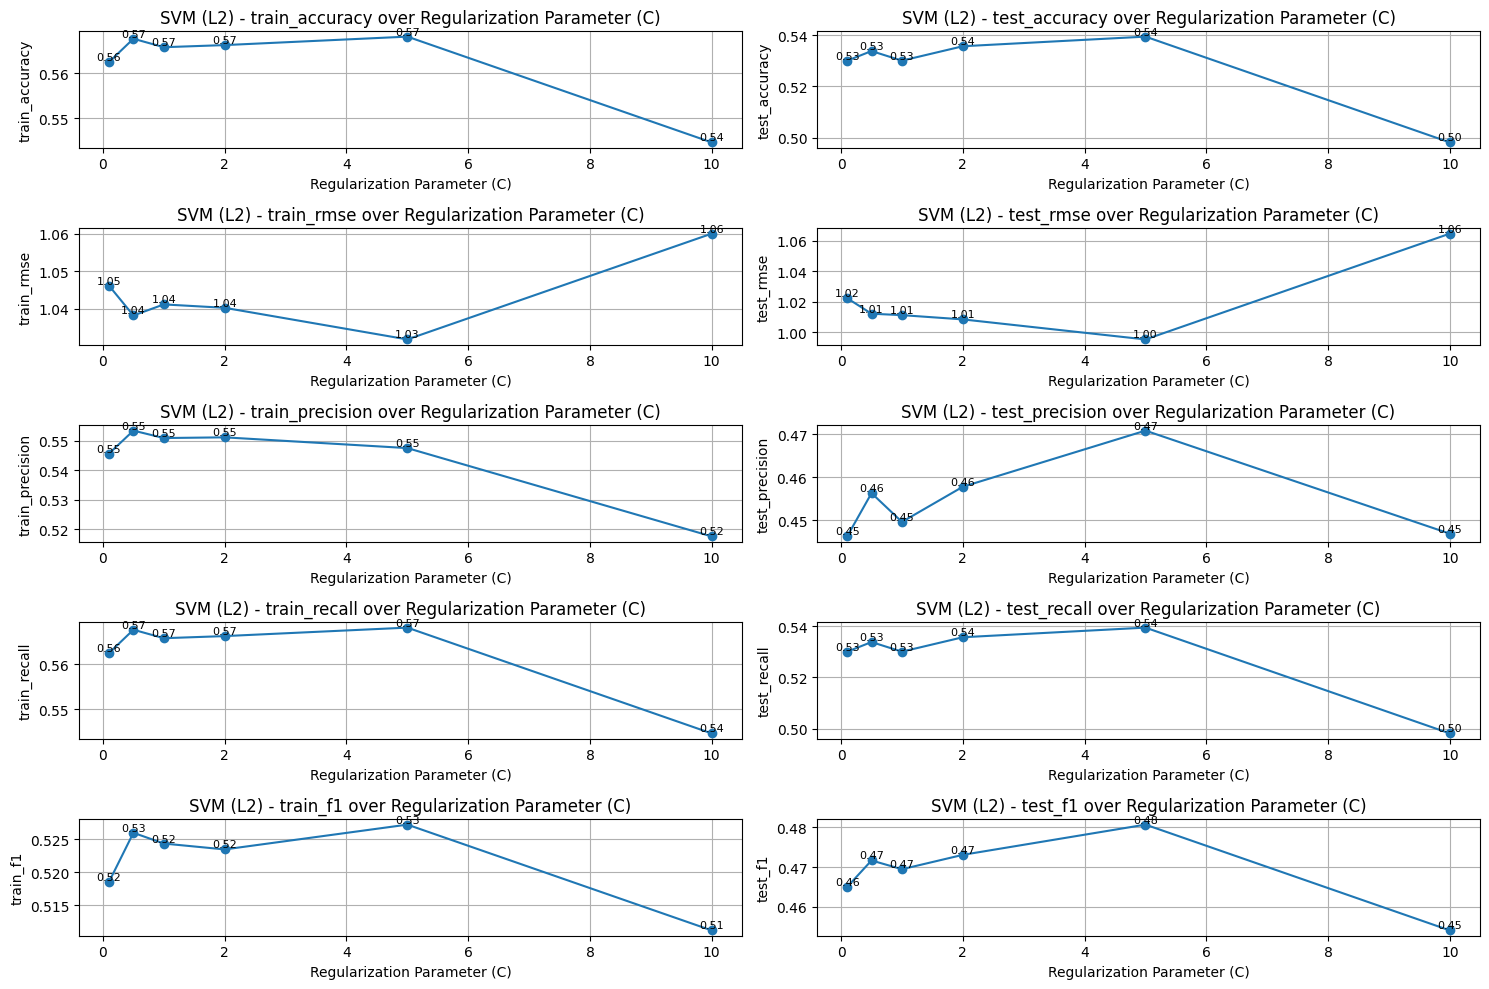

Plotting Metric: train_accuracy
Metric Data: [0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253]
Parameter Values: range(1, 11)
Plotting Metric: test_accuracy
Metric Data: [0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735]
Parameter Values: range(1, 11)
Plotting Metric: train_rmse
Metric Data: [1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893]
Parameter Values: range(1, 11)
Plotting Metric: test_rmse
Metric Data: [1.244536934145037, 1.244536934145037, 1.244536934145037, 1.244536934145037, 1.244536934145037, 1.244536934145037,

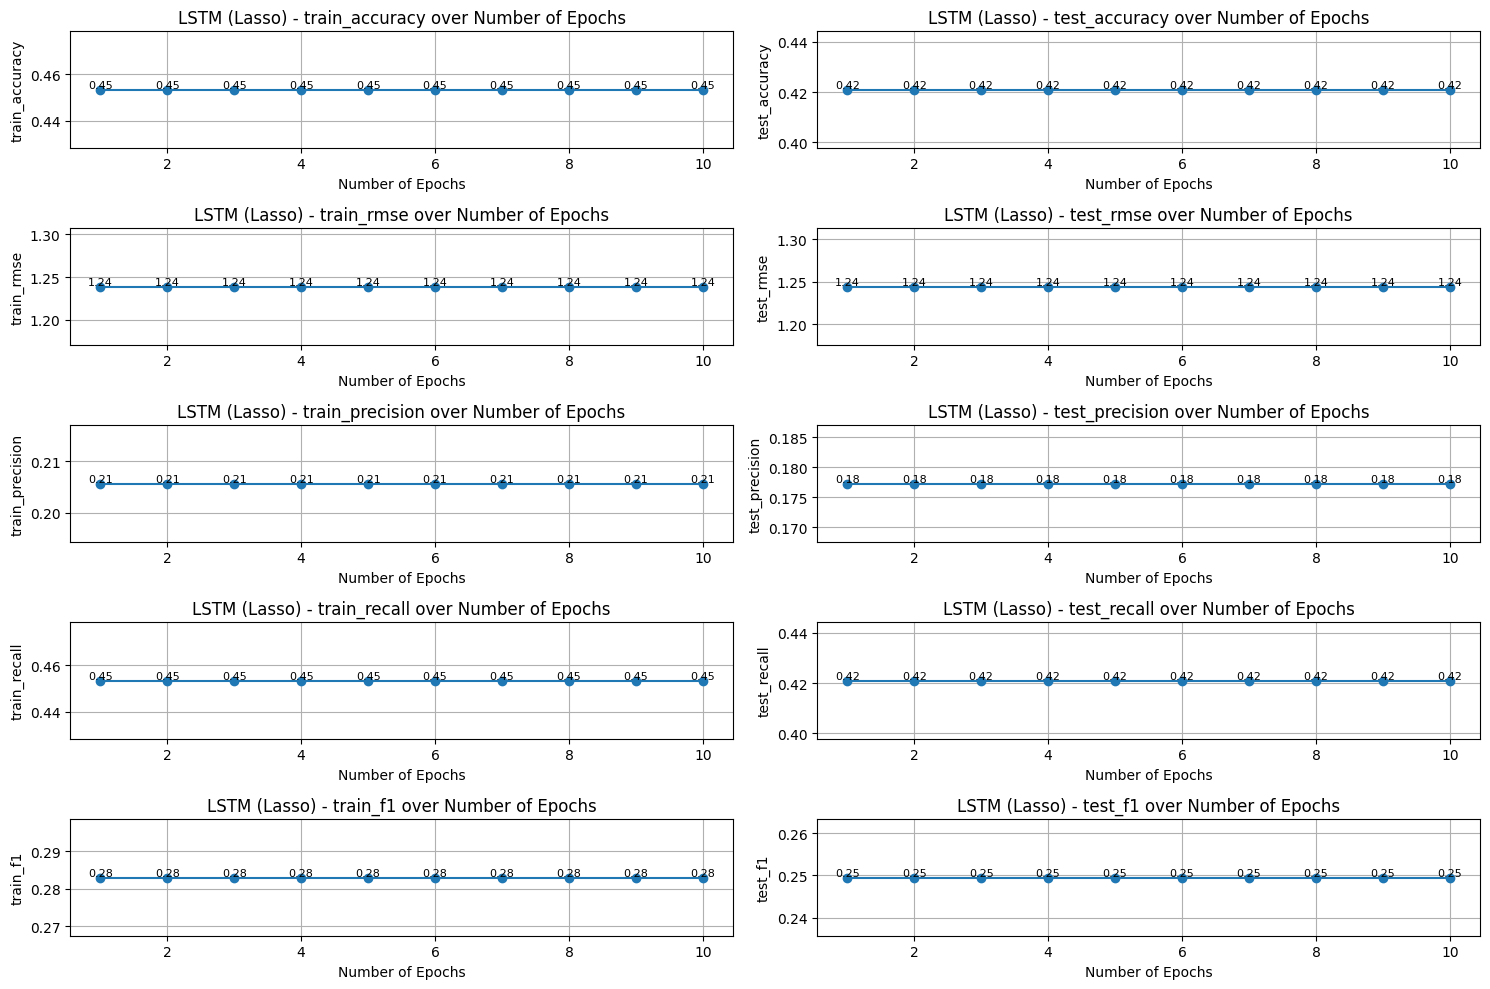

Plotting Metric: train_accuracy
Metric Data: [0.3599624060150376, 0.3641917293233083, 0.35620300751879697, 0.35714285714285715, 0.3731203007518797, 0.36607142857142855, 0.36372180451127817, 0.37875939849624063, 0.3782894736842105, 0.36607142857142855]
Parameter Values: range(1, 11)
Plotting Metric: test_accuracy
Metric Data: [0.33270676691729323, 0.3383458646616541, 0.3233082706766917, 0.3308270676691729, 0.34210526315789475, 0.33458646616541354, 0.33270676691729323, 0.34398496240601506, 0.34774436090225563, 0.34210526315789475]
Parameter Values: range(1, 11)
Plotting Metric: train_rmse
Metric Data: [1.6462248907659742, 1.6402193599857857, 1.6696089317449179, 1.6729830185782304, 1.6268425066223784, 1.6463676125912687, 1.6617094196906756, 1.620910122141308, 1.625975704763513, 1.6492194553879345]
Parameter Values: range(1, 11)
Plotting Metric: test_rmse
Metric Data: [1.711856047633547, 1.7052550357181488, 1.7096585421735733, 1.7315081001115413, 1.6830646948104202, 1.70635697769791, 1.716

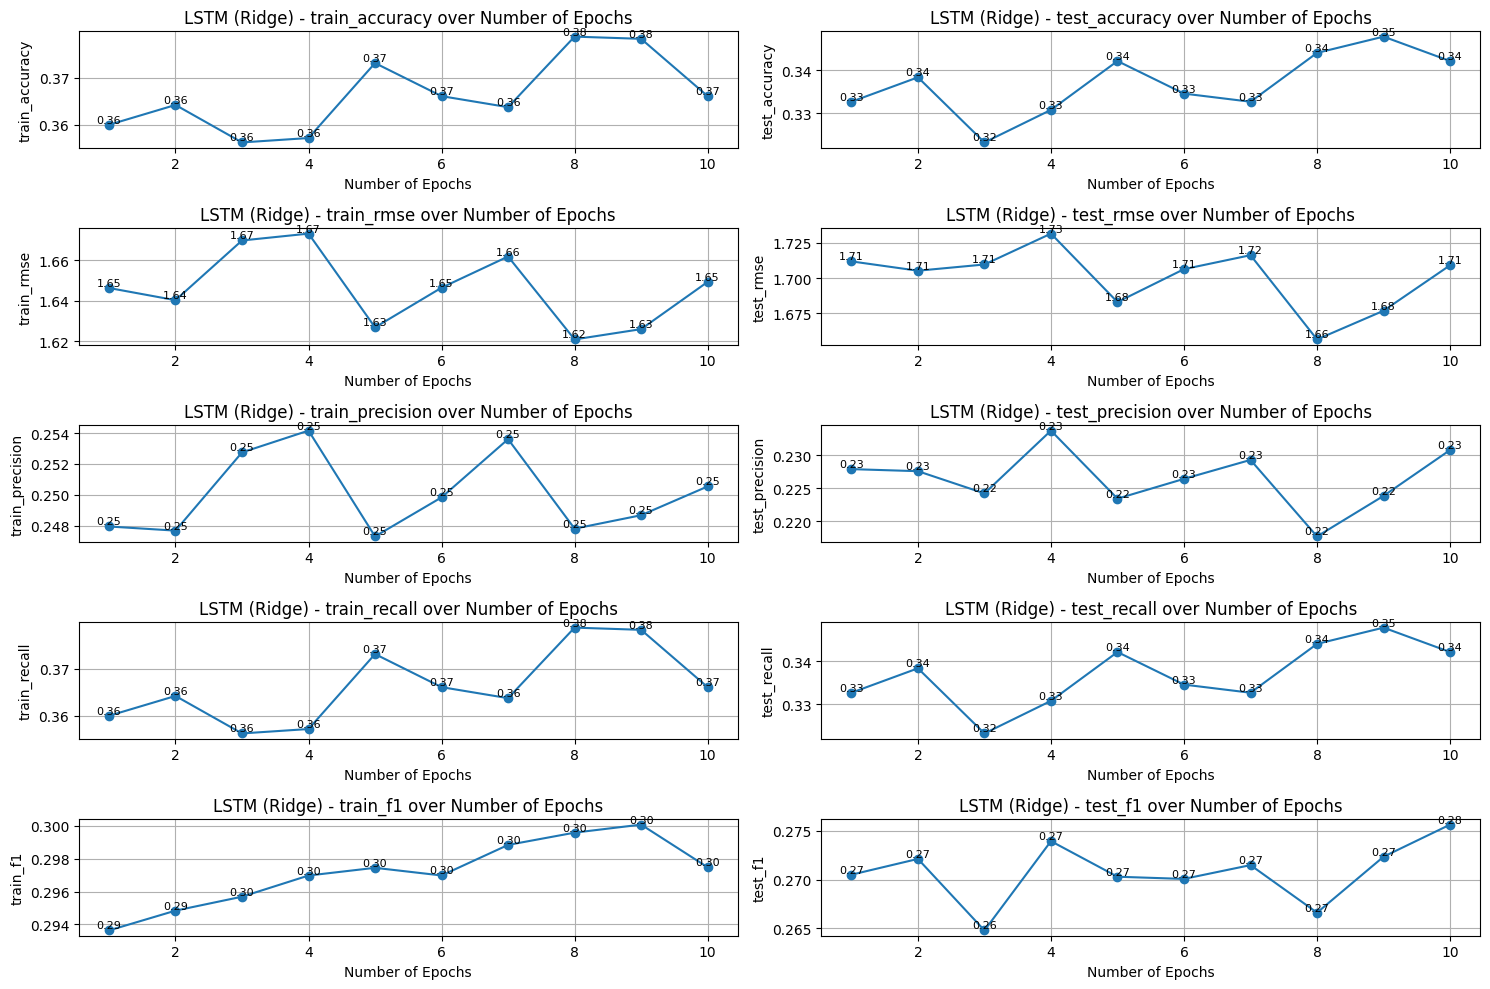

Plotting Metric: train_accuracy
Metric Data: [0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253, 0.45347744360902253]
Parameter Values: range(1, 11)
Plotting Metric: test_accuracy
Metric Data: [0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735, 0.42105263157894735]
Parameter Values: range(1, 11)
Plotting Metric: train_rmse
Metric Data: [1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893, 1.2388601358063893]
Parameter Values: range(1, 11)
Plotting Metric: test_rmse
Metric Data: [1.244536934145037, 1.244536934145037, 1.244536934145037, 1.244536934145037, 1.244536934145037, 1.244536934145037,

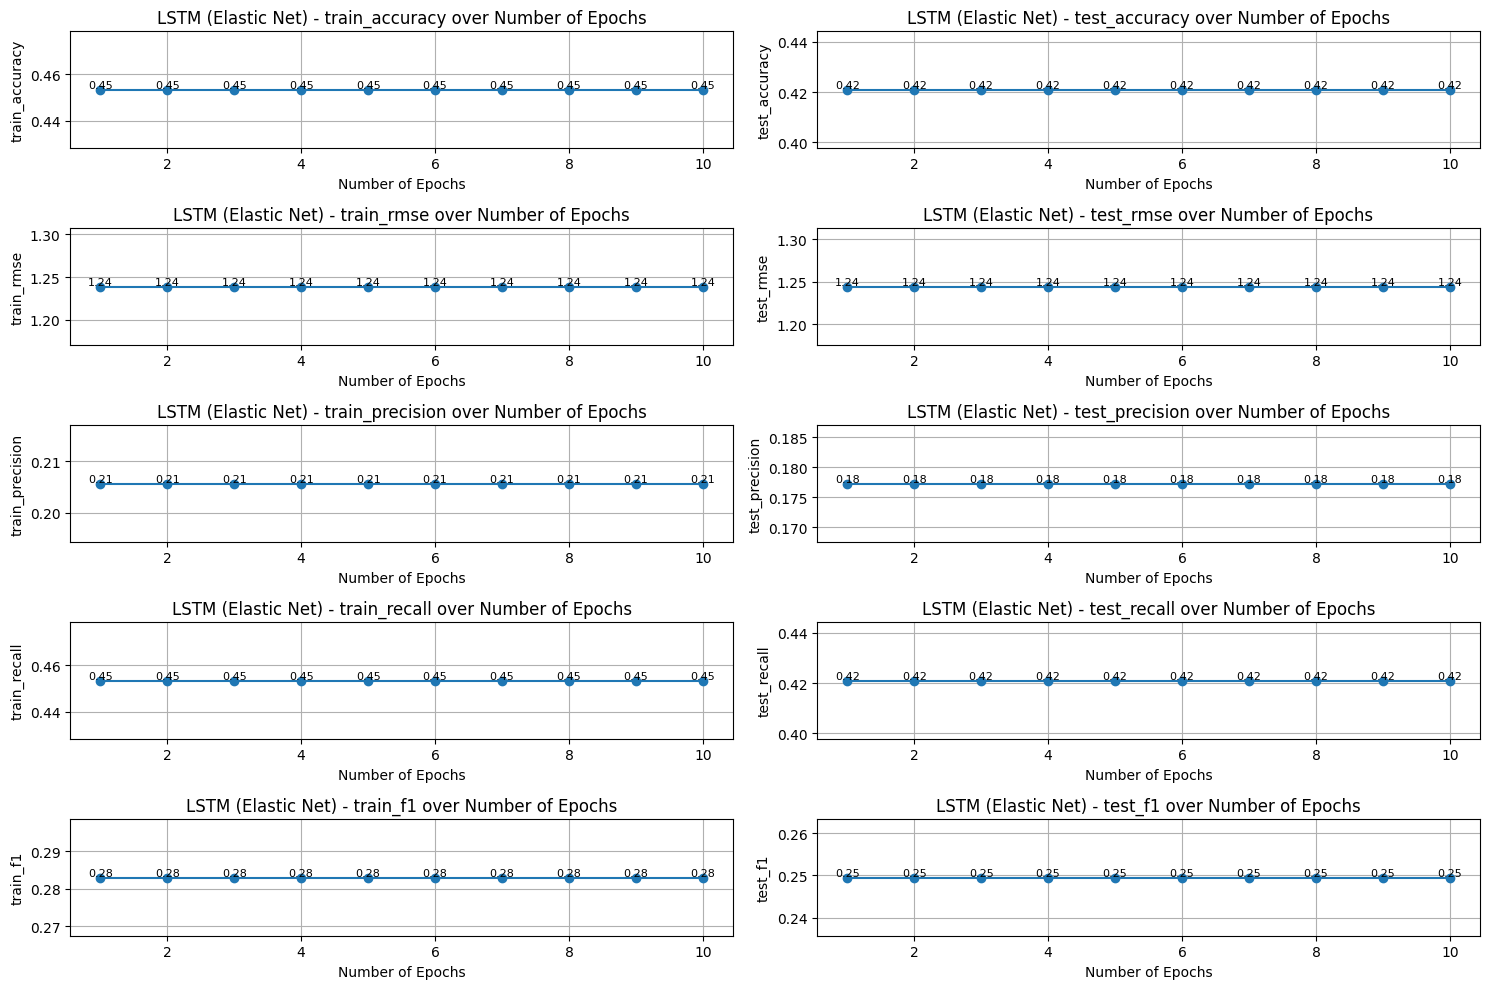

Plotting Metric: train_accuracy
Metric Data: [0.3449248120300752, 0.36654135338345867, 0.37875939849624063, 0.3768796992481203, 0.3825187969924812, 0.38345864661654133, 0.3933270676691729, 0.3815789473684211, 0.40789473684210525, 0.4158834586466165]
Parameter Values: range(1, 11)
Plotting Metric: test_accuracy
Metric Data: [0.325187969924812, 0.33646616541353386, 0.34774436090225563, 0.3458646616541353, 0.35526315789473684, 0.3458646616541353, 0.35526315789473684, 0.3383458646616541, 0.35714285714285715, 0.34210526315789475]
Parameter Values: range(1, 11)
Plotting Metric: train_rmse
Metric Data: [1.7004256433084783, 1.647508942095828, 1.6275644888647374, 1.6587374037008058, 1.6564694314848099, 1.6745272029392233, 1.6666510024326553, 1.7042902520280678, 1.666791975239203, 1.6859938279750388]
Parameter Values: range(1, 11)
Plotting Metric: test_rmse
Metric Data: [1.7552284944328966, 1.7030490127561286, 1.653772174761396, 1.6869690754883846, 1.658879049011145, 1.6684827198584244, 1.643510

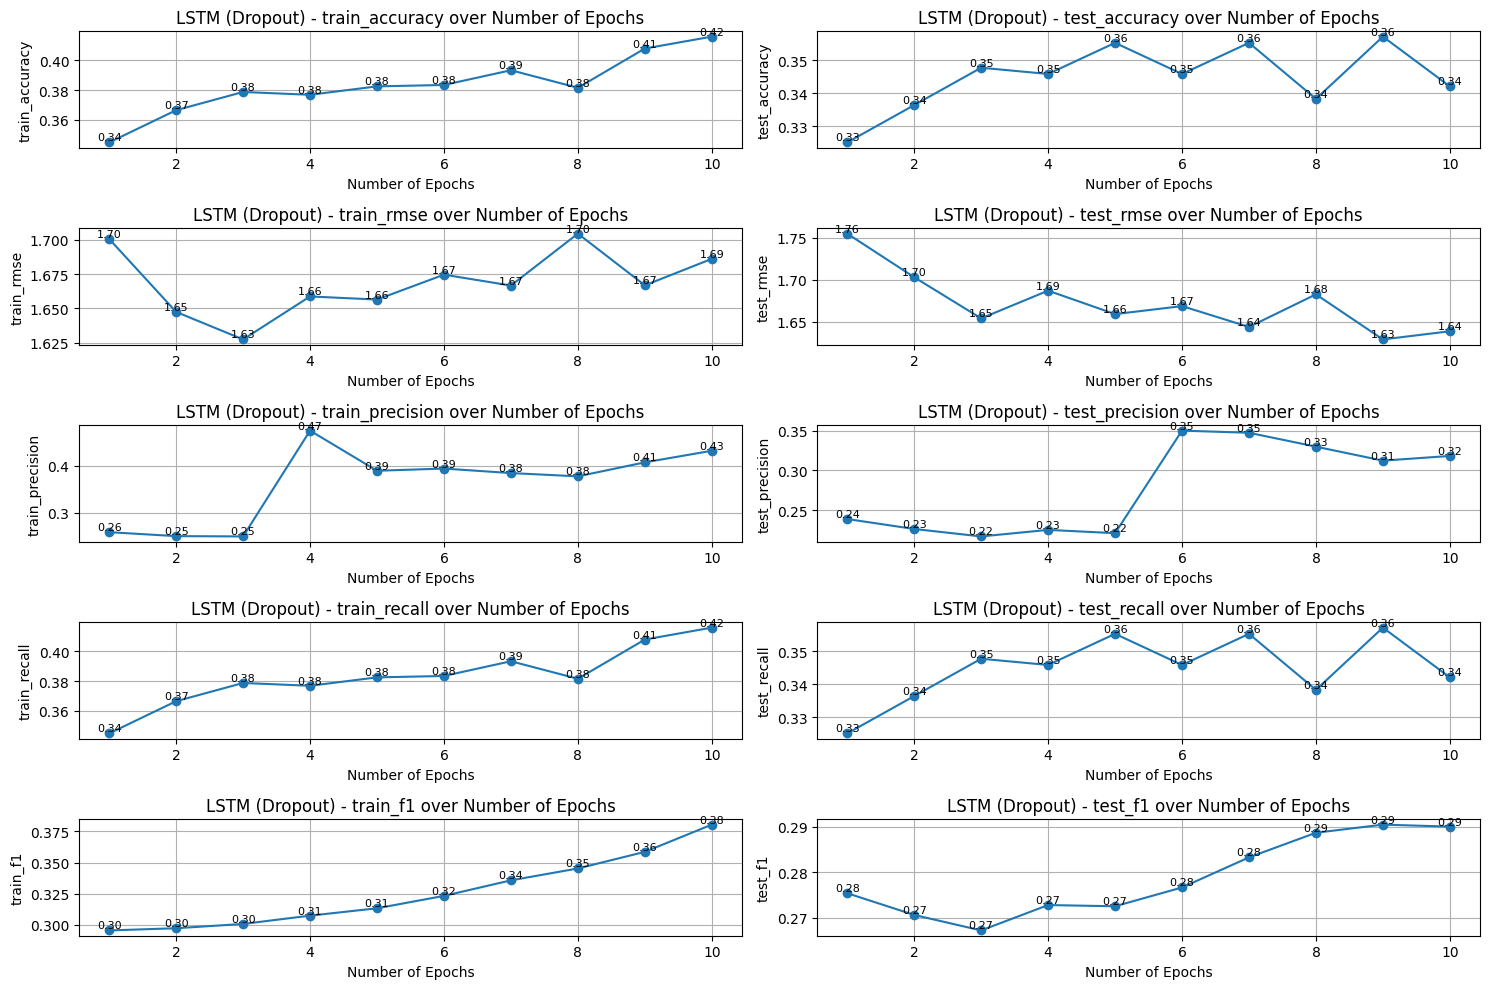

Plotting Metric: train_accuracy
Metric Data: [0.4718045112781955, 0.5093984962406015, 0.5084586466165414, 0.5042293233082706, 0.5051691729323309, 0.5075187969924813, 0.5056390977443609]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: test_accuracy
Metric Data: [0.4793233082706767, 0.4981203007518797, 0.4699248120300752, 0.4830827067669173, 0.4774436090225564, 0.4906015037593985, 0.47368421052631576]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: train_rmse
Metric Data: [0.9286075759303216, 0.9334027006087776, 0.9293663456954304, 0.9316389471353959, 0.9303770761145174, 0.9344090649987722, 0.9293663456954304]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: test_rmse
Metric Data: [0.8958970805552212, 0.8916909677432464, 0.897992749104139, 0.8906363358334124, 0.8874649204122979, 0.8800205055710713, 0.8895804536176852]
Parameter Values: [10, 50, 100, 150, 200, 250, 300]
Plotting Metric: train_precision
Metric Data: [0.569277114

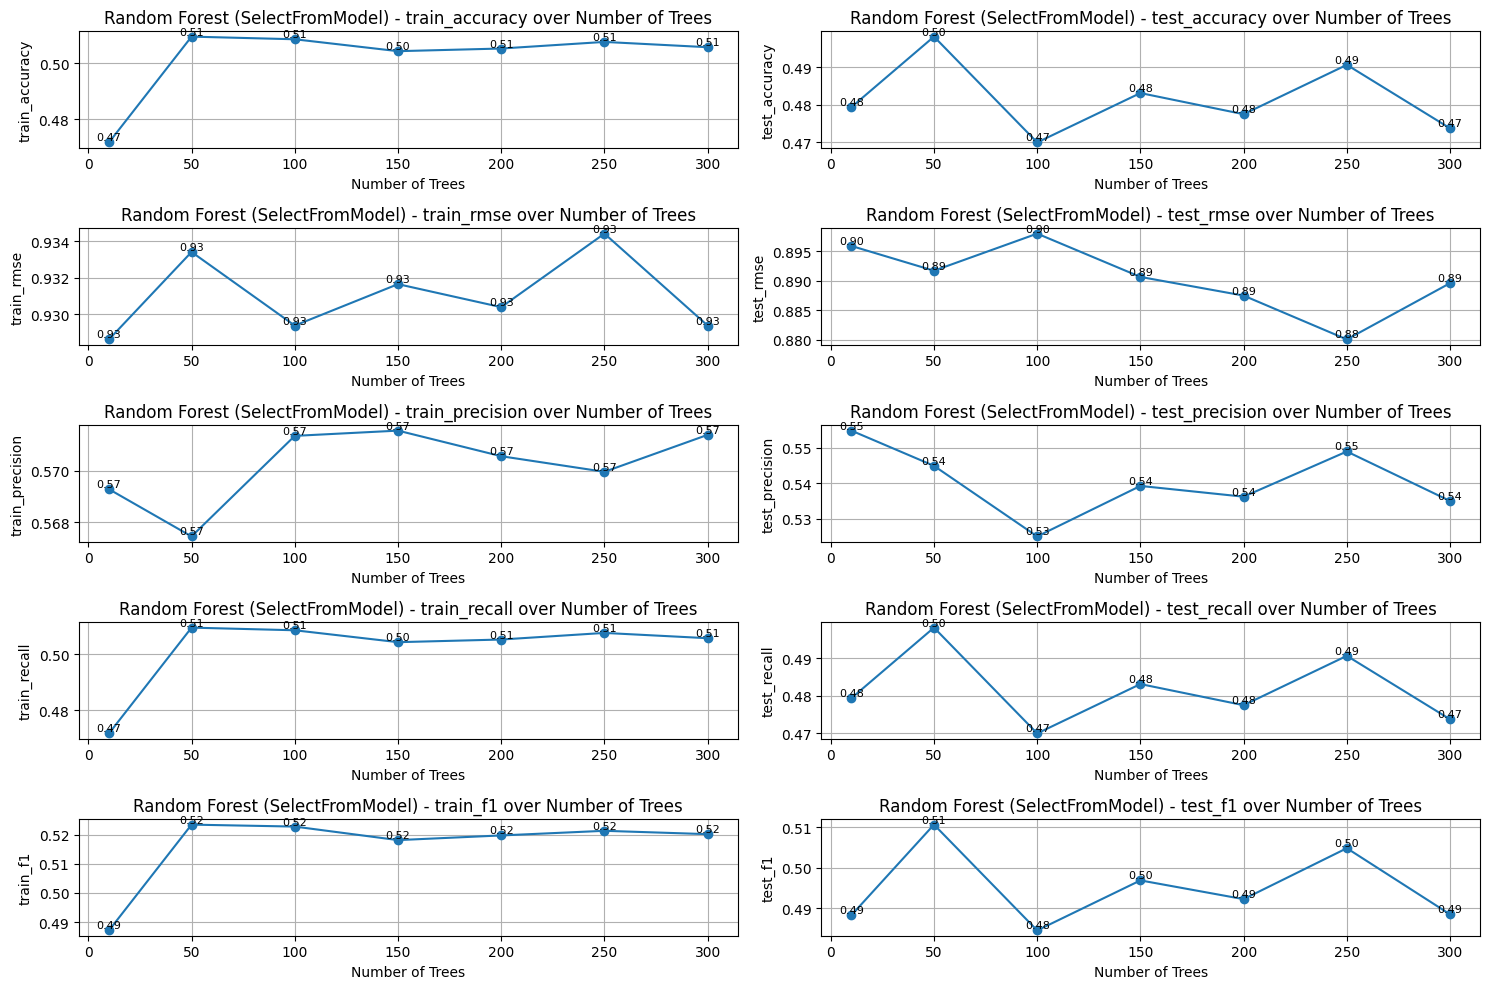

In [109]:
# Define parameter ranges
iterations = np.arange(0, 200, 10)
c_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
epochs = range(1, 11)
n_estimators = [10, 50, 100, 150, 200, 250, 300]
def get_metrics(metrics_obj):
    if isinstance(metrics_obj, tuple):
        return metrics_obj[0]
    return metrics_obj
# Plot metrics for regularized models
trainer.plot_metrics(get_metrics(metrics_logistic_l1), "Logistic Regression (Lasso)", 
                    param_values=iterations,
                    param_name="Number of Iterations")

trainer.plot_metrics(get_metrics(metrics_logistic_l2), "Logistic Regression (Ridge)", 
                    param_values=iterations,
                    param_name="Number of Iterations")

trainer.plot_metrics(get_metrics(metrics_logistic_l1_l2), "Logistic Regression (Elastic Net)", 
                    param_values=iterations,
                    param_name="Number of Iterations")

trainer.plot_metrics(get_metrics(metrics_svm_l1), "SVM (L1)", 
                    param_values=c_values,
                    param_name="Regularization Parameter (C)")

trainer.plot_metrics(get_metrics(metrics_svm_l2), "SVM (L2)", 
                    param_values=c_values,
                    param_name="Regularization Parameter (C)")

trainer.plot_metrics(get_metrics(metrics_lstm_l1), "LSTM (Lasso)", 
                    param_values=epochs,
                    param_name="Number of Epochs")

trainer.plot_metrics(get_metrics(metrics_lstm_l2), "LSTM (Ridge)", 
                    param_values=epochs,
                    param_name="Number of Epochs")

trainer.plot_metrics(get_metrics(metrics_lstm_l1_l2), "LSTM (Elastic Net)", 
                    param_values=epochs,
                    param_name="Number of Epochs")

trainer.plot_metrics(get_metrics(metrics_lstm_dropout), "LSTM (Dropout)", 
                    param_values=epochs,
                    param_name="Number of Epochs")


trainer.plot_metrics(get_metrics(metrics_rf_l1), "Random Forest (SelectFromModel)", 
                    param_values=n_estimators,
                    param_name="Number of Trees")



## Model Optimisation

In this section we use the HyperparameterOptimization class to implement and run grid search with 5-fold cross-validation for model optimization. 

In [110]:

class HyperparameterOptimization:
    def __init__(self, X_train, y_train, X_test, y_test, cv=5, n_jobs=-1):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cv = cv
        self.n_jobs = n_jobs
        self.initial_scores = {}
        
    def get_param_grid(self, model_type):
        param_grids = {
            # Logistic Regression Variants
            "Basic Logistic Regression": {
                'max_iter': [100, 300, 500, 1000],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': ['balanced', None],
                'warm_start': [True, False],
                'tol': [1e-4, 1e-3],
                'solver': ['lbfgs', 'newton-cg', 'sag'],
                'multi_class': ['ovr', 'multinomial']
            },
            "Logistic Regression Manual": {
                'max_iter': [100, 300, 500, 1000],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': ['balanced', None],
                'tol': [1e-4, 1e-3],
                'solver': ['lbfgs', 'newton-cg', 'sag'],
                'multi_class': ['ovr', 'multinomial']
            },
            "L1 Logistic Regression": {
                'max_iter': [100, 300, 500, 1000],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': ['balanced', None],
                'tol': [1e-4, 1e-3],
                'solver': ['liblinear', 'saga'],
                'penalty': ['l1'],
                'dual': [False]
            },
            "L2 Logistic Regression": {
                'max_iter': [100, 300, 500, 1000],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': ['balanced', None],
                'tol': [1e-4, 1e-3],
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                'penalty': ['l2']
            },
            "Logistic Regression L1 L2": {
                'max_iter': [100, 300, 500, 1000],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                'class_weight': ['balanced', None],
                'tol': [1e-4, 1e-3],
                'solver': ['saga'],
                'penalty': ['elasticnet']
            },

            # KNN Variants
            "Basic KNN": {
                'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski'],
                'p': [1, 2],
                'leaf_size': [20, 30, 40]
            },
            "KNN Manual": {
                'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski'],
                'p': [1, 2],
                'leaf_size': [20, 30, 40]
            },

            # SVM Variants
            "Basic SVM": {
                'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'class_weight': ['balanced', None],
                'degree': [2, 3],
                'coef0': [0.0, 1.0],
                'tol': [1e-4, 1e-3]
            },
            "SVM Manual": {
                'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'class_weight': ['balanced', None],
                'tol': [1e-4, 1e-3]
            },
            "L1 SVM": {
                'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                'class_weight': ['balanced', None],
                'tol': [1e-4, 1e-3],
                'dual': [False],
                'penalty': ['l1'],
                'max_iter': [1000, 2000]
            },
            "L2 SVM": {
                'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                'class_weight': ['balanced', None],
                'tol': [1e-4, 1e-3],
                'dual': [True, False],
                'penalty': ['l2'],
                'max_iter': [1000, 2000]
            },

            # LSTM Variants
            "Basic LSTM": {
                'units': [256],
                'learning_rate': [0.001, 0.01],
                'batch_size': [64],
                'epochs': [15]
            },
            "LSTM Manual": {
                'units': [256],
                'learning_rate': [0.001, 0.01],
                'batch_size': [64],
                'epochs': [15]
            },
            "L1 LSTM": {
                'l1_penalty': [0.01, 0.001],
                'units': [256],
                'learning_rate': [0.001, 0.01],
                'batch_size': [64],
                'epochs': [15]
            },
            "L2 LSTM": {
                'units': [256],
                'l1_penalty': [0.01, 0.001],
                'learning_rate': [0.001, 0.01],
                'batch_size': [64],
                'epochs': [15]
            },
            "L1 & L2 LSTM": {
                'units': [256],
                'l1_penalty': [0.01, 0.001],
                'learning_rate': [0.001, 0.01],
                'batch_size': [64],
                'epochs': [15]
            },
            "Dropout LSTM": {
                'units': [256],
                'dropout_rate': [0.2, 0.3],
                'learning_rate': [0.001, 0.01],
                'batch_size': [64],
                'epochs': [15]
            },

            # Random Forest Variants
            "Basic Random Forest": {
                'n_estimators': [100],         
                'max_depth': [4, 6, 8, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None],
                'bootstrap': [True, False],
                'class_weight': ['balanced', 'balanced_subsample', None]
            },
            "Random Forest Manual": {
                'n_estimators': [100],     
                'max_depth': [4, 6, 8, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None],
                'bootstrap': [True, False],
                'class_weight': ['balanced', 'balanced_subsample', None]
            },
            "Embedded Feature Selection Random Forest": {
                'rf__n_estimators': [100],     
                'rf__max_depth': [4, 6, 8, None],
                'rf__min_samples_split': [2, 5, 10],
                'rf__min_samples_leaf': [1, 2, 4],
                'rf__max_features': ['sqrt', 'log2', None],
                'rf__bootstrap': [True, False],
                'rf__class_weight': ['balanced', 'balanced_subsample', None]
            }
        }
        
        return param_grids.get(model_type, {})
    
    def _get_initial_score(self, model, model_name):
        model.fit(self.X_train, self.y_train)
        initial_score = model.score(self.X_test, self.y_test)
        self.initial_scores[model_name] = initial_score
        return initial_score
    
    def _run_grid_search(self, model, model_name):
        param_grid = self.get_param_grid(model_name)
        
        initial_score = self._get_initial_score(model, model_name)
        
        if not param_grid:
            print("Error: param_grid is empty")
            return None
            
        try:
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=self.cv,
                n_jobs=self.n_jobs,
                scoring='accuracy',
                verbose=1
            )
            
            grid_search.fit(self.X_train, self.y_train)
            
            test_score = grid_search.score(self.X_test, self.y_test)
            print(f"Test score: {test_score}")
            
            return {
                'model': grid_search.best_estimator_,
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'test_score': test_score,
                'initial_score': initial_score
            }
                    
        except Exception as e:
            print(f"Error during grid search: {str(e)}")
            print(f"Model: {model}")
            print(f"Param grid: {param_grid}")
            return None
        
    def _run_keras_grid_search(self, create_model, model_name):
        print(f"\nOptimizing {model_name}...")
        
        # config gpu
        try:
            physical_devices = tf.config.list_physical_devices('GPU')
            if physical_devices:
                for device in physical_devices:
                    tf.config.experimental.set_memory_growth(device, True)
                print("GPU configured for training")
        except Exception as e:
            print("GPU configuration warning:", str(e))
        
        param_grid = self.get_param_grid(model_name)
        
        # reshape for lstm
        X_train_reshaped = self.X_train.values.reshape((self.X_train.shape[0], 1, self.X_train.shape[1]))
        X_test_reshaped = self.X_test.values.reshape((self.X_test.shape[0], 1, self.X_test.shape[1]))
        
        y_train_cat = to_categorical(self.y_train, num_classes=3)
        y_test_cat = to_categorical(self.y_test, num_classes=3)
        
        best_score = float('-inf')
        best_model = None
        best_params = None
        
        # Use GPU explicitly
        with tf.device('/GPU:0'):
            initial_model = create_model()
            
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
            
            print("Training initial model on GPU...")
            initial_model.fit(
                X_train_reshaped, 
                y_train_cat,
                batch_size=256,  # better w larger for gpu
                epochs=10,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1
            )
            
            initial_score = initial_model.evaluate(X_test_reshaped, y_test_cat, verbose=0)[1]
            print(f"Initial model score: {initial_score}")
            
            # gridsrech with gpu
            param_combinations = [dict(zip(param_grid.keys(), v)) 
                                for v in itertools.product(*param_grid.values())]
            
            for params in tqdm(param_combinations, desc=f"Testing {model_name} configurations"):
                try:
                    model = create_model(**{k: v for k, v in params.items() 
                                        if k not in ['batch_size', 'epochs']})
                    
                    history = model.fit(
                        X_train_reshaped, 
                        y_train_cat,
                        batch_size=params.get('batch_size', 256),  
                        epochs=params.get('epochs', 10),
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=1 
                    )
                    
                    score = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)[1]
                    
                    if score > best_score:
                        best_score = score
                        best_model = model
                        best_params = params
                        print(f"\nNew best score: {best_score} with params: {best_params}")
                        
                except Exception as e:
                    print(f"Error with parameters {params}: {str(e)}")
                    continue

        return {
            'model': best_model,
            'best_params': best_params,
            'best_score': best_score,
            'test_score': best_score,
            'initial_score': initial_score
        }
    def optimize_logistic_regression(self):
        model = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            random_state=31
        )
        return self._run_grid_search(model, "Basic Logistic Regression")

    def optimize_logistic_regression_l1(self):
        model = LogisticRegression(
            penalty='l1',
            solver='liblinear',
            random_state=31
        )
        return self._run_grid_search(model, "L1 Logistic Regression")

    def optimize_logistic_regression_l2(self):
        model = LogisticRegression(
            penalty='l2',
            solver='lbfgs',
            random_state=31
        )
        return self._run_grid_search(model, "L2 Logistic Regression")

    def optimize_knn(self):
        model = KNeighborsClassifier()
        return self._run_grid_search(model, "Basic KNN")

    def optimize_svm(self):
        model = SVC(kernel='linear', random_state=31)
        return self._run_grid_search(model, "Basic SVM")

    def optimize_svm_l1(self):
        model = LinearSVC(penalty='l1', dual=False, random_state=31)
        return self._run_grid_search(model, "L1 SVM")

    def optimize_svm_l2(self):
        model = LinearSVC(penalty='l2', dual=True, random_state=31)
        return self._run_grid_search(model, "L2 SVM")

    def optimize_lstm(self):
        def create_model(units=64, learning_rate=0.001):
            model = Sequential([
                LSTM(units, input_shape=(1, self.X_train.shape[1]), return_sequences=True),
                LSTM(units, return_sequences=False),
                Dense(3, activation='softmax')
            ])
            model.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )
            return model
        return self._run_keras_grid_search(create_model, "Basic LSTM")

    def optimize_lstm_l1(self):
        def create_model(units=64, l1_penalty=0.01, learning_rate=0.001):
            model = Sequential([
                LSTM(units, input_shape=(1, self.X_train.shape[1]),
                     return_sequences=True,
                     kernel_regularizer=regularizers.l1(l1_penalty)),
                LSTM(units, return_sequences=False,
                     kernel_regularizer=regularizers.l1(l1_penalty)),
                Dense(3, activation='softmax')
            ])
            model.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )
            return model
        return self._run_keras_grid_search(create_model, "L1 LSTM")

    def optimize_lstm_l2(self):
        def create_model(units=64, l2_penalty=0.01, learning_rate=0.001):
            model = Sequential([
                LSTM(units, input_shape=(1, self.X_train.shape[1]),
                     return_sequences=True,
                     kernel_regularizer=regularizers.l2(l2_penalty)),
                LSTM(units, return_sequences=False,
                     kernel_regularizer=regularizers.l2(l2_penalty)),
                Dense(3, activation='softmax')
            ])
            model.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )
            return model
        return self._run_keras_grid_search(create_model, "L2 LSTM")

    def optimize_random_forest(self):
        model = RandomForestClassifier(
                max_depth=4,
                min_samples_split=50,
                min_samples_leaf=25,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            )
        return self._run_grid_search(model, "Basic Random Forest")

    def optimize_random_forest_embedded(self):
        base_model = model = RandomForestClassifier(
                max_depth=4,
                min_samples_split=50,
                min_samples_leaf=25,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            )
        
        model = Pipeline([
            ('selector', SelectFromModel(
                estimator=base_model,
                max_features=20,
                threshold=-np.inf
            )),
            ('rf', RandomForestClassifier(
                max_depth=4,
                min_samples_split=50,
                min_samples_leaf=25,
                max_features='sqrt',
                class_weight='balanced',
                random_state=42
            ))
        ])
        
        return self._run_grid_search(model, "Embedded Feature Selection Random Forest")
    
    def optimize_logistic_regression_manual(self):
        model = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            random_state=31
        )
        return self._run_grid_search(model, "Logistic Regression Manual")

    def optimize_logistic_regression_l1_l2(self):
        model = LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            random_state=31,
            l1_ratio=0.1  
        )
        return self._run_grid_search(model, "Logistic Regression L1 L2")

    def optimize_knn_manual(self):
        model = KNeighborsClassifier()
        return self._run_grid_search(model, "KNN Manual")

    def optimize_svm_manual(self):
        model = SVC(kernel='linear', random_state=31)
        return self._run_grid_search(model, "SVM Manual")

    def optimize_lstm_manual(self):
        def create_model(units=64, learning_rate=0.001):
            model = Sequential([
                LSTM(units, input_shape=(1, self.X_train.shape[1]), return_sequences=True),
                LSTM(units, return_sequences=False),
                Dense(3, activation='softmax')
            ])
            model.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )
            return model
        return self._run_keras_grid_search(create_model, "LSTM Manual")

    def optimize_lstm_l1_l2(self):
        def create_model(units=64, l1_l2_penalty=0.01, learning_rate=0.001):
            model = Sequential([
                LSTM(units, input_shape=(1, self.X_train.shape[1]),
                    return_sequences=True,
                    kernel_regularizer=regularizers.l1_l2(l1=l1_l2_penalty, l2=l1_l2_penalty)),
                LSTM(units, return_sequences=False,
                    kernel_regularizer=regularizers.l1_l2(l1=l1_l2_penalty, l2=l1_l2_penalty)),
                Dense(3, activation='softmax')
            ])
            model.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )
            return model
        return self._run_keras_grid_search(create_model, "L1 & L2 LSTM")

    def optimize_random_forest_manual(self):
        model = RandomForestClassifier(
            max_features='sqrt',
            class_weight='balanced',
            random_state=42,

        )
        return self._run_grid_search(model, "Random Forest Manual")
    
    def optimize_lstm_dropout(self):
        def create_model(units=64, dropout_rate=0.2, learning_rate=0.001):
            model = Sequential([
                LSTM(units, 
                    input_shape=(1, self.X_train.shape[1]),
                    return_sequences=True,
                    dropout=dropout_rate),
                LSTM(units,
                    return_sequences=False,
                    dropout=dropout_rate),
                Dense(3, activation='softmax')
            ])
            
            model.compile(
                loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['accuracy']
            )
            return model
        
        return self._run_keras_grid_search(create_model, "Dropout LSTM")
            

In [114]:

class ModelOptimizationManager:
    def __init__(self, base_data, feature_selected_data):
        self.base_data = base_data
        self.feature_selected_data = feature_selected_data
        self.results = {}
        self.base_optimizer = HyperparameterOptimization(*self.base_data)
        
        self.models = [
            # Logistic Regression variants
            ('logistic_base', 'Basic Logistic Regression', self.base_optimizer.optimize_logistic_regression),
            ('logistic_manual', 'Logistic Regression (manual feature selection)', 
             lambda: HyperparameterOptimization(*self.feature_selected_data['logistic']).optimize_logistic_regression()),
            ('logistic_l1', 'Logistic Regression (l1 regularisation)', self.base_optimizer.optimize_logistic_regression_l1),
            ('logistic_l2', 'Logistic Regression (l2 regularisation)', self.base_optimizer.optimize_logistic_regression_l2),
            ('logistic_l1_l2', 'Logistic Regression L1 L2', 
         self.base_optimizer.optimize_logistic_regression_l1_l2),
            
            #KNN variants
            ('knn_base', 'K Nearest Neighbours', self.base_optimizer.optimize_knn),
            ('knn_manual', 'K Nearest Neighbours (manual feature selection)', 
             lambda: HyperparameterOptimization(*self.feature_selected_data['knn']).optimize_knn()),
            
            # SVM variants
            ('svm_base', 'Support Vector Machine', self.base_optimizer.optimize_svm),
            ('svm_manual', 'Support Vector Machine (manual feature selection)', 
             lambda: HyperparameterOptimization(*self.feature_selected_data['svm']).optimize_svm()),
            ('svm_l1', 'Support Vector Machine (l1 regularisation)', self.base_optimizer.optimize_svm_l1),
            ('svm_l2', 'Support Vector Machine (l2 regularisation)', self.base_optimizer.optimize_svm_l2),
            
            # LSTM variants
            ('lstm_base', 'Long Short Term Memory', self.base_optimizer.optimize_lstm),
            ('lstm_manual', 'Long Short Term Memory (manual feature selection)', 
             lambda: HyperparameterOptimization(*self.feature_selected_data['lstm']).optimize_lstm()),
            ('lstm_l1', 'Long Short Term Memory (l1 regularisation)', self.base_optimizer.optimize_lstm_l1),
            ('lstm_l2', 'Long Short Term Memory (l2 regularisation)', self.base_optimizer.optimize_lstm_l2),
            ('lstm_elastic', 'Long Short Term Memory (l1 & l2 regularisation)', self.base_optimizer.optimize_lstm_l1_l2),
            ('lstm_dropout', 'Long Short Term Memory (dropout regularisation)', self.base_optimizer.optimize_lstm_dropout),
            
            # Random Forest variants
            ('rf_base', 'Random Forest', 
                self.base_optimizer.optimize_random_forest),
            ('rf_embedded', 'Random Forest (embedded feature selection)', 
                self.base_optimizer.optimize_random_forest_embedded),
            ('rf_manual', 'Random Forest (manual feature selection)', 
                lambda: HyperparameterOptimization(*self.feature_selected_data['rf']).optimize_random_forest())
        ]
        
    def run_all_optimizations(self):
        total = len(self.models)
        
        for i, (model_key, model_name, optimization_func) in enumerate(self.models, 1):
            try:
                print(f"\nOptimizing model {i}/{total}: {model_name}")
                self.results[model_key] = self._run_and_collect(optimization_func, model_name)
                print(f"Completed {i}/{total} models")
            except Exception as e:
                print(f"\nError optimizing {model_name}: {str(e)}")
                continue
                
        return self.results
    
    def optimize_models(self, model_names):
        results = {}
        
        selected_models = [
            (key, name, func) for key, name, func in self.models 
            if name in model_names
        ]
        
        total = len(selected_models)
        for i, (model_key, model_name, optimization_func) in enumerate(selected_models, 1):
            try:
                print(f"\nOptimizing model {i}/{total}: {model_name}")
                results[model_key] = self._run_and_collect(optimization_func, model_name)
                print(f"Completed {i}/{total} models")
            except Exception as e:
                print(f"\nError optimizing {model_name}: {str(e)}")
                continue
                
        return results

    def _run_and_collect(self, optimization_func, model_name):
        """Run optimization and collect results"""
        print(f"\nOptimizing {model_name}...")
        result = optimization_func()
        return {
            'model': result['model'],
            'params': result['best_params'],
            'cv_score': result['best_score'],
            'test_score': result['test_score'],
            'initial_score': result['initial_score']
        }

In [117]:

base_data = (first_X_train, first_y_train, first_X_test, first_y_test)

feature_selected_data = {
    'logistic': (logistic_X_train, logistic_y_train, logistic_X_test, logistic_y_test),
    'knn': (knn_X_train, knn_y_train, knn_X_test, knn_y_test),
    'svm': (svm_X_train, svm_y_train, svm_X_test, svm_y_test),
    'lstm': (lstm_X_train, lstm_y_train, lstm_X_test, lstm_y_test),
    'rf': (rf_X_train, rf_y_train, rf_X_test, rf_y_test)
}

optimizer = ModelOptimizationManager(base_data, feature_selected_data)
optimization_results = optimizer.run_all_optimizations()




Optimizing model 1/20: Basic Logistic Regression

Optimizing Basic Logistic Regression...
Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Test score: 0.5394736842105263
Completed 1/20 models

Optimizing model 2/20: Logistic Regression (manual feature selection)

Optimizing Logistic Regression (manual feature selection)...
Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Test score: 0.5206766917293233
Completed 2/20 models

Optimizing model 3/20: Logistic Regression (l1 regularisation)

Optimizing Logistic Regression (l1 regularisation)...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits


/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Test score: 0.5357142857142857
Completed 3/20 models

Optimizing model 4/20: Logistic Regression (l2 regularisation)

Optimizing Logistic Regression (l2 regularisation)...
Fitting 5 folds for each of 448 candidates, totalling 2240 fits


/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Test score: 0.5319548872180451
Completed 4/20 models

Optimizing model 5/20: Logistic Regression L1 L2

Optimizing Logistic Regression L1 L2...
Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lukemciver/football/new_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Test score: 0.5263157894736842
Completed 5/20 models

Optimizing model 6/20: K Nearest Neighbours

Optimizing K Nearest Neighbours...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Test score: 0.48120300751879697
Completed 6/20 models

Optimizing model 7/20: K Nearest Neighbours (manual feature selection)

Optimizing K Nearest Neighbours (manual feature selection)...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Test score: 0.48872180451127817
Completed 7/20 models

Optimizing model 8/20: Support Vector Machine

Optimizing Support Vector Machine...
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


After running the optimisations, we plot the results.

In [ ]:
def save_optimization_results(base_data, feature_selected_data, optimization_results, timestamp=None):
    if timestamp is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create directory if it doesn't exist
    os.makedirs('saved_data', exist_ok=True)
    os.makedirs('saved_data/models', exist_ok=True)
    
    # Save base data
    joblib.dump(base_data, f'saved_data/base_data_{timestamp}.pkl')
    
    # Save feature selected data
    joblib.dump(feature_selected_data, f'saved_data/feature_selected_data_{timestamp}.pkl')
    
    # Process and save optimization results
    processed_results = {}
    for model_key, result in optimization_results.items():
        if result is not None:
            # Handle Keras models separately
            if isinstance(result.get('model'), tf.keras.Model):
                # Save Keras model separately
                model_path = f'saved_data/models/{model_key}_{timestamp}'
                result['model'].save(model_path)
                # Store the path instead of the model
                processed_results[model_key] = {
                    'model_path': model_path,
                    'is_keras': True,
                    'params': result.get('params', {}),
                    'cv_score': result.get('cv_score'),
                    'test_score': result.get('test_score'),
                    'initial_score': result.get('initial_score')
                }
            else:
                # Handle non-Keras models
                processed_results[model_key] = {
                    'model': result.get('model'),
                    'is_keras': False,
                    'params': result.get('params', {}),
                    'cv_score': result.get('cv_score'),
                    'test_score': result.get('test_score'),
                    'initial_score': result.get('initial_score')
                }
    
    joblib.dump(processed_results, f'saved_data/optimization_results_{timestamp}.pkl')
    print(f"\nData saved with timestamp: {timestamp}")
    return timestamp

def inspect_optimization_results(optimization_results):

    print("\nOptimization Results Structure:")
    for model_key, result in optimization_results.items():
        print(f"\nModel: {model_key}")
        if result is not None:
            print("Available keys:", list(result.keys()))
            for key, value in result.items():
                print(f"  {key}: {type(value)}")
        else:
            print("  Result is None")

inspect_optimization_results(optimization_results)
optimization_timestamp = save_optimization_results(base_data, feature_selected_data, optimization_results)

In [112]:
class OptimizationVisualizer:
    def __init__(self, optimization_results):
        self.optimization_results = optimization_results
        
    def format_results(self):
        data = {
            'Model': [],
            'Base Score': [],
            'Optimized Score': [],
            'Improvement': []
        }
        
        for model_name, results in self.optimization_results.items():
            if results is not None: 
                data['Model'].append(model_name)
                data['Base Score'].append(results.get('initial_score', 0))
                data['Optimized Score'].append(results.get('test_score', 0))
                data['Improvement'].append(
                    results.get('test_score', 0) - results.get('initial_score', 0)
                )
        
        return pd.DataFrame(data)
    
    def plot_improvements(self):
        df = self.format_results()
        
        plt.figure(figsize=(15, 8))
        
        # bar positions
        x = np.arange(len(df['Model']))
        
        # stacked bars with dark blue base and light blue improvements
        plt.bar(x, df['Base Score'], 
                label='Base Score', color='darkblue')
        plt.bar(x, df['Improvement'], bottom=df['Base Score'],
                label='Improvement', color='lightblue')
        
        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Model Performance with Optimization Improvements')
        plt.xticks(x, df['Model'], rotation=45, ha='right')
        plt.legend()
        
        for i in x:
            plt.text(i, df['Base Score'].iloc[i]/2, 
                    f"{df['Base Score'].iloc[i]:.3f}", 
                    ha='center', va='center',
                    color='white')  
            
            if df['Improvement'].iloc[i] > 0:
                plt.text(i, df['Base Score'].iloc[i] + df['Improvement'].iloc[i]/2,
                        f"+{df['Improvement'].iloc[i]:.3f}", 
                        ha='center', va='center',
                        color='black')  
        
        plt.tight_layout()
        plt.show()
    
        
        return df

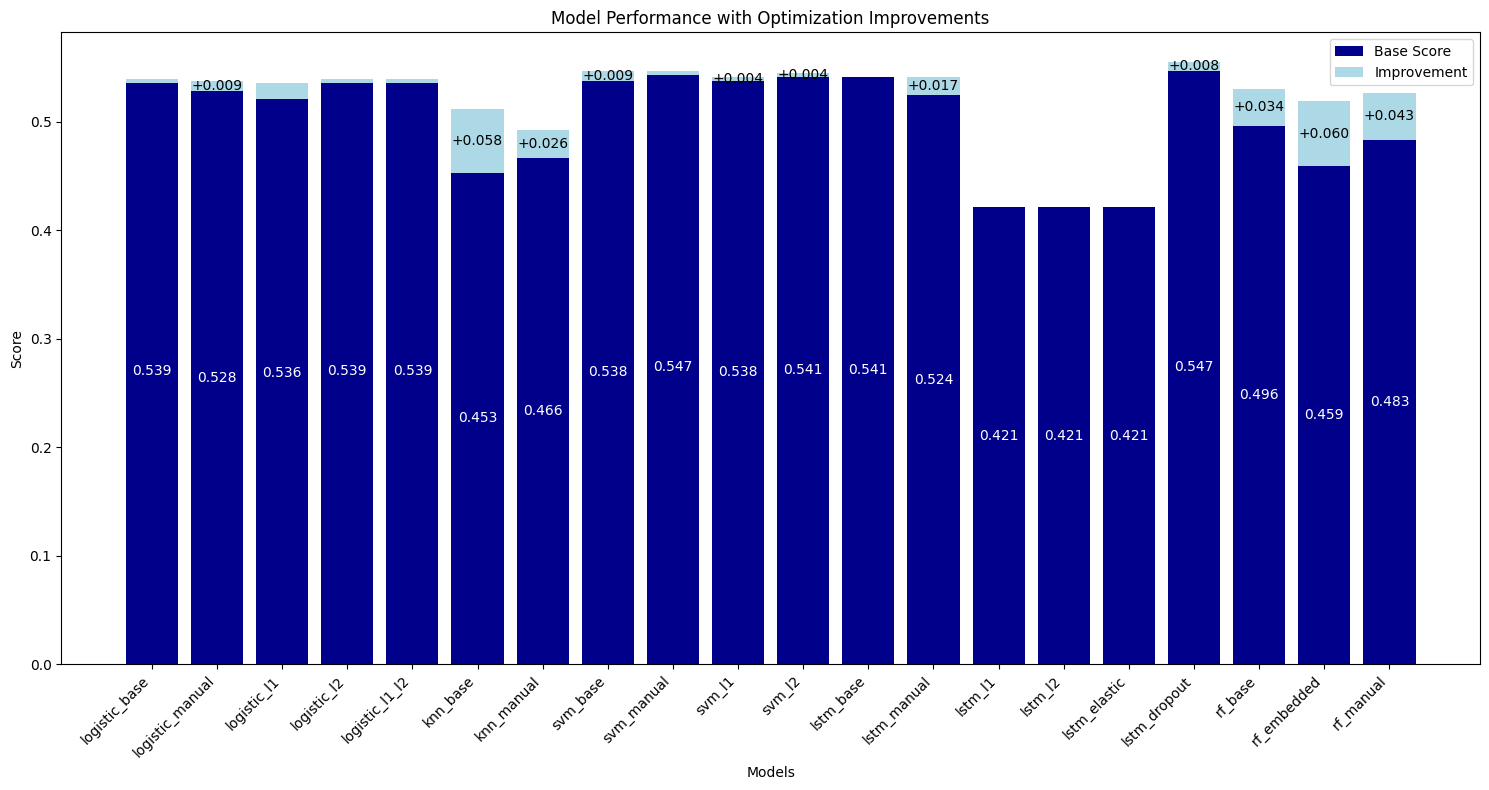

In [59]:
# create visualizer and plot results
visualizer = OptimizationVisualizer(optimization_results)
results_df = visualizer.plot_improvements()

We extract the best performing models from each family to analyze

In [70]:
def extract_best_models(optimization_results):
    
    model_families = {
        'logistic': [],
        'knn': [],
        'svm': [],
        'lstm': [],
        'rf': []
    }
    
    # group models by family
    for model_name, result in optimization_results.items():
        if result is None:
            continue
            
        family = model_name.split('_')[0]
        if family in model_families:
            model_families[family].append({
                'name': model_name,
                'score': result['test_score'],
                'model': result['model'],
                'params': result['params']
            })
    
    # find best model in each family
    best_models = {}
    print("Best Models Summary:")
    print("=" * 50)
    
    for family, models in model_families.items():
        if models:
            best_model = max(models, key=lambda x: x['score'])
            best_models[family] = best_model
            
            print(f"\nBest {family.upper()} Model:")
            print(f"Variant: {best_model['name']}")
            print(f"Test Score: {best_model['score']:.4f}")
            print(f"Parameters: {best_model['params']}")
            print("-" * 50)
    
    return best_models

best_models = extract_best_models(optimization_results)

Best Models Summary:

Best LOGISTIC Model:
Variant: logistic_manual
Test Score: 0.5376
Parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs', 'tol': 0.0001, 'warm_start': True}
--------------------------------------------------

Best KNN Model:
Variant: knn_base
Test Score: 0.5113
Parameters: {'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
--------------------------------------------------

Best SVM Model:
Variant: svm_base
Test Score: 0.5470
Parameters: {'C': 0.1, 'class_weight': None, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}
--------------------------------------------------

Best LSTM Model:
Variant: lstm_dropout
Test Score: 0.5545
Parameters: {'units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 15}
--------------------------------------------------

Best RF Model:
Variant: rf_base
Test Score: 0.5301
Parameters: {

Prepare all data we need to analyze models, including dictionary of best models

In [71]:
feature_selected_data = {
    'logistic': (logistic_X_train, logistic_y_train, logistic_X_test, logistic_y_test),
    'knn': (knn_X_train, knn_y_train, knn_X_test, knn_y_test),
    'svm': (svm_X_train, svm_y_train, svm_X_test, svm_y_test),
    'lstm': (lstm_X_train, lstm_y_train, lstm_X_test, lstm_y_test),
    'rf': (rf_X_train, rf_y_train, rf_X_test, rf_y_test)
}

base_data = (first_X_train, first_y_train, first_X_test, first_y_test)
best_models = extract_best_models(optimization_results)


Best Models Summary:

Best LOGISTIC Model:
Variant: logistic_manual
Test Score: 0.5376
Parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs', 'tol': 0.0001, 'warm_start': True}
--------------------------------------------------

Best KNN Model:
Variant: knn_base
Test Score: 0.5113
Parameters: {'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
--------------------------------------------------

Best SVM Model:
Variant: svm_base
Test Score: 0.5470
Parameters: {'C': 0.1, 'class_weight': None, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}
--------------------------------------------------

Best LSTM Model:
Variant: lstm_dropout
Test Score: 0.5545
Parameters: {'units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 15}
--------------------------------------------------

Best RF Model:
Variant: rf_base
Test Score: 0.5301
Parameters: {

Now that the best models from each class (LR, KNN, SVM, LSTM, RF) have been found, we will begin to evaluate this subset of models.

Firstly, we do Kfold validation on the best models.

In [50]:

class ModelKFoldValidator:
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
    def validate_models(self, best_models, feature_selected_data, base_data):
        results = {}
        
        for family, model_info in best_models.items():
            
            if 'manual' in model_info['name'].lower():
                X_train, y_train, _, _ = feature_selected_data[family]
            else:
                X_train, y_train, _, _ = base_data
            
            fold_metrics = {
                'accuracy': [], 'precision': [], 'recall': [], 
                'f1': [], 'rmse': []
            }
            
            for fold, (train_idx, val_idx) in enumerate(self.kf.split(X_train), 1):
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                # handle model fitting based on type
                if isinstance(model_info['model'], Sequential):
                    model = self._create_lstm_model(model_info['params'], X_train.shape[1])
                    X_fold_train_reshaped = X_fold_train.values.reshape((X_fold_train.shape[0], 1, X_fold_train.shape[1]))
                    X_fold_val_reshaped = X_fold_val.values.reshape((X_fold_val.shape[0], 1, X_fold_val.shape[1]))
                    y_fold_train_cat = to_categorical(y_fold_train, num_classes=3)
                    
                    model.fit(X_fold_train_reshaped, y_fold_train_cat, 
                            epochs=20, batch_size=64, verbose=0)
                    y_pred = model.predict(X_fold_val_reshaped).argmax(axis=1)
                else:
                    model = clone(model_info['model'])
                    model.fit(X_fold_train, y_fold_train)
                    y_pred = model.predict(X_fold_val)
                
                # calculate metrics
                fold_metrics['accuracy'].append(accuracy_score(y_fold_val, y_pred))
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_fold_val, y_pred, average='weighted'
                )
                fold_metrics['precision'].append(precision)
                fold_metrics['recall'].append(recall)
                fold_metrics['f1'].append(f1)
                fold_metrics['rmse'].append(np.sqrt(np.mean((y_fold_val - y_pred) ** 2)))
                
                print(f"\nFold {fold} Results:")
                for metric, values in fold_metrics.items():
                    print(f"{metric.capitalize()}: {values[-1]:.4f}")
            
            avg_metrics = {
                f"avg_{metric}": np.mean(values) 
                for metric, values in fold_metrics.items()
            }
            avg_metrics.update({
                f"std_{metric}": np.std(values) 
                for metric, values in fold_metrics.items()
            })
            
            results[family] = {
                'fold_metrics': fold_metrics,
                'avg_metrics': avg_metrics
            }

        self.plot_comparative_results(results)
        
        return results

    def _create_lstm_model(self, params, input_dim):
        """Helper method to create new LSTM model instance"""
        units = params.get('units', 64)
        model = Sequential([
            LSTM(units, input_shape=(1, input_dim), return_sequences=True),
            LSTM(units, return_sequences=False),
            Dense(3, activation='softmax')
        ])
        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=params.get('learning_rate', 0.001)),
            metrics=['accuracy']
        )
        return model

    def plot_comparative_results(self, results):
        plt.figure(figsize=(12, 6))
        
        models = list(results.keys())
        accuracies = [results[model]['avg_metrics']['avg_accuracy'] for model in models]
        errors = [results[model]['avg_metrics']['std_accuracy'] for model in models]
        
        bars = plt.bar(models, accuracies, yerr=errors, capsize=5)
        
        plt.title('Model Performance Comparison (5-Fold Cross Validation)', pad=20)
        plt.ylabel('Accuracy Score')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        print("\nModel Performance Summary:")
        print("-" * 50)
        for model, acc, err in zip(models, accuracies, errors):
            print(f"{model:<15} Accuracy: {acc:.3f} ± {err:.3f}")
        
        plt.show()

In [ ]:
validator = ModelKFoldValidator(n_splits=5)
validation_results = validator.validate_models(
    best_models=best_models,
    feature_selected_data=feature_selected_data,
    base_data=base_data
)

Then, we plot various metrics for analysis. Full metrics and analysis can be seen in report

In [228]:

class ModelAnalyzer:
    @staticmethod
    def configure_gpu():
        try:
            gpus = tf.config.list_physical_devices('GPU')
            if gpus:
                print(f"Found {len(gpus)} GPU(s)")
                for gpu in gpus:
                    try:
                        tf.config.experimental.set_memory_growth(gpu, True)
                        print(f"Enabled memory growth for {gpu}")
                    except RuntimeError as e:
                        print(f"Memory growth setting failed for {gpu}: {e}")
                        
                with tf.device('/GPU:0'):
                    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
                    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
                    c = tf.matmul(a, b)
                    print("GPU test successful")
                    return True
        except Exception as e:
            print(f"GPU configuration failed: {e}")
            print("Falling back to CPU")
            return False


    def __init__(self, base_data, feature_selected_data, models_dict, output_file="model_analysis_results.txt"):
        self.using_gpu = self.configure_gpu()
        print(f"Using GPU: {self.using_gpu}")
        
        self.X_train, self.y_train, self.X_test, self.y_test = base_data
        self.feature_selected_data = feature_selected_data
        self.models = models_dict
        self.output_file = output_file
        self.results_log = []
        self.learning_scores = {}
        
        if 'lstm' in models_dict:
            if not isinstance(models_dict['lstm']['model'], tf.keras.Model):
                raise ValueError("LSTM model must be a Keras model")
            self.lstm_config = models_dict['lstm'].get('params', {
                'batch_size': 32,
                'epochs': 10
            })

        from matplotlib import gridspec
        self.gridspec = gridspec

    def _prepare_lstm_data(self, X):
        if len(X.shape) == 2:
            return X.reshape((X.shape[0], 1, X.shape[1]))
        return X


    def _get_lstm_predictions(self, y_pred_proba):
        # same encoding as in optimiser training
        y_pred = []
        for probs in y_pred_proba:
            max_idx = np.argmax(probs)
            if max_idx == 0:
                y_pred.append(0)
            elif max_idx == 1:
                y_pred.append(1)
            else:
                y_pred.append(-1)
        return np.array(y_pred)

    def _get_lstm_probabilities(self, y_pred_proba):
        """Helper method to reorder probabilities to match the expected class order (-1, 0, 1)"""
        # Reorder the probabilities to match the class order: -1, 0, 1
        # Original order is: 0, 1, -1
        return np.column_stack([
            y_pred_proba[:, 2], 
            y_pred_proba[:, 0],  
            y_pred_proba[:, 1]   
        ])

    def _safe_predict_proba(self, name, model_info, X):
        """Safely get probability predictions if available"""
        model = model_info['model']
        try:
            if 'lstm' in name.lower():
                if len(X.shape) == 2:
                    X = X.reshape((X.shape[0], 1, X.shape[1]))
                return model.predict(X)
            elif hasattr(model, 'predict_proba'):
                return model.predict_proba(X)
            elif hasattr(model, 'decision_function'):
                decisions = model.decision_function(X)
                if len(decisions.shape) == 1:
                    return scipy.special.expit(decisions) 
                else:
                    return scipy.special.softmax(decisions, axis=1)
            else:
                return None
        except:
            return None
        
    def _log_result(self, message):
        print(message)
        self.results_log.append(message)

    def _get_model_data(self, model_family):
        model_name = self.models[model_family]['name']
        
        if 'manual' in model_name.lower():
            base_model = model_family
            if base_model in self.feature_selected_data:
                selected_data = self.feature_selected_data[base_model]
                if isinstance(selected_data, tuple) and len(selected_data) >= 4:
                    X_train, _, X_test, _ = selected_data
                    if isinstance(X_train, pd.DataFrame):
                        X_train = X_train.values
                    if isinstance(X_test, pd.DataFrame):
                        X_test = X_test.values
                    return X_train, X_test
        
        if isinstance(self.X_train, pd.DataFrame):
            return self.X_train.values, self.X_test.values
        return self.X_train, self.X_test
            
    def _get_predictions(self, model_name, model_info, X_test):
        if 'lstm' in model_name.lower():
            if len(X_test.shape) == 2:
                X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
            y_pred_proba = model_info['model'].predict(X_test)
            y_pred = []
            for probs in y_pred_proba:
                max_idx = np.argmax(probs)
                if max_idx == 0:
                    y_pred.append(0)  
                elif max_idx == 1:
                    y_pred.append(1)     
                else:  
                    y_pred.append(-1)   
            return np.array(y_pred, dtype=int)
        
        y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
        if y_pred_proba is None:
            return model_info['model'].predict(X_test).astype(int)
    
        return (np.argmax(y_pred_proba, axis=1) - 1).astype(int)
    
    def _get_probabilities(self, model_name, model_info, X_test):
        if 'lstm' in model_name.lower():
            if len(X_test.shape) == 2:
                X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
            y_pred_proba = model_info['model'].predict(X_test)
            return np.column_stack([
                y_pred_proba[:, 2],  # class -1
                y_pred_proba[:, 0],  # class 0
                y_pred_proba[:, 1]   # class 1
            ])
    
        return self._safe_predict_proba(model_name, model_info, X_test)
    def predict(self, model_name, X):
        if model_name in self.models:
            X_transformed = self._get_model_data(model_name)[0]
            return self.models[model_name]['model'].predict(X_transformed)
        return None


    def _safe_predict_proba(self, name, model_info, X):
        model = model_info['model']
        try:
            if 'lstm' in name.lower():
                if len(X.shape) == 2:
                    X = X.reshape((X.shape[0], 1, X.shape[1]))
                probs = model.predict(X)
       
                return np.column_stack([
                    probs[:, 2],  # Away (-1)
                    probs[:, 0],  # Draw (0)
                    probs[:, 1]   # Home (1)
                ])
            elif hasattr(model, 'predict_proba'):
                return model.predict_proba(X)
            elif hasattr(model, 'decision_function'):
                decisions = model.decision_function(X)
                if len(decisions.shape) == 1:
                    return scipy.special.expit(decisions)
                else:
                    return scipy.special.softmax(decisions, axis=1)
            else:
                return None
        except:
            return None
        
    def _calculate_ece(self, y_true, y_pred, n_bins=10):
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = np.logical_and(y_pred >= bin_lower, y_pred < bin_upper)
            
            if np.any(in_bin):
                # calc accuracy and confidence
                accuracy_in_bin = np.mean(y_true[in_bin])
                confidence_in_bin = np.mean(y_pred[in_bin])
                
                # add weighted difference to ECE
                ece += np.sum(in_bin) * np.abs(accuracy_in_bin - confidence_in_bin)
        
        return ece / len(y_true)


    def _calculate_mce(self, y_true, y_pred, n_bins=10):
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        max_ce = 0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = np.logical_and(y_pred >= bin_lower, y_pred < bin_upper)
            
            if np.any(in_bin):
                # calc accuracy and confidence
                accuracy_in_bin = np.mean(y_true[in_bin])
                confidence_in_bin = np.mean(y_pred[in_bin])
                
                # update maximum calibration error
                ce = np.abs(accuracy_in_bin - confidence_in_bin)
                max_ce = max(max_ce, ce)
        
        return max_ce
    
    
    def calculate_reliability_metrics(self):
        reliability_metrics = {}
        
        for model_name, model_info in self.models.items():
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred_proba = self._get_probabilities(model_name, model_info, X_test)
                
                y_test_onehot = label_binarize(self.y_test, classes=[-1, 0, 1])
                
                try:
                    # calc Brier score for each class
                    brier_scores = []
                    for i in range(3):  
                        brier_scores.append(
                            brier_score_loss(y_test_onehot[:, i], y_pred_proba[:, i])
                        )
                    
                    # other metrics
                    reliability_metrics[model_name] = {
                        'brier_score': np.mean(brier_scores),
                        'log_loss': log_loss(y_test_onehot, y_pred_proba),
                        'expected_calibration_error': self._calculate_ece(
                            y_test_onehot, y_pred_proba
                        ),
                        'maximum_calibration_error': self._calculate_mce(
                            y_test_onehot, y_pred_proba
                        )
                    }
                except Exception as e:
                    print(f"Warning: Could not calculate some metrics for {model_name}: {str(e)}")
                    reliability_metrics[model_name] = {
                        'brier_score': None,
                        'log_loss': None,
                        'expected_calibration_error': None,
                        'maximum_calibration_error': None
                    }
                    
            except Exception as e:
                print(f"Warning: Could not process {model_name}: {str(e)}")
                continue
        
        self._log_result("\nReliability Metrics:")
        for model_name, metrics in reliability_metrics.items():
            self._log_result(f"\n{model_name}:")
            for metric_name, value in metrics.items():
                if value is not None:
                    self._log_result(f"{metric_name}: {value:.4f}")
                else:
                    self._log_result(f"{metric_name}: N/A")
        
        return reliability_metrics

    def class_specific_metrics(self):
        class_metrics = {}
        
        for model_name, model_info in self.models.items():
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred = self._get_predictions(model_name, model_info, X_test)
                
                precision, recall, f1, _ = precision_recall_fscore_support(
                    self.y_test, y_pred, average=None, labels=[-1, 0, 1]
                )
                
                class_metrics[model_name] = {
                    'class_precision': precision,
                    'class_recall': recall,
                    'class_f1': f1
                }
                
                self._log_result(f"\nClass-specific metrics for {model_name}:")
                for i, class_label in enumerate([-1, 0, 1]):
                    self._log_result(f"\nClass {class_label}:")
                    self._log_result(f"Precision: {precision[i]:.4f}")
                    self._log_result(f"Recall: {recall[i]:.4f}")
                    self._log_result(f"F1-score: {f1[i]:.4f}")
                    
            except Exception as e:
                print(f"Warning: Could not calculate class metrics for {model_name}: {str(e)}")
                continue
        
        return class_metrics

    def confidence_analysis(self):
        confidence_metrics = {}
        for name, model_info in self.models.items():
            _, X_test = self._get_model_data(name)
            y_pred_proba = self._safe_predict_proba(name, model_info, X_test)
            
            if y_pred_proba is not None:
                max_probs = np.max(y_pred_proba, axis=1)
                confidence_metrics[name] = {
                    'mean_confidence': np.mean(max_probs),
                    'std_confidence': np.std(max_probs),
                    'min_confidence': np.min(max_probs),
                    'max_confidence': np.max(max_probs)
                }
        return confidence_metrics

    def analyze_learning_behavior(self):
        self._log_result("\nLearning Behavioue:")
        self._log_result("-" * 30)
        
        train_sizes = np.linspace(0.2, 1.0, 5)
        learning_scores = {}
        
        for model_name, model_info in self.models.items():
            self._log_result(f"\nAnalyzing learning behaviour for {model_name}...")
            scores = {'train_scores': [], 'val_scores': [], 'train_sizes': []}
            
            X_train, _ = self._get_model_data(model_name)
            
            for train_size in train_sizes:
                n_samples = int(len(X_train) * train_size)
                X_subset = X_train[:n_samples]
                y_subset = self.y_train[:n_samples]
                
                if model_name == 'lstm':
                    # for LSTM, we'll use the existing model's performance
                    # on different sized subsets of data
                    X_subset_reshaped = self._prepare_lstm_data(X_subset)
                    train_pred = model_info['model'].predict(X_subset_reshaped, verbose=0)
                    train_score = accuracy_score(
                        y_subset,
                        np.argmax(train_pred, axis=1) - 1
                    )
                    
                    val_size = int(len(X_subset) * 0.2)
                    X_val = X_subset_reshaped[-val_size:]
                    y_val = y_subset[-val_size:]
                    val_pred = model_info['model'].predict(X_val, verbose=0)
                    val_score = accuracy_score(
                        y_val,
                        np.argmax(val_pred, axis=1) - 1
                    )
                else:
                    # other models, use cross-validation
                    try:
                        cv_scores = cross_validate(
                            model_info['model'],
                            X_subset,
                            y_subset,
                            cv=5,
                            scoring='accuracy',
                            return_train_score=True
                        )
                        train_score = cv_scores['train_score'].mean()
                        val_score = cv_scores['test_score'].mean()
                    except Exception as e:
                        self._log_result(f"Warning: Cross-validation failed for {model_name}: {str(e)}")
                        train_score = np.nan
                        val_score = np.nan
                
                scores['train_scores'].append(train_score)
                scores['val_scores'].append(val_score)
                scores['train_sizes'].append(n_samples)
                
                self._log_result(f"Train size: {n_samples}")
                self._log_result(f"Training score: {train_score:.3f}")
                self._log_result(f"Validation score: {val_score:.3f}")
            
            learning_scores[model_name] = scores
        
        return learning_scores
   
    def plot_performance_comparison(self):
        metrics_data = {}
        
        for model_name, model_info in self.models.items():
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred = self._get_predictions(model_name, model_info, X_test)
                
                metrics = {
                    'accuracy': accuracy_score(self.y_test, y_pred),
                    'precision': precision_score(self.y_test, y_pred, average='weighted'),
                    'recall': recall_score(self.y_test, y_pred, average='weighted'),
                    'f1': f1_score(self.y_test, y_pred, average='weighted')
                }
                
                try:
                    y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
                    if y_pred_proba is not None:
                        metrics['roc_auc'] = roc_auc_score(
                            self.y_test, y_pred_proba, multi_class='ovr'
                        )
                except:
                    metrics['roc_auc'] = None
                
                metrics_data[model_name] = metrics
                
            except Exception as e:
                print(f"Warning: Could not compute metrics for {model_name}: {str(e)}")
        
        metric_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        model_names = list(metrics_data.keys())
        
        plt.figure(figsize=(12, 6))
        x = np.arange(len(model_names))
        width = 0.15
        
        for i, metric in enumerate(metric_names):
            values = [metrics_data[model][metric] if metrics_data[model][metric] is not None else 0 
                    for model in model_names]
            plt.bar(x + i*width, values, width, label=metric)
        
        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison')
        plt.xticks(x + width*2, model_names, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return metrics_data

    def plot_confusion_matrices(self):
        confusion_matrices = {}
        fig = plt.figure(figsize=(15, 8))
        gs = self.gridspec.GridSpec(2, 3)
        
        # mpa names for readble x axis
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        model_items = list(self.models.items())
        
        for i, (model_name, model_info) in enumerate(model_items):
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred = self._get_predictions(model_name, model_info, X_test)
                cm = confusion_matrix(self.y_test, y_pred)
                confusion_matrices[model_name] = cm.tolist()
                
                # Plot in appropriate position
                ax = fig.add_subplot(gs[i//3, i%3 if i<3 else i-3])
                sns.heatmap(cm, annot=True, fmt='d', ax=ax)
                ax.set_title(f'{model_name_map[model_name]}')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('Actual')
                
            except Exception as e:
                print(f"Warning: Could not plot confsion matrix for {model_name}: {str(e)}")
        
        # Add main title
        plt.suptitle('Model Confusion Matrices', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('confusion_matrices.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return confusion_matrices
        
    def plot_roc_curves(self):
        roc_data = {}
        fig = plt.figure(figsize=(15, 8))
        gs = self.gridspec.GridSpec(2, 3)
        
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        model_items = list(self.models.items())
        
        for i, (model_name, model_info) in enumerate(model_items):
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
                
                if y_pred_proba is not None:
                    model_roc_data = {}
                    ax = fig.add_subplot(gs[i//3, i%3 if i<3 else i-3])
                    
                    for class_idx in range(3):
                        y_true_binary = (self.y_test == class_idx-1).astype(int)
                        fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_proba[:, class_idx])
                        roc_auc = auc(fpr, tpr)
                        
                        model_roc_data[f'class_{class_idx-1}'] = {
                            'fpr': fpr.tolist(),
                            'tpr': tpr.tolist(),
                            'thresholds': thresholds.tolist(),
                            'auc': float(roc_auc)
                        }
                        
                        ax.plot(fpr, tpr, label=f'Class {class_idx-1} (AUC = {roc_auc:.2f})')
                    
                    ax.plot([0, 1], [0, 1], 'k--', label='Random')
                    ax.set_title(f'{model_name_map[model_name]}')
                    ax.set_xlabel('False Positive Rate')
                    ax.set_ylabel('True Positive Rate')
                    ax.legend()
                    
                    roc_data[model_name] = model_roc_data
                    
            except Exception as e:
                print(f"Warning: Could not plot ROC curve for {model_name}: {str(e)}")
        
        plt.suptitle('ROC Curves by Model', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('roc_curves.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return roc_data

    def _plot_single_roc(self, model_name, model_info, ax):
        try:
            _, X_test = self._get_model_data(model_name)
            y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
            
            if y_pred_proba is not None:
                for class_idx in range(3):
                    fpr, tpr, _ = roc_curve(
                        (self.y_test == class_idx-1).astype(int),
                        y_pred_proba[:, class_idx]
                    )
                    auc_score = auc(fpr, tpr)
                    ax.plot(fpr, tpr, label=f'Class {class_idx-1}, AUC = {auc_score:.2f}')
                
                ax.plot([0, 1], [0, 1], 'k--')
                ax.set_title(f'{model_name} ROC Curves')
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.legend()
                
        except Exception as e:
            print(f"Warning: Could not plot ROC curve for {model_name}: {str(e)}")

    def plot_prediction_distributions(self):
        dist_data = {}
        fig = plt.figure(figsize=(15, 8))
        gs = self.gridspec.GridSpec(2, 3)
        
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        model_items = list(self.models.items())
        
        for i, (model_name, model_info) in enumerate(model_items):
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
                
                if y_pred_proba is not None:
                    model_dist_data = {}
                    for class_idx in range(3):
                        probs = y_pred_proba[:, class_idx]
                        model_dist_data[f'class_{class_idx-1}'] = probs.tolist()
                    
                    dist_data[model_name] = model_dist_data
                    
                    ax = fig.add_subplot(gs[i//3, i%3 if i<3 else i-3])
                    for class_idx in range(3):
                        sns.kdeplot(y_pred_proba[:, class_idx], ax=ax, label=f'Class {class_idx-1}')
                    ax.set_title(f'{model_name_map[model_name]}')
                    ax.set_xlabel('Probability')
                    ax.set_ylabel('Density')
                    ax.legend()
                    
            except Exception as e:
                print(f"Warning: Could not plot distribution for {model_name}: {str(e)}")
        
        plt.suptitle('Prediction Probability Distributions by Class', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('prediction_distributions.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return dist_data

    def _plot_single_distribution(self, model_name, model_info, ax):
        try:
            _, X_test = self._get_model_data(model_name)
            y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
            
            if y_pred_proba is not None:
                for class_idx in range(3):
                    sns.kdeplot(y_pred_proba[:, class_idx], ax=ax, label=f'Class {class_idx-1}')
                
                ax.set_title(f'{model_name} Prediction Probabilities')
                ax.set_xlabel('Probability')
                ax.set_ylabel('Density')
                ax.legend()
                
        except Exception as e:
            print(f"Warning: Could not plot distribution for {model_name}: {str(e)}")


    def plot_confidence_distributions(self):
        conf_data = {}
        fig = plt.figure(figsize=(15, 8))
        gs = self.gridspec.GridSpec(2, 3)
        
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        model_items = list(self.models.items())
        
        for i, (model_name, model_info) in enumerate(model_items):
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
                
                if y_pred_proba is not None:
                    confidence_scores = np.max(y_pred_proba, axis=1)
                    conf_data[model_name] = confidence_scores.tolist()
                    
                    ax = fig.add_subplot(gs[i//3, i%3 if i<3 else i-3])
                    ax.hist(confidence_scores, bins=30, alpha=0.7)
                    ax.set_title(f'{model_name_map[model_name]}')
                    ax.set_xlabel('Confidence Score')
                    ax.set_ylabel('Frequency')
                    
            except Exception as e:
                print(f"Warning: Could not plot confidence for {model_name}: {str(e)}")
        
        plt.suptitle('Model Confidence Distributions', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('confidence_distributions.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return conf_data

    def _plot_single_confidence_dist(self, model_name, model_info, ax):
        try:
            _, X_test = self._get_model_data(model_name)
            y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
            
            if y_pred_proba is not None:
                confidence_scores = np.max(y_pred_proba, axis=1)
                ax.hist(confidence_scores, bins=30, alpha=0.7)
                ax.set_title(f'{model_name} Confidence')
                ax.set_xlabel('Confidence Score')
                ax.set_ylabel('Frequency')
                
        except Exception as e:
            print(f"Warning: Could not plot confidence for {model_name}: {str(e)}")
        
    def plot_calibration_curves(self):
        calib_data = {}
        fig = plt.figure(figsize=(15, 8))
        gs = self.gridspec.GridSpec(2, 3)
        
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        model_items = list(self.models.items())
        
        for i, (model_name, model_info) in enumerate(model_items):
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
                
                if y_pred_proba is not None:
                    model_calib_data = {}
                    ax = fig.add_subplot(gs[i//3, i%3 if i<3 else i-3])
                    
                    for class_idx in range(3):
                        y_true_binary = (self.y_test == class_idx-1).astype(int)
                        prob_true, prob_pred = calibration_curve(
                            y_true_binary, 
                            y_pred_proba[:, class_idx],
                            n_bins=10
                        )
                        model_calib_data[f'class_{class_idx-1}'] = {
                            'prob_true': prob_true.tolist(),
                            'prob_pred': prob_pred.tolist()
                        }
                        
                        ax.plot(prob_pred, prob_true, marker='o', label=f'Class {class_idx-1}')
                    
                    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
                    ax.set_title(f'{model_name_map[model_name]}')
                    ax.set_xlabel('Mean predicted probability')
                    ax.set_ylabel('Fraction of positives')
                    ax.legend()
                    
                    calib_data[model_name] = model_calib_data
                    
            except Exception as e:
                print(f"Warning: Could not plot calibration for {model_name}: {str(e)}")
        
        plt.suptitle('Model Calibration Curves', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('calibration_curves.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return calib_data
    
    def _plot_single_calibration(self, model_name, model_info, ax):
        try:
            _, X_test = self._get_model_data(model_name)
            y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
            
            if y_pred_proba is not None:
                for class_idx in range(3):
                    y_true_binary = (self.y_test == class_idx-1).astype(int)
                    prob_true, prob_pred = calibration_curve(
                        y_true_binary, 
                        y_pred_proba[:, class_idx],
                        n_bins=10
                    )
                    ax.plot(prob_pred, prob_true, 
                            marker='o', label=f'Class {class_idx-1}')
                
                ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
                ax.set_title(f'{model_name} Calibration')
                ax.set_xlabel('Mean predicted probability')
                ax.set_ylabel('Fraction of positives')
                ax.legend()
                
        except Exception as e:
            print(f"Warning: Could not plot calibration for {model_name}: {str(e)}")


    def plot_learning_curves(self):
        learning_curves_data = {}
        
        for model_name, model_info in self.models.items():
            try:
                X_train, y_train = self._get_model_data(model_name, train=True)
                
                if hasattr(X_train, 'values'):
                    X_train = X_train.values
                if hasattr(y_train, 'values'):
                    y_train = y_train.values
                    
                train_sizes, train_scores, test_scores = learning_curve(
                    model_info['model'], X_train, y_train,
                    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
                )
                
                learning_curves_data[model_name] = {
                    'train_sizes': train_sizes.tolist(),
                    'train_scores': train_scores.tolist(),
                    'test_scores': test_scores.tolist(),
                    'mean_train_scores': np.mean(train_scores, axis=1).tolist(),
                    'mean_test_scores': np.mean(test_scores, axis=1).tolist()
                }
                
                plt.figure(figsize=(10, 6))
                plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
                plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
                plt.xlabel('Training examples')
                plt.ylabel('Score')
                plt.title(f'Learning Curve for {model_name}')
                plt.legend(loc='best')
                plt.grid(True)
                plt.show()
                
            except Exception as e:
                print(f"Warning: Could not plot learning curve for {model_name}: {str(e)}")
        
        return learning_curves_data


    def plot_learning_curves(self):
        for model_name, model_info in self.models.items():
            try:
                X_train, y_train = self._get_model_data(model_name, train=True)
                
                if hasattr(X_train, 'values'):
                    X_train = X_train.values
                if hasattr(y_train, 'values'):
                    y_train = y_train.values
                    
                train_sizes, train_scores, test_scores = learning_curve(
                    model_info['model'], X_train, y_train,
                    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
                )
                
                plt.figure(figsize=(10, 6))
                plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
                plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
                plt.xlabel('Training examples')
                plt.ylabel('Score')
                plt.title(f'Learning Curve for {model_name}')
                plt.legend(loc='best')
                plt.grid(True)
                plt.show()
                
            except Exception as e:
                print(f"Warning: Could not plot learning curve for {model_name}: {str(e)}")
            
    def plot_reliability_diagram(self):
        reliability_data = {}
        fig = plt.figure(figsize=(15, 8))
        gs = self.gridspec.GridSpec(2, 3)
        
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        model_items = list(self.models.items())
        
        for i, (model_name, model_info) in enumerate(model_items):
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
                
                if y_pred_proba is not None:
                    model_reliability_data = {}
                    ax = fig.add_subplot(gs[i//3, i%3 if i<3 else i-3])
                    
                    for class_idx in range(3):
                        y_true_binary = (self.y_test == class_idx-1).astype(int)
                        
                        n_bins = 10
                        bins = np.linspace(0, 1, n_bins + 1)
                        binned = np.digitize(y_pred_proba[:, class_idx], bins) - 1
                        
                        bin_means = np.zeros(n_bins)
                        bin_true = np.zeros(n_bins)
                        
                        for bin_idx in range(n_bins):
                            if np.sum(binned == bin_idx) > 0:
                                bin_means[bin_idx] = np.mean(y_pred_proba[binned == bin_idx, class_idx])
                                bin_true[bin_idx] = np.mean(y_true_binary[binned == bin_idx])
                        
                        model_reliability_data[f'class_{class_idx-1}'] = {
                            'bin_means': bin_means.tolist(),
                            'bin_true': bin_true.tolist()
                        }
                        
                        ax.plot(bin_means, bin_true, marker='o', label=f'Class {class_idx-1}')
                    
                    ax.plot([0, 1], [0, 1], 'k--', label='Perfect reliability')
                    ax.set_title(f'{model_name_map[model_name]}')
                    ax.set_xlabel('Predicted Probability')
                    ax.set_ylabel('Observed Frequency')
                    ax.legend()
                    
                    reliability_data[model_name] = model_reliability_data
                    
            except Exception as e:
                print(f"Warning: Could not plot reliability for {model_name}: {str(e)}")
        
        plt.suptitle('Model Reliability Curves', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('reliability_curves.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return reliability_data
    
    def _plot_single_reliability(self, model_name, model_info, ax):
        try:
            _, X_test = self._get_model_data(model_name)
            y_pred_proba = self._safe_predict_proba(model_name, model_info, X_test)
            
            if y_pred_proba is not None:
                for class_idx in range(3):
                    y_true_binary = (self.y_test == class_idx-1).astype(int)
                    
                    n_bins = 10
                    bins = np.linspace(0, 1, n_bins + 1)
                    binned = np.digitize(y_pred_proba[:, class_idx], bins) - 1
                    
                    bin_means = np.zeros(n_bins)
                    bin_true = np.zeros(n_bins)
                    
                    for bin_idx in range(n_bins):
                        if np.sum(binned == bin_idx) > 0:
                            bin_means[bin_idx] = np.mean(y_pred_proba[binned == bin_idx, class_idx])
                            bin_true[bin_idx] = np.mean(y_true_binary[binned == bin_idx])
                    
                    ax.plot(bin_means, bin_true, 
                            marker='o', label=f'Class {class_idx-1}')
                
                ax.plot([0, 1], [0, 1], 'k--', label='Perfect reliability')
                ax.set_title(f'{model_name} Reliability')
                ax.set_xlabel('Predicted Probability')
                ax.set_ylabel('Observed Frequency')
                ax.legend()
                
        except Exception as e:
            print(f"Warning: Could not plot reliability for {model_name}: {str(e)}")

    def plot_prediction_heatmap(self):
        heatmap_data = {}
        n_models = len(self.models)
        n_cols = min(3, n_models)
        n_rows = (n_models + n_cols - 1) // n_cols
        
        plt.figure(figsize=(5*n_cols, 4*n_rows))
        
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        for i, (model_name, model_info) in enumerate(self.models.items(), 1):
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred = self._get_predictions(model_name, model_info, X_test)
                
                cm = confusion_matrix(self.y_test, y_pred, 
                                    labels=[-1, 0, 1],
                                    normalize='true')
                
                heatmap_data[model_name] = {
                    'confusion_matrix': cm.tolist(),
                    'labels': [-1, 0, 1]
                }
                
                plt.subplot(n_rows, n_cols, i)
                sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlOrRd')
                plt.title(f'{model_name_map[model_name]}')
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
            
            except Exception as e:
                print(f"Warning: Could not create heatmap for {model_name}: {str(e)}")
                continue
        
        plt.suptitle('Model Prediction Heatmaps', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('prediction_heatmap.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return heatmap_data

    def plot_confidence_by_class(self):
        confidence_data = {}
        plt.figure(figsize=(12, 6))
        
        model_name_map = {
            'logistic': 'LR',
            'knn': 'KNN',
            'svm': 'SVM',
            'lstm': 'LSTM',
            'rf': 'RF'
        }
        
        for model_name, model_info in self.models.items():
            try:
                _, X_test = self._get_model_data(model_name)
                y_pred_proba = self._get_probabilities(model_name, model_info, X_test)
                y_pred = self._get_predictions(model_name, model_info, X_test)
                
                if y_pred_proba is None:
                    print(f"Warning: No probability predictions available for {model_name}")
                    continue
                
                confidence = np.max(y_pred_proba, axis=1)
                
                model_confidence = {}
                for class_label in [-1, 0, 1]:
                    mask = y_pred == class_label
                    if np.any(mask):
                        model_confidence[f'class_{class_label}'] = {
                            'confidence_scores': confidence[mask].tolist(),
                            'mean_confidence': float(np.mean(confidence[mask])),
                            'std_confidence': float(np.std(confidence[mask]))
                        }
                
                confidence_data[model_name] = model_confidence
                
                data = [confidence[y_pred == label] for label in [-1, 0, 1] if any(y_pred == label)]
                labels = [f'Class {label}' for label in [-1, 0, 1] if any(y_pred == label)]
                
                positions = np.arange(len(data)) + len(self.models) * 3 * (
                    list(self.models.keys()).index(model_name)
                )
                parts = plt.violinplot(data, positions=positions, widths=0.8)
                
                for pc in parts['bodies']:
                    pc.set_facecolor(plt.cm.Set3(
                        list(self.models.keys()).index(model_name) / len(self.models)
                    ))
                    pc.set_alpha(0.7)
                
                for pos, label in zip(positions, labels):
                    plt.text(pos, plt.ylim()[0], label,
                            rotation=45, ha='right', va='top')
            
            except Exception as e:
                print(f"Warning: Could not create confidence plot for {model_name}: {str(e)}")
                continue
        
        plt.suptitle('Prediction Confidence Distribution by Class', fontsize=14, y=1.02)
        plt.xlabel('Class')
        plt.ylabel('Confidence Score')
        plt.grid(True, alpha=0.3)
        
        legend_elements = [plt.Line2D([0], [0], color=plt.cm.Set3(
            i / len(self.models)), label=model_name_map[name], linewidth=2)
            for i, name in enumerate(self.models.keys())]
        plt.legend(handles=legend_elements, title='Models')
        
        plt.tight_layout()
        plt.savefig('confidence_by_class.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        return confidence_data

    def run_full_analysis(self):
        
        analysis_results = {}
        
        # performance metrics and plots
        metrics = self.plot_performance_comparison()
        analysis_results['performance_metrics'] = metrics
        
        # confusion matrice
        confusion_matrices = self.plot_confusion_matrices()
        analysis_results['confusion_matrices'] = confusion_matrices
        
        # ROC curves
        roc_data = self.plot_roc_curves()
        analysis_results['roc_curves'] = roc_data
        
        # probability distributions
        prob_dist_data = self.plot_prediction_distributions()
        analysis_results['probability_distributions'] = prob_dist_data
        
        # confidence distributions
        conf_dist_data = self.plot_confidence_distributions()
        analysis_results['confidence_distributions'] = conf_dist_data
        
        # calibration curves
        calib_data = self.plot_calibration_curves()
        analysis_results['calibration_curves'] = calib_data
        
        # reliability diagram
        reliability_data = self.plot_reliability_diagram()
        analysis_results['reliability_diagrams'] = reliability_data

        # prediciton heatmap
        heatmap_data = self.plot_prediction_heatmap()
        analysis_results['prediction_heatmaps'] = heatmap_data
    
        # confidence by class
        confidence_class_data = self.plot_confidence_by_class()
        analysis_results['confidence_by_class'] = confidence_class_data
        
        # compairative table for main metrics
        df = self.create_comparative_table(metrics)
        display(df) 
        analysis_results['comparative_table'] = df.to_dict()  

        # store results
        self._log_result("\nAnalysis Results:")
        for key, value in analysis_results.items():
            self._log_result(f"\n{key}:")
            self._log_result(str(value))
        
        return analysis_results
    
    def save_results(self):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"model_analysis_{timestamp}.txt"
        
        with open(filename, 'w') as f:
            f.write('\n'.join(self.results_log))
        self._log_result(f"\nResults saved to {filename}")


    def create_comparative_table(self, metrics):
        try:
            comparison_df = pd.DataFrame([
                {
                    'Model': model_name,
                    'Accuracy': f"{metrics[model_name]['accuracy']:.3f}",
                    'F1 Score': f"{metrics[model_name]['f1']:.3f}",
                    'ROC AUC': f"{metrics[model_name]['roc_auc']:.3f}" if metrics[model_name].get('roc_auc') is not None else "N/A",
                    'Precision': f"{metrics[model_name]['precision']:.3f}",
                    'Recall': f"{metrics[model_name]['recall']:.3f}"
                }
                for model_name in metrics.keys()
            ])
            
            # latex for report
            latex_table = comparison_df.to_latex(index=False, float_format=lambda x: '{:.3f}'.format(float(x)) if x != 'N/A' else x)
            with open('model_comparison_table.tex', 'w') as f:
                f.write(latex_table)
                
            # csv
            comparison_df.to_csv('model_comparison_table.csv', index=False)
            
            print("\nModel Performance Comparison:")
            print(comparison_df.to_string(index=False))
            
            self._log_result("\nComparative Performance Table:")
            self._log_result(comparison_df.to_string(index=False))
            
            return comparison_df
            
        except Exception as e:
            print(f"Warning: Could not create comparative table: {str(e)}")
            return pd.DataFrame()

In [229]:
original_svm_params = best_models['svm']['params']

#svm w probability as true so works for all plots
svm_model = SVC(
    C=original_svm_params['C'],                 
    degree=original_svm_params['degree'],         
    kernel=original_svm_params['kernel'],        
    tol=original_svm_params['tol'],           
    random_state=31,
    probability=True  
)
X_train, y_train, X_test, y_test = base_data
svm_model.fit(X_train, y_train)

best_models['svm'] = {
    'name': 'svm_base',
    'model': svm_model,
    'type': 'classifier',
    'params': original_svm_params
}

# run analusis
analyzer = ModelAnalyzer(
    base_data,
    feature_selected_data=feature_selected_data,
    models_dict=best_models,
    output_file="model_analysis_results.txt"
)

results = analyzer.run_full_analysis()

Found 1 GPU(s)
Memory growth setting failed for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): Physical devices cannot be modified after being initialized
GPU test successful
Using GPU: True

Starting Full Analysis...

Model Performance Metrics:
------------------------------

Processing logistic...
Accuracy: 0.538
F1 Score: 0.465
Precision: 0.476
Recall: 0.538
ROC AUC: 0.685
------------------------------

Processing knn...
Accuracy: 0.511
F1 Score: 0.482
Precision: 0.487
Recall: 0.511
ROC AUC: 0.666
------------------------------

Processing svm...
Accuracy: 0.547
F1 Score: 0.464
Precision: 0.408
Recall: 0.547
ROC AUC: 0.616
------------------------------

Processing lstm...
Accuracy: 0.242
F1 Score: 0.185
Precision: 0.160
Recall: 0.242
ROC AUC: 0.427
------------------------------

Processing rf...
Accuracy: 0.530
F1 Score: 0.450
Precision: 0.466
Recall: 0.530
ROC AUC: 0.677
------------------------------


AttributeError: 'ModelAnalyzer' object has no attribute '_plot_performance_metrics'

In [ ]:
def predict_matches(model, submission_df, df):
    team_mapping = {
        'AFC Bournemouth': 'Bournemouth',
        'Man City': 'Manchester City',
        'Man Utd': 'Manchester United',
        'Newcastle': 'Newcastle United',
        'Spurs': 'Tottenham Hotspur',
        'West Ham': 'West Ham United',
        'Wolves': 'Wolverhampton Wanderers',
        'Brighton': 'Brighton & Hove Albion'
    }
    
    results = []
    
    numeric_columns = [col for col in df.columns if 'Avg' in col]
    
    for idx, row in submission_df.iterrows():
        try:
            home_team = team_mapping.get(row['HomeTeam'], row['HomeTeam'])
            away_team = team_mapping.get(row['AwayTeam'], row['AwayTeam'])
            match_date = row['Date']
            
            print(f"\nTrying to match: {home_team} vs {away_team}")
            
            # grab recency features
            home_team_col = f'Home Team_{home_team}'
            home_features = df[df[home_team_col] == 1].iloc[-1] if home_team_col in df.columns else None
            away_team_col = f'Home Team_{away_team}'
            away_features = df[df[away_team_col] == 1].iloc[-1] if away_team_col in df.columns else None
            
            if home_features is not None and away_features is not None:
                home_numeric = home_features[numeric_columns].astype(float)
                away_numeric = away_features[numeric_columns].astype(float)
                
                match_features = np.concatenate([
                    home_numeric.values,
                    away_numeric.values
                ])
                
                # reshape for lstm
                match_features = match_features.reshape(1, 1, -1)
                match_features = match_features.astype(np.float32)
                
                prediction = model.predict(match_features, verbose=0)
                predicted_result = np.argmax(prediction)
                
                # Use correct mapping - encoding of optimised LSTM.
                # Column 0 -> 0 (Home win)
                # Column 1 -> 1 (Draw)
                # Column 2 -> -1 (Away win)
                if predicted_result == 0:
                    result = '0'
                elif predicted_result == 1:
                    result = '1'
                else:
                    result = '-1'
                
                results.append({
                    'Date': match_date,
                    'Home Team': row['HomeTeam'],
                    'Away Team': row['AwayTeam'],
                    'Predicted Result': result
                })
                
                print(f"Successfully predicted: {row['HomeTeam']} vs {row['AwayTeam']} -> {result}")
            else:
                result = '0'  
                results.append({
                    'Date': match_date,
                    'Home Team': row['HomeTeam'],
                    'Away Team': row['AwayTeam'],
                    'Predicted Result': result
                })
                print(f"Using default prediction for: {row['HomeTeam']} vs {row['AwayTeam']} -> {result}")
                
        except Exception as e:
            print(f"Error processing match: {str(e)}")
            print(f"Current row data: {row}")
            continue
    
    results_df = pd.DataFrame(results)
    
    if not results_df.empty:
        # save CSV
        submission_format = results_df[['Date', 'Home Team', 'Away Team', 'Predicted Result']]
        submission_format.columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTR']
        submission_format.to_csv('predictions_submission.csv', index=False)
        
        # latex for report
        latex_table = results_df.to_latex(index=False, caption="Premier League Match Predictions", 
                                        label="tab:predictions")
        with open('predictions_table.tex', 'w') as f:
            f.write(latex_table)
        
        print("\nPredicted Match Results:")
        print("=" * 80)
        print(f"{'Date':<12} {'Home Team':<20} {'Away Team':<20} {'Prediction':<10}")
        print("-" * 80)
        for _, row in results_df.iterrows():
            print(f"{row['Date']:<12} {row['Home Team']:<20} {row['Away Team']:<20} {row['Predicted Result']:<10}")
        print("=" * 80)
    else:
        print("No predictions were made successfully")
    
    return results_df

best_lstm = best_models['lstm']['model']
submission_df = pd.read_csv('/Users/lukemciver/football/football-prediction/sample-submission.csv')
predictions = predict_matches(best_lstm, submission_df, df)